# Characterizing Patronage on YouTube

#### Libaries imports

In [1]:
import os 
import io
import pandas as pd
import json
import re
import zstandard
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import gzip
from tqdm import tqdm
import timeit
import ast
import math
import datetime
import ruptures as rpt
from statsmodels.tsa.stattools import grangercausalitytests
import pickle

#### Global variables definitions

In [2]:
# data folder paths
DATA_FOLDER = "/dlabdata1/youtube_large/"
LOCAL_DATA_FOLDER = "local_data/"

In [3]:
# list all files in DATA_FOLDER
# !ls -lh {DATA_FOLDER}

In [4]:
# list all files in LOCAL_DATA_FOLDER
!ls -lh {LOCAL_DATA_FOLDER}

total 1.8G
-rw-r--r-- 1 fmurray IN-MA4_StudU 5.3M Apr  4 10:39 dailyGraph_earningsSeries.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 8.7M Apr 30 12:22 dailyGraph_patrons_and_earnings_Series.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 7.1M Apr 29 11:52 dailyGraph_patronsSeries.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU  15K May 22 23:45 df_granger.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 334M Mar 26 20:57 df_gt_timeseries_filtered.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 532K Apr  9 15:51 df_matched_channel_patreon.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU  29K May 22 19:48 df_pt_bkpnt.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 2.7K May 21 22:46 pt_incr_r10.pickle
-rw-r--r-- 1 fmurray IN-MA4_StudU 7.5K May 21 22:37 pt_incr_r3.pickle
-rw-r--r-- 1 fmurray IN-MA4_StudU 5.2K May 21 11:24 pt_incr_r5.pickle
-rw-r--r-- 1 fmurray IN-MA4_StudU 740M Apr  4 00:17 yt_metadata_en_pt_040422.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 241K Mar 25 19:22 yt_metadata_en_pt_TEST.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU

## 1. Exploratory Data Analysis (EDA)

• Exploratory Data Analysis can be found in the [eda.ipynb](./eda.ipynb) notebook

## 2. Match data

Files used in this section

**YouNiverse dataset:**

- (`df_channels_en.tsv.gz`: channel metadata.)
- `df_timeseries_en.tsv.gz`: channel-level time-series.
- `yt_metadata_en.jsonl.gz`: raw video metadata.

**Graphteon dataset:**
- `final_processed_file.jsonl.gz` all graphteon time-series.

### 2.1. Filter YouTube metadata containing patreon id
_Extract Patreon urls from YouTube metadata description (if they exist) and keep only those rows_

YT_metadata_filter_results_040422.jpg _(filter script in script/scripts.ipynb)_
<div>
    <img src="img/YT_metadata_filter_results_040422.jpg" alt="YT_metadata_filter_results_040422.jpg" />
</div>

In [5]:
# declare global variable for size of original YT dataset
DF_YT_METADATA_ROWS = 72_924_794

In [6]:
# YT metadata containing patreon ids in description
!ls -lh {LOCAL_DATA_FOLDER}yt_metadata_en_pt_040422.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 740M Apr  4 00:17 local_data/yt_metadata_en_pt_040422.tsv.gz


In [7]:
# read filtered youtube metadata file (takes about 2 mins)
df_yt_metadata_pt = pd.read_csv(LOCAL_DATA_FOLDER+"yt_metadata_en_pt_040422.tsv.gz", sep="\t", lineterminator='\n', compression='gzip') 

In [8]:
# remove rows where patreon_ids = patreon.com/posts or patreon.com/user (in the future fix in regex)
df_yt_metadata_pt = df_yt_metadata_pt[df_yt_metadata_pt['patreon_id'] != 'patreon.com/posts']
df_yt_metadata_pt = df_yt_metadata_pt[df_yt_metadata_pt['patreon_id'] != 'patreon.com/user']

# lowercase all patreon ids to avoid duplicates
df_yt_metadata_pt['patreon_id'] = df_yt_metadata_pt['patreon_id'].str.lower()

In [112]:
df_yt_metadata_pt.head(1)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,patreon_id
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:18:36.935269,Best Jeffy Funny Moments in SML of 2017 in thi...,1.0,2CQiKfLzu7o,1752,234.0,"best moments sml,sml funniest moments,sml comp...",Best Jeffy Funny Moments in SML of 2017 Best C...,2017-12-22 00:00:00,4629.0,patreon.com/supermariologan


In [10]:
# stats 
print("[YouTube metadata] Total number of videos:                                                {:>10,}".format(DF_YT_METADATA_ROWS))
print("[Filtered YouTube metadata] number of videos that contain a patreon link in description:  {:>10,} ({:.1%} of total dataset)".format(len(df_yt_metadata_pt), len(df_yt_metadata_pt)/DF_YT_METADATA_ROWS))

# get list of all unique patreon ids in df_yt_metadata_pt
yt_patreon_list = df_yt_metadata_pt['patreon_id'].unique()
yt_pt_channel_list = df_yt_metadata_pt['channel_id'].unique()

print("[Filtered YouTube metadata] total number of unique patreon ids:                           {:>9,}".format(len(yt_patreon_list)))
print("[Filtered YouTube metadata] number of unique channels that contain a patreon account:     {:>9,}".format(len(yt_pt_channel_list)))

[YouTube metadata] Total number of videos:                                                72,924,794
[Filtered YouTube metadata] number of videos that contain a patreon link in description:   3,417,692 (4.7% of total dataset)
[Filtered YouTube metadata] total number of unique patreon ids:                              23,064
[Filtered YouTube metadata] number of unique channels that contain a patreon account:        21,240


**Observation:** \
We can see that we have _**more patreon ids than channels**_ . Let's investigate further:

#### Restrict to 1 patreon id per youtube channel

In [11]:
# group by channel_id AND patreon_id and count the number of unique videos (display_ids)
df_yt_metadata_pt_grp_chan = df_yt_metadata_pt.groupby(['channel_id','patreon_id']).agg(display_id_cnt=("display_id", pd.Series.nunique))
df_yt_metadata_pt_grp_chan.head()

display_id_cnt
channel_id               patreon_id                                  
UC--24Q3_ZQeFmgJE-Um5QZQ patreon.com/sailoralex                   174
UC--70ql_IxJmhmqXqrkJrWQ patreon.com/dakotawint                   108
                         patreon.com/mr                             1
UC--94OGFAzYDOJb0eXgMjew patreon.com/sailorjerrimusic               2
UC--BMyA2X4a9PGAo3lTuopg patreon.com/psychicpebbles                27

In [12]:
# reset index
df_yt_metadata_pt_grp_chan = df_yt_metadata_pt_grp_chan.reset_index()
# df_yt_metadata_pt_grp_chan.head(4)

# count the number of patreon_ids per channel
pt_id_cnt_pr_chan = df_yt_metadata_pt_grp_chan.groupby('channel_id').count()['patreon_id'].sort_values(ascending=False)
pt_id_cnt_pr_chan = pt_id_cnt_pr_chan.to_frame(name='patreon_id_cnt')
pt_id_cnt_pr_chan.head()

,patreon_id_cnt
channel_id,
UCAsLyFlWkbdhvri02tO6veA,73
UC3pcSD6_RRisNLaHGznemJA,69
UCIJ4SWk55W9kG6w4H6guwvA,51
UCIjbiEJpCtxVMb65pFmjoiQ,48
UCBtwdLGoxm_GXMogOQr5p7A,30


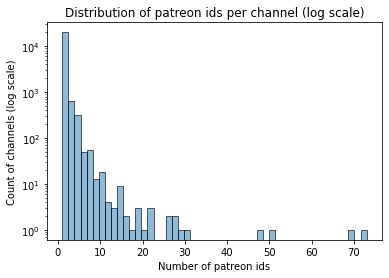

,count,mean,std,min,25%,50%,75%,max
patreon_id_cnt,21240.0,1.321469,1.324881,1.0,1.0,1.0,1.0,73.0


In [13]:
# plot Distribution of patreon ids per channel
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

# plot with log scale for x axis and log scale for y axis
sns.histplot(data=pt_id_cnt_pr_chan, ax=axs, bins=50, kde=False, legend=False, color=f'C{0}')
axs.set(title=f'Distribution of patreon ids per channel (log scale)')
axs.set_xlabel("Number of patreon ids")
axs.set_ylabel("Count of channels (log scale)")
axs.set(yscale="log")

# plt.tight_layout()
plt.show()

# descriptive statistics table
pt_id_cnt_pr_chan.describe().T

**Discussion:** \
As we observed earlier, some channels use more than 1 patreon id, and use different patreon urls for different videos. For example:
- [Patreon_Gaming](https://www.youtube.com/channel/UCAsLyFlWkbdhvri02tO6veA) uses 73 different patreon ids.
- [Artistic Maniacs](https://www.youtube.com/channel/UC3pcSD6_RRisNLaHGznemJA) uses 69 different patreon ids.

In [14]:
# example for Artistic Maniacs
df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan['channel_id'] == 'UC3pcSD6_RRisNLaHGznemJA'].head()

,channel_id,patreon_id,display_id_cnt
2145,UC3pcSD6_RRisNLaHGznemJA,patreon.com/aenamiart,8
2146,UC3pcSD6_RRisNLaHGznemJA,patreon.com/anatofinnstark,1
2147,UC3pcSD6_RRisNLaHGznemJA,patreon.com/andreasrocha,1
2148,UC3pcSD6_RRisNLaHGznemJA,patreon.com/angryrabbitgmod,12
2149,UC3pcSD6_RRisNLaHGznemJA,patreon.com/artwithflo,1


_Optional: Keep only most used patreon_id per channel (patreon_id with most videos for each channel)_

In [15]:
# sort metadata df by diplay_id_cnt within each channel_id group
df_yt_metadata_pt_grp_chan = df_yt_metadata_pt_grp_chan.sort_values(['channel_id','display_id_cnt'], ascending=[True, False])
df_yt_metadata_pt_grp_chan.head(5)

,channel_id,patreon_id,display_id_cnt
0,UC--24Q3_ZQeFmgJE-Um5QZQ,patreon.com/sailoralex,174
1,UC--70ql_IxJmhmqXqrkJrWQ,patreon.com/dakotawint,108
2,UC--70ql_IxJmhmqXqrkJrWQ,patreon.com/mr,1
3,UC--94OGFAzYDOJb0eXgMjew,patreon.com/sailorjerrimusic,2
4,UC--BMyA2X4a9PGAo3lTuopg,patreon.com/psychicpebbles,27


In [16]:
# calculate the number of duplicate of rows with same channel id but different patreon ids
dup_chan_id = df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan.duplicated(subset=['channel_id'], keep='first')]
print("Number of duplicate rows (same channel id with multiple patreon_ids): {:,}".format(len(dup_chan_id)))

Number of duplicate rows (same channel id with multiple patreon_ids): 6,828


In [17]:
# drop duplicate rows, keep the patreon ids with the most videos
df_yt_metadata_unique_pt = df_yt_metadata_pt_grp_chan.drop_duplicates(subset='channel_id', keep='first')
print('Removed {:,} rows'.format(len(df_yt_metadata_pt_grp_chan) - len(df_yt_metadata_unique_pt)))
df_yt_metadata_unique_pt.head()

Removed 6,828 rows


,channel_id,patreon_id,display_id_cnt
0,UC--24Q3_ZQeFmgJE-Um5QZQ,patreon.com/sailoralex,174
1,UC--70ql_IxJmhmqXqrkJrWQ,patreon.com/dakotawint,108
3,UC--94OGFAzYDOJb0eXgMjew,patreon.com/sailorjerrimusic,2
4,UC--BMyA2X4a9PGAo3lTuopg,patreon.com/psychicpebbles,27
5,UC--SaadDxRXz729rtbQqyBA,patreon.com/djbit3,1


#### "Match" dataframe (channel/patreon)

Consider them linked only if 
- [TODO] there is a Patreon link >10% of their videos and if the second most common Patreon link occurs less than 2-3 videos.
- [TODO] Remove channels whose patreon ids are not unique
- Match YouTube channel to Patreon id which appears in most of its videos

In [18]:
# store into new "matched" dataframe
df_matched_channel_patreon = df_yt_metadata_unique_pt[['channel_id', 'patreon_id']]
df_matched_channel_patreon.head()

,channel_id,patreon_id
0,UC--24Q3_ZQeFmgJE-Um5QZQ,patreon.com/sailoralex
1,UC--70ql_IxJmhmqXqrkJrWQ,patreon.com/dakotawint
3,UC--94OGFAzYDOJb0eXgMjew,patreon.com/sailorjerrimusic
4,UC--BMyA2X4a9PGAo3lTuopg,patreon.com/psychicpebbles
5,UC--SaadDxRXz729rtbQqyBA,patreon.com/djbit3


In [19]:
# save "matched" dataframe to LOCAL SCRATCH FOLDER as a compressed tsv
# output_file_path = LOCAL_DATA_FOLDER+"df_matched_channel_patreon.tsv.gz"
# df_matched_channel_patreon.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

##### [_Ignore for now_] Further Observation

**Further Observation:** \
When grouping YouTube metadata by `channel_id` and `patreon_id`, we also notice that we have more rows than the total number of unique patreon ids. \
This is because some `patreon_id` are used on multiple channels. 

In [20]:
print("total rows:                        {:,}".format(len(df_yt_metadata_pt_grp_chan)))
print("total number of unique patreon ids {:,}".format(df_yt_metadata_pt.patreon_id.nunique()))

total rows:                        28,068
total number of unique patreon ids 23,064


In [21]:
# show patreon_id that are used on multiple channels.
df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan.duplicated(subset=['patreon_id'], keep=False)].sort_values(by='patreon_id')

,channel_id,patreon_id,display_id_cnt
19331,UCfvhiiGAUoDiKAIOFAxvNww,patreon.com/1041uuu,2
25794,UCuVgoagmU3hmfMwtxG9s4Sw,patreon.com/1041uuu,1
10117,UCLbqTgHJrwvG1SquY7l7PyA,patreon.com/2ndgearsquad,154
10201,UCLp0O2NXaQVaHNPwx7c_o6A,patreon.com/2ndgearsquad,87
6814,UCEMTTPWO26rr0L3F8CqU0Og,patreon.com/2ndgearsquad,1
...,...,...,...
968,UC1CJLPdVVaNnBnrKtAmhpgA,patreon.com/zwirek,1
12293,UCQgLEMc2YMuZ-CFIEZOu8Sw,patreon.com/zwirek,2
11102,UCNv47vPDSfCOTPhQyWXdiXw,patreon.com/zwirek,4
22025,UCm7WhqAKgd3sznUajXSQpGA,patreon.com/zwirek,1


In [22]:
print("[Filtered YouTube metadata] number of channels per patreon id:")

chan_cnt_per_patreon_id = df_yt_metadata_pt.groupby('patreon_id')\
                                            .agg(channel_id_count=('channel_id', 'count'))\
                                            .sort_values(by=['channel_id_count'], ascending=False)
chan_cnt_per_patreon_id
# chan_cnt_per_patreon_id.reset_index()

[Filtered YouTube metadata] number of channels per patreon id:


,channel_id_count
patreon_id,
patreon.com/darksydephil,18635
patreon.com/bepatron,15047
patreon.com/wanderbot,12548
patreon.com/sebastiansb,11059
patreon.com/easymusiclesson,7601
...,...
patreon.com/stonecirclemuseum,1
patreon.com/heymelby,1
patreon.com/hfqezine,1


##### [_Ignore for now_] Number of videos per patreon id

In [23]:
# group by patreon_id and count the number of unique display_ids
vids_cnt_per_patreon_id = df_yt_metadata_pt.groupby('patreon_id').agg({"display_id": pd.Series.nunique}).sort_values(by='display_id', ascending=False)
vids_cnt_per_patreon_id.rename(columns={'display_id':'display_id_cnt'}, inplace=True)

print("[Filtered YouTube metadata] number of videos per patreon id:")
vids_cnt_per_patreon_id

[Filtered YouTube metadata] number of videos per patreon id:


,display_id_cnt
patreon_id,
patreon.com/darksydephil,18635
patreon.com/bepatron,15047
patreon.com/wanderbot,12548
patreon.com/sebastiansb,11059
patreon.com/easymusiclesson,7601
...,...
patreon.com/stonecirclemuseum,1
patreon.com/heymelby,1
patreon.com/hfqezine,1


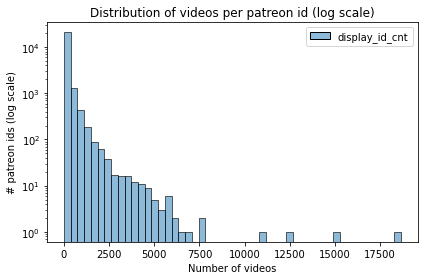

,count,mean,std,min,25%,50%,75%,max
display_id_cnt,23064.0,148.176032,420.974628,1.0,4.0,32.0,128.0,18635.0


In [24]:
# plot with linear scale for both axes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))


# plot with log scale for x axis and log scale for y axis
sns.histplot(data=vids_cnt_per_patreon_id, ax=axs, bins=50, kde=False, color=f'C{0}')
axs.set(title=f'Distribution of videos per patreon id (log scale)')
axs.set_xlabel("Number of videos")
axs.set_ylabel("# patreon ids (log scale)")
axs.set(yscale="log")

plt.tight_layout()
plt.show()

# descriptive statistics table
vids_cnt_per_patreon_id.describe().T

**Discussion:** \
From the above graph and table, we can see that the _videos_ distributions among patreon ids follows a **power law**, meaning that most patreon accounts have a only a few videos, but a few of them have a lot of videos.

More specifically:
- 25% of the Patreon accounts have 1 video
- 50% of the Patreon accounts have less than 4 videos

### 2.2 Filter YouTube timeseries - Restrict YouTube channels (4 filters)
Restrict YouTube channels according to the following criteria (filters are applied sequentially):
- Filter 1: Keep only YouTube channels that are in YouTube Timeseries dataset AND linked to a patreon account 
- Filter 2: At least 2 year between first and last video
- Filter 3: At least 20 videos with patreon ids
- Filter 4: At least 250k subscribers at data crawling time

In [25]:
!ls -lh {DATA_FOLDER}df_timeseries_en.tsv.gz

-rw-r--r-- 1 horta dlab_AppGrpU 545M Dec 16  2020 /dlabdata1/youtube_large/df_timeseries_en.tsv.gz


In [26]:
# load channel-level time-series. (takes about 50 secs)
df_yt_timeseries = pd.read_csv(DATA_FOLDER+'df_timeseries_en.tsv.gz', sep="\t", compression='gzip', parse_dates=['datetime'])

In [27]:
df_yt_timeseries.head(3)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,835393.750000,441308.083333,1501.500000,455.500000,6,0,1


In [28]:
# Define global values for filters
MIN_DAYS_DELTA = "730 day"    # filter 2
NB_PATREON_VIDS = 20          # filter 3
NB_SUBS = 250_000             # filter 4

In [29]:
# Nb of channels of original YT timeseries dataset (need to first load df_yt_timeseries in 1.1.2)
yt_ts_uniq_chan_cnt = df_yt_timeseries['channel'].nunique()
print("[YouTube Timeseries] Nb of rows of original dataset:                  {:>10,}".format(len(df_yt_timeseries)))
print("[YouTube Timeseries] Nb of channels of original dataset:              {:>10,}".format(yt_ts_uniq_chan_cnt))

[YouTube Timeseries] Nb of rows of original dataset:                  18,872,499
[YouTube Timeseries] Nb of channels of original dataset:                 133,516


---
##### **• Filter 1:** Keep only YouTube channels that are in YouTube Timeseries dataset AND linked to a patreon account

In [30]:
# Apply filter 1: retain only the YT channels that exist in the filtered YT metadata dataset (need to first load df_yt_metadata_pt and yt_pt_channel_list in 2.2.1)
df_yt_timeseries_filt1 = df_yt_timeseries[df_yt_timeseries['channel'].isin(yt_pt_channel_list)]
chan_list_filt1 = df_yt_timeseries_filt1['channel'].unique()
chan_list_filt1_cnt = len(chan_list_filt1)

print("[YouTube Timeseries] Nb of rows of after applying filter 1:           {:>10,} ({:5.1%} of original dataset)".format(len(df_yt_timeseries_filt1), len(df_yt_timeseries_filt1)/len(df_yt_timeseries)))
print("[YouTube Timeseries] Nb of channels after applying filter 1:          {:>10,} ({:5.1%} of original dataset)".format(chan_list_filt1_cnt, chan_list_filt1_cnt/yt_ts_uniq_chan_cnt))

[YouTube Timeseries] Nb of rows of after applying filter 1:            3,104,787 (16.5% of original dataset)
[YouTube Timeseries] Nb of channels after applying filter 1:              20,807 (15.6% of original dataset)


---
##### **• Filter 2:** At least 2 year between first and last video

In [31]:
# among filter1 channels, calculate time difference between the first and the last video for each channel
datetime_data = df_yt_timeseries_filt1.groupby('channel').agg(datetime_min=('datetime', 'min'),
                                                              datetime_max=('datetime', 'max'))
datetime_data['delta_datetime'] = datetime_data['datetime_max'] - datetime_data['datetime_min']

# filter channels that we have data for at least MIN_TIME_DELTA days
datetime_data_filt2 = datetime_data[datetime_data['delta_datetime'] > pd.Timedelta(MIN_DAYS_DELTA)]

# Apply filter on YT Timeseries dataset: retain only those channels that have data for at least MIN_TIME_DELTA days
df_yt_timeseries_filt2 = df_yt_timeseries_filt1[df_yt_timeseries_filt1['channel'].isin(datetime_data_filt2.index)]

chan_list_filt2 = df_yt_timeseries_filt2['channel'].unique()
chan_list_filt2_cnt = len(chan_list_filt2)

print("[YouTube Timeseries] Nb of rows of after applying filter 1+2:         {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 1 dataset)".format(len(df_yt_timeseries_filt2), len(df_yt_timeseries_filt2)/len(df_yt_timeseries), len(df_yt_timeseries_filt2)/len(df_yt_timeseries_filt1)))
print("[YouTube Timeseries] Nb of channels after applying filter 1+2:        {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 1 channels)".format(chan_list_filt2_cnt, chan_list_filt2_cnt/yt_ts_uniq_chan_cnt, chan_list_filt2_cnt/chan_list_filt1_cnt))

[YouTube Timeseries] Nb of rows of after applying filter 1+2:          2,918,755 (15.5% of original dataset, 94.0% of filter 1 dataset)
[YouTube Timeseries] Nb of channels after applying filter 1+2:            18,227 (13.7% of original dataset, 87.6% of filter 1 channels)


___

##### **• Filter 3:** At least 20 videos with patreon ids per channel 

In [32]:
# group by channel_id AND patreon_id and count the number of unique videos (=display_ids). (need to load df_yt_metadata_pt_grp_chan from point 2.2.1)
# Then filter rows that have at least 20 videos (display_ids) 
df_yt_metadata_pt_grp_chan_filt3 = df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan['display_id_cnt'] > NB_PATREON_VIDS]
df_yt_metadata_pt_grp_chan_filt3

# get list of unique channels satisfying filter 3
chan_list_filt_3 = df_yt_metadata_pt_grp_chan_filt3['channel_id'].unique()

# Apply filter on YT Timeseries dataset: retain only those channels from filt 2 that are in the chan_list_filt_3
df_yt_timeseries_filt3 = df_yt_timeseries_filt2[df_yt_timeseries_filt2['channel'].isin(chan_list_filt_3)]

chan_list_filt3 = df_yt_timeseries_filt3['channel'].unique()
chan_list_filt3_cnt = len(chan_list_filt3)

print("[YouTube Timeseries] Nb of rows of after applying filter 1+2+3:       {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 2 dataset)".format(len(df_yt_timeseries_filt3), len(df_yt_timeseries_filt3)/len(df_yt_timeseries), len(df_yt_timeseries_filt3)/len(df_yt_timeseries_filt2)))
print("[YouTube Timeseries] Nb of channels after applying filter 1+2+3:      {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 2 channels)".format(chan_list_filt3_cnt, chan_list_filt3_cnt/yt_ts_uniq_chan_cnt, chan_list_filt3_cnt/chan_list_filt2_cnt))

[YouTube Timeseries] Nb of rows of after applying filter 1+2+3:        1,805,570 ( 9.6% of original dataset, 61.9% of filter 2 dataset)
[YouTube Timeseries] Nb of channels after applying filter 1+2+3:          11,278 ( 8.4% of original dataset, 61.9% of filter 2 channels)


---
##### **• Filter 4:** At least 250k subscribers at data crawling time

In [33]:
# Aggregates per channel
subs_aggr_per_channel = df_yt_timeseries_filt3.groupby('channel')\
                                               .agg(min_subs=('subs', 'min'),
                                                    max_subs=('subs', 'max'))\
                                                .sort_values(by=['max_subs'], ascending=False)\
                                                .reset_index()
# subs_aggr_per_channel.head()

In [34]:
# Need to first load data_per_channel (aggregates per channel in 1.1.2 'Datetime points accross channels' section)
subs_per_channel_filt4 = subs_aggr_per_channel[subs_aggr_per_channel['max_subs'] > NB_SUBS]

# get list of unique channels satisfying filter 4
chan_list_filt_4 = subs_per_channel_filt4['channel'].unique()

# # Apply filter on YT Timeseries dataset: retain only those channels from filt_3 that are in the chan_list_filt_4
df_yt_timeseries_filt4 = df_yt_timeseries_filt3[df_yt_timeseries_filt3['channel'].isin(chan_list_filt_4)]

chan_list_filt4 = df_yt_timeseries_filt4['channel'].unique()
chan_list_filt4_cnt = len(chan_list_filt4)

print("[YouTube Timeseries] Nb of rows of after applying filter 1+2+3+4:     {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 3 dataset)".format(len(df_yt_timeseries_filt4), len(df_yt_timeseries_filt4)/len(df_yt_timeseries), len(df_yt_timeseries_filt4)/len(df_yt_timeseries_filt3)))
print("[YouTube Timeseries] Nb of channels after applying filter 1+2+3+4:    {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 3 channels)".format(chan_list_filt4_cnt, chan_list_filt4_cnt/yt_ts_uniq_chan_cnt, chan_list_filt4_cnt/chan_list_filt3_cnt))

[YouTube Timeseries] Nb of rows of after applying filter 1+2+3+4:        311,412 ( 1.7% of original dataset, 17.2% of filter 3 dataset)
[YouTube Timeseries] Nb of channels after applying filter 1+2+3+4:         2,023 ( 1.5% of original dataset, 17.9% of filter 3 channels)


---
##### **• Filter 4b**: At least 50k subscribers in the first 6 months

___
___
**• Filters summary**

In [35]:
print("[YouTube Timeseries] Stats before and after filters:")
print()

print("Filter 1 = \"keep only YouTube channels that are in YouTube Timeseries dataset AND linked to a patreon account\"")
print("Filter 2 = \"at least {:.1f} years ({} days) between first and last video\"".format(pd.Timedelta(MIN_DAYS_DELTA).days/365, pd.Timedelta(MIN_DAYS_DELTA).days))
print("Filter 3 = \"at least {:,} videos with patreon ids per channel\"".format(NB_PATREON_VIDS))
print("Filter 4 = \"at least {:,} subscribers at data crawling time\"".format(NB_SUBS))
print()




print("[YouTube Timeseries] Nb of rows of original dataset:                  {:>10,}".format(len(df_yt_timeseries)))
print("[YouTube Timeseries] Nb of rows of after applying filter 1:           {:>10,} ({:5.1%} of original dataset)".format(len(df_yt_timeseries_filt1), len(df_yt_timeseries_filt1)/len(df_yt_timeseries)))
print("[YouTube Timeseries] Nb of rows of after applying filter 1+2:         {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 1 dataset)".format(len(df_yt_timeseries_filt2), len(df_yt_timeseries_filt2)/len(df_yt_timeseries), len(df_yt_timeseries_filt2)/len(df_yt_timeseries_filt1)))
print("[YouTube Timeseries] Nb of rows of after applying filter 1+2+3:       {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 2 dataset)".format(len(df_yt_timeseries_filt3), len(df_yt_timeseries_filt3)/len(df_yt_timeseries), len(df_yt_timeseries_filt3)/len(df_yt_timeseries_filt2)))
print("[YouTube Timeseries] Nb of rows of after applying filter 1+2+3+4:     {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 3 dataset)".format(len(df_yt_timeseries_filt4), len(df_yt_timeseries_filt4)/len(df_yt_timeseries), len(df_yt_timeseries_filt4)/len(df_yt_timeseries_filt3)))


print()

print("[YouTube Timeseries] Nb of channels of original dataset:              {:>10,}".format(yt_ts_uniq_chan_cnt))
print("[YouTube Timeseries] Nb of channels after applying filter 1:          {:>10,} ({:5.1%} of original dataset)".format(chan_list_filt1_cnt, chan_list_filt1_cnt/yt_ts_uniq_chan_cnt))
print("[YouTube Timeseries] Nb of channels after applying filter 1+2:        {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 1 channels)".format(chan_list_filt2_cnt, chan_list_filt2_cnt/yt_ts_uniq_chan_cnt, chan_list_filt2_cnt/chan_list_filt1_cnt))
print("[YouTube Timeseries] Nb of channels after applying filter 1+2+3:      {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 2 channels)".format(chan_list_filt3_cnt, chan_list_filt3_cnt/yt_ts_uniq_chan_cnt, chan_list_filt3_cnt/chan_list_filt2_cnt))
print("[YouTube Timeseries] Nb of channels after applying filter 1+2+3+4:    {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 3 channels)".format(chan_list_filt4_cnt, chan_list_filt4_cnt/yt_ts_uniq_chan_cnt, chan_list_filt4_cnt/chan_list_filt3_cnt))
print()


print('[YouTube Timeseries] Time range of original dataset                   {} and {}'.format(df_yt_timeseries['datetime'].min().strftime('%B %d, %Y'),
                                                              df_yt_timeseries['datetime'].max().strftime('%B %d, %Y')))

print('[YouTube Timeseries] Time range after applying filter 1+2+3+4        {} and {}'.format(df_yt_timeseries_filt4['datetime'].min().strftime('%B %d, %Y'),
                                                              df_yt_timeseries_filt4['datetime'].max().strftime('%B %d, %Y')))

display(df_yt_timeseries_filt4.head())

print("Restricted list of channels after 4 filters (count = {:,}):".format(chan_list_filt4_cnt))
print(chan_list_filt4)

[YouTube Timeseries] Stats before and after filters:

Filter 1 = "keep only YouTube channels that are in YouTube Timeseries dataset AND linked to a patreon account"
Filter 2 = "at least 2.0 years (730 days) between first and last video"
Filter 3 = "at least 20 videos with patreon ids per channel"
Filter 4 = "at least 250,000 subscribers at data crawling time"

[YouTube Timeseries] Nb of rows of original dataset:                  18,872,499
[YouTube Timeseries] Nb of rows of after applying filter 1:            3,104,787 (16.5% of original dataset)
[YouTube Timeseries] Nb of rows of after applying filter 1+2:          2,918,755 (15.5% of original dataset, 94.0% of filter 1 dataset)
[YouTube Timeseries] Nb of rows of after applying filter 1+2+3:        1,805,570 ( 9.6% of original dataset, 61.9% of filter 2 dataset)
[YouTube Timeseries] Nb of rows of after applying filter 1+2+3+4:        311,412 ( 1.7% of original dataset, 17.2% of filter 3 dataset)

[YouTube Timeseries] Nb of channels of

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
2490,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-03 00:00:00,319074.000000,0.000000,3960.000000,0.000000,665,0,30
2491,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-10 00:00:00,347241.125000,28167.125000,4383.500000,423.500000,669,4,33
2492,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-17 00:00:00,381726.250000,34485.125000,4953.250000,569.750000,675,6,29
2493,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-24 00:00:00,446928.125000,65201.875000,5601.125000,647.875000,681,6,12
2494,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-30 23:00:00,510910.782383,63982.657383,6306.818653,705.693653,682,1,13


Restricted list of channels after 4 filters (count = 2,023):
['UCltVEZ6GecWntoZ19FvaWhQ' 'UCk40qSGYnVdFFBNXRjrvdpQ'
 'UCQMbf4NfHCJO0WP8NpSqgCA' ... 'UCwnKziETDbHJtx78nIkfYug'
 'UCkuqaHz3WWM2oUgFh3H9q9w' 'UCY6Ij8zOds0WJEeqCLOnqOQ']


[ignore] Match patreon_ids and channel_ids

In [36]:
# # filter YT metadata dataset by list of filtered channels from YT timeseries above
# df_yt_metadata_pt_restr = df_yt_metadata_pt[df_yt_metadata_pt['channel_id'].isin(chan_list_filt4)]

# # get unique channels for youtube metadata (original and restricted)
# yt_metadata_uniq_chan = df_yt_metadata_pt['channel_id'].unique()
# yt_metadata_uniq_chan_restr = df_yt_metadata_pt_restr['channel_id'].unique()

# # get unique patreon ids for youtube metadata (original and restricted)
# yt_metadata_uniq_pat = df_yt_metadata_pt['patreon_id'].unique()
# yt_metadata_uniq_pat_restr = df_yt_metadata_pt_restr['patreon_id'].unique()

# print("[YouTube Metadata]:")
# print()
# print("Restriction = \"keep only YouTube channels that are in YouTube Timeseries filtered (filters 1-4) dataset\"")
# print()
# # print("[YouTube Metadata] Nb of videos in original dataset:                                   {:>10,}".format(DF_YT_METADATA_ROWS))
# # print("[YouTube Metadata] Nb of videos in pre-filtered (containing patreon id) dataset:       {:>10,}".format(len(df_yt_metadata_pt)))
# # print("[YouTube Metadata] Nb of videos after filtering by restricted channels:                {:>10,} ({:5.1%} of pre-filtered dataset dataset)".format(len(df_yt_metadata_pt_restr), len(df_yt_metadata_pt_restr)/len(df_yt_metadata_pt)))
# # print()
# print("[YouTube Metadata] Nb of channels in pre-filtered (containing patreon id) dataset:     {:>10,}".format(len(yt_metadata_uniq_chan)))
# print("[YouTube Metadata] Nb of channels after filtering by restricted channels:              {:>10,} ({:5.1%} of pre-filtered dataset dataset)".format(len(yt_metadata_uniq_chan_restr), len(yt_metadata_uniq_chan_restr)/len(yt_metadata_uniq_chan)))
# print()
# print("[YouTube Metadata] Nb of patreon ids in pre-filtered (containing patreon id) dataset:  {:>10,}".format(len(yt_metadata_uniq_pat)))
# print("[YouTube Metadata] Nb of patreon ids after filtering by restricted channels:           {:>10,} ({:5.1%} of pre-filtered dataset dataset)".format(len(yt_metadata_uniq_pat_restr), len(yt_metadata_uniq_pat_restr)/len(yt_metadata_uniq_pat)))


### 2.3 Filter Graphtreon to keep only the ones matching patreon id

GT_timeseries_filter_results_032622.jpg _(filter script in scripts/scripts.ipynb)_
<div>
    <img src="img/GT_timeseries_filter_results_032622.jpg" alt="GT_timeseries_filter_results_032622.jpg" />
</div>

In [37]:
# declare global variable for size of original GT dataset
GT_final_processed_file_ROWS = 232_269

In [38]:
!ls -lh {LOCAL_DATA_FOLDER}df_gt_timeseries_filtered.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 334M Mar 26 20:57 local_data/df_gt_timeseries_filtered.tsv.gz


In [39]:
df_gt_timeseries_filtered = pd.read_csv(LOCAL_DATA_FOLDER+"df_gt_timeseries_filtered.tsv.gz", sep="\t", compression='gzip')
df_gt_timeseries_filtered.head(3)

,creatorName,creatorRange,startDate,categoryTitle,dailyGraph_patronSeriesData,dailyGraph_earningsSeriesData,monthlyGraph_patronSeriesData,monthlyGraph_earningsSeriesData,rankingHistoryGraph_seriesData,twitterSeriesData,youtubeSeriesData,patreon,facebookSeriesData
0,Redhead Redemption,month,09/30/2016,Adult Video,"[1475107200000,3],[1475193600000,6],[147528000...","[1475107200000,6.29],[1475193600000,32.39],[14...","[1472688000000,8],[1475280000000,29],[14779584...","[1472688000000,54.98],[1475280000000,445.41],[...","[1475107200000,6388],[1475193600000,4462],[147...","[1475107200000,106404],[1475193600000,106392],...","[1475107200000,1642],[1475193600000,1713],[147...",patreon.com/redheadredemption,NaN
1,IDRlabs,month,01/31/2018,Video,"[1517270400000,1],[1517356800000,1],[151744320...","[1517270400000,0.9],[1517356800000,0.92],[1517...","[1514764800000,1],[1517443200000,3],[151986240...","[1514764800000,0.92],[1517443200000,6.06],[151...","[1517270400000,24182],[1517356800000,23640],[1...","[1534982400000,1037],[1535068800000,1042],[153...","[1519084800000,14333],[1519171200000,14412],[1...",patreon.com/idrlabs,"[1519084800000,1900],[1519171200000,1905],[151..."
2,Jvy Pennant,month,08/29/2017,Video,"[1503878400000,1],[1503964800000,1],[150405120...","[1503878400000,4.5],[1503964800000,4.5],[15040...","[1501545600000,1],[1504224000000,1],[150681600...","[1501545600000,4.36],[1504224000000,4.36],[150...","[1503878400000,17745],[1503964800000,17723],[1...","[1503878400000,900],[1503964800000,901],[15040...","[1503878400000,6423],[1503964800000,6426],[150...",patreon.com/SupportJvyPennant,NaN


In [40]:
print("Statistics of loaded pre-filtered Graphtreon Timeseries file:")
print("[Graphtreon Timeseries] Total number of patreon ids:                                                   {:>9,}".format(GT_final_processed_file_ROWS))
print("[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YT metadata:            {:>9,} ({:.1%} of GT timeseries dataset)".format(len(df_gt_timeseries_filtered), len(df_gt_timeseries_filtered)/GT_final_processed_file_ROWS))


Statistics of loaded pre-filtered Graphtreon Timeseries file:
[Graphtreon Timeseries] Total number of patreon ids:                                                     232,269
[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YT metadata:               15,639 (6.7% of GT timeseries dataset)


#### 2.3.1. Join GT timeseries with matched channel_id
match the channels in the restricted list of channels of the matched dataframe 

In [41]:
# join GT timeseries and matched channels
df_gt_timeseries_merged = df_gt_timeseries_filtered.merge(df_matched_channel_patreon, left_on='patreon', right_on='patreon_id')
df_gt_timeseries_merged.head(3)

,creatorName,creatorRange,startDate,categoryTitle,dailyGraph_patronSeriesData,dailyGraph_earningsSeriesData,monthlyGraph_patronSeriesData,monthlyGraph_earningsSeriesData,rankingHistoryGraph_seriesData,twitterSeriesData,youtubeSeriesData,patreon,facebookSeriesData,channel_id,patreon_id
0,Redhead Redemption,month,09/30/2016,Adult Video,"[1475107200000,3],[1475193600000,6],[147528000...","[1475107200000,6.29],[1475193600000,32.39],[14...","[1472688000000,8],[1475280000000,29],[14779584...","[1472688000000,54.98],[1475280000000,445.41],[...","[1475107200000,6388],[1475193600000,4462],[147...","[1475107200000,106404],[1475193600000,106392],...","[1475107200000,1642],[1475193600000,1713],[147...",patreon.com/redheadredemption,NaN,UCpHZ2Zja5MDrAv1L577Z-TQ,patreon.com/redheadredemption
1,IDRlabs,month,01/31/2018,Video,"[1517270400000,1],[1517356800000,1],[151744320...","[1517270400000,0.9],[1517356800000,0.92],[1517...","[1514764800000,1],[1517443200000,3],[151986240...","[1514764800000,0.92],[1517443200000,6.06],[151...","[1517270400000,24182],[1517356800000,23640],[1...","[1534982400000,1037],[1535068800000,1042],[153...","[1519084800000,14333],[1519171200000,14412],[1...",patreon.com/idrlabs,"[1519084800000,1900],[1519171200000,1905],[151...",UCRA-4MYd3qmNfvtNxA6_X1Q,patreon.com/idrlabs
2,TechnoMafia,month,12/05/2019,Video,"[1575417600000,1],[1575504000000,1],[157559040...","[1575417600000,4.5],[1575504000000,4.5],[15755...","[1575158400000,1]","[1575158400000,4.33]","[1575417600000,25615],[1575504000000,25490],[1...","[1575417600000,282],[1575504000000,283],[15755...","[1575417600000,26700],[1575504000000,26800],[1...",patreon.com/technomafia,NaN,UCc-5CARuiQdsdY0AF_wJ7SQ,patreon.com/technomafia


#### 2.3.2. Filter/Restrict GT timeseries further
We now want to reduce the Graphtreon dataset by keeping only rows in filtered list of channels (chan_list_filt4)

In [42]:
# filter Graphtreon dataset by keeping only rows in filtered list of channels (chan_list_filt4)
df_gt_timeseries_restricted = df_gt_timeseries_merged[df_gt_timeseries_merged['channel_id'].isin(chan_list_filt4)]

print("[Graphtreon Timeseries] Total number of patreon ids:                                                   {:>9,}".format(GT_final_processed_file_ROWS))
print("[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YT metadata:            {:>9,} ({:.1%} of GT timeseries dataset)".format(len(df_gt_timeseries_filtered), len(df_gt_timeseries_filtered)/GT_final_processed_file_ROWS))
print("[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YT metadata restricted  {:>9,} ({:.1%} of GT timeseries dataset)".format(len(df_gt_timeseries_restricted), len(df_gt_timeseries_restricted)/GT_final_processed_file_ROWS))


[Graphtreon Timeseries] Total number of patreon ids:                                                     232,269
[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YT metadata:               15,639 (6.7% of GT timeseries dataset)
[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YT metadata restricted      1,036 (0.4% of GT timeseries dataset)


#### 2.3.3 Extract the date and daily earnings per patreon account

In [43]:
# get list of all unique patreon ids in df_gt_timeseries_restricted
yt_gt_patreon_list_restricted = df_gt_timeseries_restricted.patreon.unique()
print("list of restricted patreon ids", yt_gt_patreon_list_restricted)
print("number of restricted patreon ids", len(yt_gt_patreon_list_restricted))

list of restricted patreon ids ['patreon.com/fooligan' 'patreon.com/pitmasterx' 'patreon.com/lethalchris'
 ... 'patreon.com/varyjermotivation' 'patreon.com/theproperpeople'
 'patreon.com/deadmeatjames']
number of restricted patreon ids 1008


In [44]:
df_gt_timeseries_restricted.head(3)

,creatorName,creatorRange,startDate,categoryTitle,dailyGraph_patronSeriesData,dailyGraph_earningsSeriesData,monthlyGraph_patronSeriesData,monthlyGraph_earningsSeriesData,rankingHistoryGraph_seriesData,twitterSeriesData,youtubeSeriesData,patreon,facebookSeriesData,channel_id,patreon_id
10,Fooligan,month,01/22/2018,Video,"[1516492800000,34],[1516579200000,34],[1516665...","[1520380800000,191.35],[1520467200000,209.32],...","[1514764800000,30],[1517443200000,29],[1519862...","[1519862400000,200.74],[1522540800000,206.74],...","[1516492800000,3925],[1516579200000,4021],[151...","[1516492800000,5036],[1516579200000,5036],[151...","[1516492800000,571679],[1516579200000,571849],...",patreon.com/fooligan,"[1516492800000,14879],[1516579200000,14906],[1...",UCUPr-L6BprRHBS0EIBxciCA,patreon.com/fooligan
12,pitmasterx,month,04/05/2018,Video,"[1522800000000,1],[1522886400000,1],[152297280...","[1522800000000,0.9],[1522886400000,0.9],[15229...","[1522540800000,2],[1525132800000,8],[152781120...","[1522540800000,5.2],[1525132800000,33.42],[152...","[1522886400000,26785],[1522972800000,26124],[1...","[1571443200000,1229],[1571529600000,1230],[157...","[1522800000000,107315],[1522886400000,107331],...",patreon.com/pitmasterx,"[1522800000000,184551],[1522886400000,184564],...",UC_kARM8MBLDBxZQuZeYYQdQ,patreon.com/pitmasterx
17,Christopher Straver,month,02/17/2016,Drawing &amp; Painting,"[1455580800000,2],[1455667200000,2],[145575360...","[1455580800000,32.08],[1455667200000,32.08],[1...","[1454284800000,2],[1456790400000,2],[145946880...","[1454284800000,32.22],[1456790400000,27.49],[1...","[1456704000000,1000],[1456790400000,974],[1456...","[1460505600000,1897],[1460592000000,1898],[146...","[1460419200000,92710],[1460505600000,92742],[1...",patreon.com/lethalchris,"[1460419200000,3671],[1460505600000,3672],[146...",UCzM8cfTU666_-aFNulLEx2Q,patreon.com/lethalchris


In [45]:
# example of NaN value
# df_gt_timeseries_sample[df_gt_timeseries_sample['creatorName'] == 'Comedy Trap House']

In [46]:
# # From the Graphtreon dataset, for each channel, extract the date and earnings from “dailyGraph_earningsSeriesData” (takes about 3 mins)
# input_file_path = DATA_FOLDER+"/final_processed_file.jsonl.gz"

# MAX_ITER = 100

# nb_rows_read = 0
# valid_predicate_count = 0
# JSONDecodeErrors_cnt = 0 
# dailyEarningsError_cnt = 0 
# lines_json = []    

# compressed_file_size = os.stat(input_file_path).st_size
# print("Compressed file size is :                 {:>8,.2f} GB".format(compressed_file_size / 2**30))

# uncompressed_file_size = 13_310_000_000
# print("Estimated Uncompressed file size is :     {:>8,.2f} GB".format(uncompressed_file_size / 2**30))

# start = timeit.default_timer()

# # Load tqdm with size counter instead of file counter
# with tqdm(total=uncompressed_file_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
#     with gzip.open(input_file_path, "r") as f:
#         for i, line in enumerate(f): 

#             read_bytes = len(line)
#             if read_bytes:
#                 pbar.set_postfix(file=input_file_path[len(DATA_FOLDER)+1:], refresh=False)
#                 pbar.update(read_bytes)

#             nb_rows_read += 1
            
#             # set a maximum iteration for tests
#             if nb_rows_read >= MAX_ITER:
#                 break
    
#             try:
#                 line_json = json.loads(line)
#             except Exception as e:
#                 JSONDecodeErrors_cnt += 1
#                 continue
                
#             # add line if patreon id is exists in df_yt_metadata_pt
#             if line_json['patreon'] in yt_gt_patreon_list_restricted:
#                 valid_predicate_count += 1
                
#                 # Use ast.literal_eval to convert string of lists, to list of list
#                 dailyGraph_earningsSeriesData = line_json.get('dailyGraph_earningsSeriesData')
                
#                 if dailyGraph_earningsSeriesData:
#                     daily_earnings = ast.literal_eval(dailyGraph_earningsSeriesData)
#                 else:
#                     daily_earnings = [[np.nan, np.nan]]
                                            
#                 for daily_earning in daily_earnings:
#                     # case where there are multiple tuples per row
#                     if isinstance(daily_earning, list):
#                         date = daily_earning[0]
#                         earning = daily_earning[1]
#                         lines_json.append({
#                             'creatorName':   line_json.get('creatorName'), 
#                             'creatorRange':  line_json.get('creatorRange'), 
#                             'startDate':     line_json.get('startDate'),
#                             'categoryTitle': line_json.get('categoryTitle'),
#                             'patreon':       line_json.get('patreon'),
#                             'date':          date,
#                             'earning':       earning
#                         })
#                     else:
#                         dailyEarningsError_cnt += 1
#                         print(">>>> dailyEarningsError - skipped line value: ")
#                         print(line_json.get('creatorName'), line_json.get('creatorRange'), line_json.get('startDate'), line_json.get('categoryTitle'), line_json.get('patreon'), daily_earnings)

# stop = timeit.default_timer()
# time_diff = stop - start

# print()
# print("==> total time to read and filter graphtreon time series:                      {:>10.0f} min. ({:.0f}s.)".format(time_diff/60, time_diff)) 
# print("==> number of rows read:                                                       {:>10,}".format(nb_rows_read))
# print("==> number of patreon ids that exist in both GTts and restricted YT metadata:  {:>10,} ({:.2%})".format(valid_predicate_count, valid_predicate_count/nb_rows_read ))
# print("==> number of skipped rows (JSONDecodeErrors):                                 {:>10,}".format(JSONDecodeErrors_cnt))
# print("==> number of skipped rows (dailyEarningsError):                               {:>10,}".format(dailyEarningsError_cnt))

# # create new dataframe with the filtered lines
# df_dailyGraph_earningsSeries = pd.DataFrame(data=lines_json)

GT_timeseries_date_earnings_extract_040422.jpg _(filter script above)_
<div>
    <img src="img/GT_timeseries_date_earnings_extract_040422.jpg" alt="GT_timeseries_date_earnings_extract_040422.jpg" />
</div>

In [47]:
# check for NaN values
# df_dailyGraph_earningsSeries[df_dailyGraph_earningsSeries.isna().any(axis=1)]

In [48]:
# save filtered data to LOCAL SCRATCH FOLDER as a compressed tsv (5.3Mb)
# output_file_path = LOCAL_DATA_FOLDER+"dailyGraph_earningsSeries.tsv.gz"
# df_dailyGraph_earningsSeries.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

#### 2.3.4 Extract the date and daily patrons per patreon account

In [49]:
# # From the Graphtreon dataset, for each channel, extract the date and patrons from “dailyGraph_patronSeriesData” (takes about 3 mins)
# input_file_path = DATA_FOLDER+"/final_processed_file.jsonl.gz"

# MAX_ITER = 1000

# nb_rows_read = 0
# valid_predicate_count = 0
# JSONDecodeErrors_cnt = 0 
# dailyPatronsError_cnt = 0 
# lines_json = []    

# compressed_file_size = os.stat(input_file_path).st_size
# print("Compressed file size is :                 {:>8,.2f} GB".format(compressed_file_size / 2**30))

# uncompressed_file_size = 13_310_000_000
# print("Estimated Uncompressed file size is :     {:>8,.2f} GB".format(uncompressed_file_size / 2**30))

# start = timeit.default_timer()

# # Load tqdm with size counter instead of file counter
# with tqdm(total=uncompressed_file_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
#     with gzip.open(input_file_path, "r") as f:
#         for i, line in enumerate(f): 

#             read_bytes = len(line)
#             if read_bytes:
#                 pbar.set_postfix(file=input_file_path[len(DATA_FOLDER)+1:], refresh=False)
#                 pbar.update(read_bytes)

#             nb_rows_read += 1
            
#             # set a maximum iteration for tests
#             if nb_rows_read >= MAX_ITER:
#                 break
    
#             try:
#                 line_json = json.loads(line)
#             except Exception as e:
#                 JSONDecodeErrors_cnt += 1
#                 continue
                
#             # add line if patreon id is exists in df_yt_metadata_pt
#             if line_json['patreon'] in yt_gt_patreon_list_restricted:
#                 valid_predicate_count += 1
                
#                 # Use ast.literal_eval to convert string of lists, to list of list
#                 dailyGraph_patronSeriesData = line_json.get('dailyGraph_patronSeriesData')
                
#                 if dailyGraph_patronSeriesData:
#                     daily_patrons = ast.literal_eval(dailyGraph_patronSeriesData)
#                 else:
#                     daily_patrons = [[np.nan, np.nan]]
                                            
#                 for daily_patron in daily_patrons:
#                     # case where there are multiple tuples per row
#                     if isinstance(daily_patron, list):
#                         date = daily_patron[0]
#                         patrons = daily_patron[1]
#                         lines_json.append({
#                             'creatorName':   line_json.get('creatorName'), 
#                             'creatorRange':  line_json.get('creatorRange'), 
#                             'startDate':     line_json.get('startDate'),
#                             'categoryTitle': line_json.get('categoryTitle'),
#                             'patreon':       line_json.get('patreon'),
#                             'date':          date,
#                             'patrons':       patrons
#                         })
#                     else:
#                         dailyPatronsError_cnt += 1
#                         print(">>>> dailyPatronsError - skipped line value: ")
#                         print(line_json.get('creatorName'), line_json.get('creatorRange'), line_json.get('startDate'), line_json.get('categoryTitle'), line_json.get('patreon'), daily_patrons)

# stop = timeit.default_timer()
# time_diff = stop - start

# print()
# print("==> total time to read and filter graphtreon time series:                      {:>10.0f} min. ({:.0f}s.)".format(time_diff/60, time_diff)) 
# print("==> number of rows read:                                                       {:>10,}".format(nb_rows_read))
# print("==> number of patreon ids that exist in both GTts and restricted YT metadata:  {:>10,} ({:.2%})".format(valid_predicate_count, valid_predicate_count/nb_rows_read ))
# print("==> number of skipped rows (JSONDecodeErrors):                                 {:>10,}".format(JSONDecodeErrors_cnt))
# print("==> number of skipped rows (dailyPatronsError):                               {:>10,}".format(dailyPatronsError_cnt))

# # create new dataframe with the filtered lines
# df_dailyGraph_patronsSeries = pd.DataFrame(data=lines_json)
# df_dailyGraph_patronsSeries

GT_timeseries_date_patrons_extract_042922.jpg _(filter script above)_
<div>
    <img src="img/GT_timeseries_date_patrons_extract_042922.jpg" alt="GT_timeseries_date_patrons_extract_042922.jpg" />
</div>

In [50]:
# check for NaN values
# df_dailyGraph_patronsSeries[df_dailyGraph_patronsSeries.isna().any(axis=1)]

In [51]:
# save filtered data to LOCAL SCRATCH FOLDER as a compressed tsv (7.1Mb)
# output_file_path = LOCAL_DATA_FOLDER+"dailyGraph_patronsSeries.tsv.gz"
# df_dailyGraph_patronsSeries.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

#### 2.3.5 Merge extracted times series of daily earnings and daily patrons

In [52]:
!ls -lh {LOCAL_DATA_FOLDER}dailyGraph_earningsSeries.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 5.3M Apr  4 10:39 local_data/dailyGraph_earningsSeries.tsv.gz


In [53]:
# read dailyGraph_earningsSeries file from disk and convert dates
df_dailyGraph_earningsSeries = pd.read_csv(LOCAL_DATA_FOLDER+"dailyGraph_earningsSeries.tsv.gz", sep="\t", compression='gzip')
# df_dailyGraph_earningsSeries.date = pd.to_datetime(df_dailyGraph_earningsSeries.date, unit='ms')
df_dailyGraph_earningsSeries

,creatorName,creatorRange,startDate,categoryTitle,patreon,date,earning
0,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520381e+12,191.35
1,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520467e+12,209.32
2,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520554e+12,209.32
3,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520640e+12,209.32
4,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520726e+12,209.32
...,...,...,...,...,...,...,...
895629,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1.533686e+12,5265.54
895630,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1.533773e+12,5209.61
895631,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1.533859e+12,5248.37
895632,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1.533946e+12,5564.16


In [54]:
!ls -lh {LOCAL_DATA_FOLDER}dailyGraph_patronsSeries.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 7.1M Apr 29 11:52 local_data/dailyGraph_patronsSeries.tsv.gz


In [55]:
# read dailyGraph_patronsSeries from disk and convert dates
df_dailyGraph_patronsSeries = pd.read_csv(LOCAL_DATA_FOLDER+"dailyGraph_patronsSeries.tsv.gz", sep="\t", compression='gzip')
# df_dailyGraph_patronsSeries.date = pd.to_datetime(df_dailyGraph_patronsSeries.date, unit='ms')
df_dailyGraph_patronsSeries

,creatorName,creatorRange,startDate,categoryTitle,patreon,date,patrons
0,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1516492800000,34
1,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1516579200000,34
2,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1516665600000,35
3,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1516752000000,35
4,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1516838400000,35
...,...,...,...,...,...,...,...
1422471,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1616112000000,4147
1422472,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1616198400000,4152
1422473,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1616284800000,4155
1422474,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,1616371200000,4163


In [56]:
# join dailyGraph_earningsSeries with df_dailyGraph_patronsSeries
df_dailyGraph_patrons_and_earnings_Series = df_dailyGraph_earningsSeries.merge(df_dailyGraph_patronsSeries, how='outer')

# convert patrons column to Int64 so it can hold NaN values after outer join
df_dailyGraph_patrons_and_earnings_Series['patrons'] = df_dailyGraph_patrons_and_earnings_Series['patrons'].astype('Int64')
df_dailyGraph_patrons_and_earnings_Series.head()

,creatorName,creatorRange,startDate,categoryTitle,patreon,date,earning,patrons
0,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520381e+12,191.35,27
1,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520467e+12,209.32,28
2,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520554e+12,209.32,28
3,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520640e+12,209.32,28
4,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,1.520726e+12,209.32,28


In [57]:
# save filtered data to LOCAL SCRATCH FOLDER as a compressed tsv (6.2Mb)
# output_file_path = LOCAL_DATA_FOLDER+"dailyGraph_patrons_and_earnings_Series.tsv.gz"
# df_dailyGraph_patrons_and_earnings_Series.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

### 2.4 Plots

In [58]:
!ls -lh {LOCAL_DATA_FOLDER}dailyGraph_patrons_and_earnings_Series.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 8.7M Apr 30 12:22 local_data/dailyGraph_patrons_and_earnings_Series.tsv.gz


In [59]:
# read merged dailyGraph_patrons_and_earnings_Series from disk
df_dailyGraph_patrons_and_earnings_Series = pd.read_csv(LOCAL_DATA_FOLDER+"dailyGraph_patrons_and_earnings_Series.tsv.gz", sep="\t", compression='gzip')
df_dailyGraph_patrons_and_earnings_Series['date'] = pd.to_datetime(df_dailyGraph_patrons_and_earnings_Series['date'], unit='ms')
df_dailyGraph_patrons_and_earnings_Series['patrons'] = df_dailyGraph_patrons_and_earnings_Series['patrons'].astype('Int64')

print(df_dailyGraph_patrons_and_earnings_Series.dtypes)
df_dailyGraph_patrons_and_earnings_Series

creatorName              object
creatorRange             object
startDate                object
categoryTitle            object
patreon                  object
date             datetime64[ns]
earning                 float64
patrons                   Int64
dtype: object


,creatorName,creatorRange,startDate,categoryTitle,patreon,date,earning,patrons
0,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-07,191.35,27
1,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-08,209.32,28
2,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-09,209.32,28
3,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-10,209.32,28
4,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-11,209.32,28
...,...,...,...,...,...,...,...,...
1431779,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-19,NaN,4147
1431780,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-20,NaN,4152
1431781,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-21,NaN,4155
1431782,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-22,NaN,4163


#### 2.4.1 Plot Patreon Time Series

In [60]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

In [61]:
# RE-declare global variable for size of original GT dataset
GT_final_processed_file_ROWS = 232_269

##### Restrict to top patrons

In [62]:
TOP_CNT = 863
# group by patreon account, sort by max number of patrons
dailyGraph_grp_patreon = df_dailyGraph_patrons_and_earnings_Series.groupby('patreon')\
                                                     .agg(date_cnt=('date', 'count'),
                                                          earliest_date=('date', 'min'),
                                                          lastest_date=('date', 'max'),
                                                          daily_earning_mean=('earning', 'mean'),
                                                          daily_earning_max=('earning', 'max'),
                                                          daily_patrons_mean=('patrons', 'mean'),
                                                          daily_patrons_max=('patrons', 'max'))\
                                                     .sort_values(by=['daily_patrons_max'], ascending=False)\
                                                     .round(2)

# remove patreon accounts with no earnings data at all
dailyGraph_grp_patreon = dailyGraph_grp_patreon[dailyGraph_grp_patreon['daily_earning_mean'].notna()]
dailyGraph_grp_patreon = dailyGraph_grp_patreon.reset_index()

# remove hours from dates
# dailyGraph_grp_patreon.earliest_date = dailyGraph_grp_patreon.earliest_date.dt.date
# dailyGraph_grp_patreon.lastest_date = dailyGraph_grp_patreon.lastest_date.dt.date

# extract the top most profitable patreon accounts
top_patreons = dailyGraph_grp_patreon[:TOP_CNT]['patreon']

print("[Graphtreon Timeseries] Total number of patreon ids (original file):                      {:>9,}".format(GT_final_processed_file_ROWS))
print("[Graphtreon Timeseries] Nb of patreon ids in dailyGraph patreon + earnings time series:   {:>9,} ({:.1%} of original dataset)".format(len(dailyGraph_grp_patreon), len(dailyGraph_grp_patreon)/GT_final_processed_file_ROWS))

print()

dailyGraph_grp_patreon[:10].style.set_caption(f"Top {TOP_CNT} highest-earning Patreon accounts (sorted by max daily earnings)")


[Graphtreon Timeseries] Total number of patreon ids (original file):                        232,269
[Graphtreon Timeseries] Nb of patreon ids in dailyGraph patreon + earnings time series:         863 (0.4% of original dataset)



,patreon,date_cnt,earliest_date,lastest_date,daily_earning_mean,daily_earning_max,daily_patrons_mean,daily_patrons_max
0,patreon.com/tinymeatgang,1154,2018-01-22 00:00:00,2021-03-23 00:00:00,47430.470000,84009.700000,9762.700000,17800
1,patreon.com/mmoxreview,2017,2015-09-08 00:00:00,2021-03-23 00:00:00,440.610000,2606.880000,4693.210000,16629
2,patreon.com/blindwave,1944,2015-11-18 00:00:00,2021-03-23 00:00:00,20318.470000,44087.400000,5735.400000,14466
3,patreon.com/contrapoints,1723,2016-06-28 00:00:00,2021-03-23 00:00:00,2198.080000,6494.520000,6057.200000,13757
4,patreon.com/thenormies,1606,2016-10-24 00:00:00,2021-03-23 00:00:00,11663.150000,32908.300000,5115.290000,11613
5,patreon.com/bohobeautiful,1412,2017-05-08 00:00:00,2021-03-23 00:00:00,4190.850000,5187.870000,2658.530000,9325
6,patreon.com/lindsayellis,2207,2015-03-24 00:00:00,2021-03-23 00:00:00,3194.530000,6899.150000,3863.350000,9106
7,patreon.com/sonicether,1235,2017-11-04 00:00:00,2021-03-23 00:00:00,29668.040000,73288.800000,3647.370000,8684
8,patreon.com/3blue1brown,1580,2016-11-03 00:00:00,2021-03-23 00:00:00,3074.060000,3830.090000,4962.940000,8212
9,patreon.com/crashcourse,2188,2015-03-18 00:00:00,2021-03-23 00:00:00,29913.800000,34574.500000,6884.100000,8124


In [63]:
df_top_pt_daily_earnings = df_dailyGraph_patrons_and_earnings_Series[df_dailyGraph_patrons_and_earnings_Series['patreon'].isin(top_patreons)]
df_top_pt_daily_earnings

,creatorName,creatorRange,startDate,categoryTitle,patreon,date,earning,patrons
0,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-07,191.35,27
1,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-08,209.32,28
2,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-09,209.32,28
3,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-10,209.32,28
4,Fooligan,month,01/22/2018,Video,patreon.com/fooligan,2018-03-11,209.32,28
...,...,...,...,...,...,...,...,...
1431779,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-19,NaN,4147
1431780,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-20,NaN,4152
1431781,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-21,NaN,4155
1431782,Dead Meat,month,05/20/2017,Video,patreon.com/deadmeatjames,2021-03-22,NaN,4163


4it [00:03,  1.28it/s]


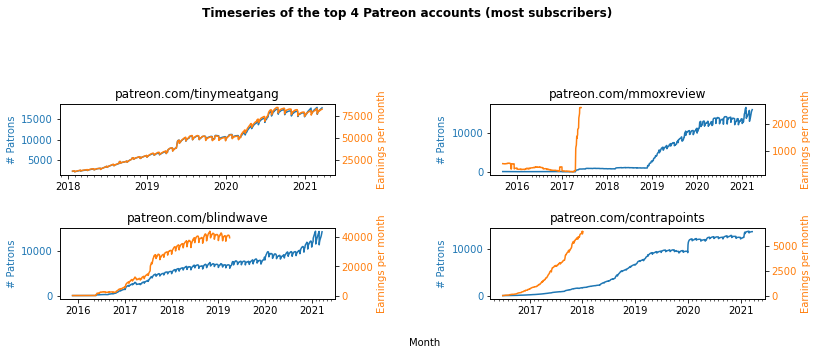

In [64]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

TOP_CNT_local = TOP_CNT
TOP_CNT_local = 4
# plot Patreon daily earningsSeriesData for top patreon accounts
fig, axs = plt.subplots(math.ceil(TOP_CNT_local/2), 2, figsize=(12, TOP_CNT_local*1.2), sharey=False, sharex=False)
for idx, patreon in tqdm(enumerate(top_patreons[:TOP_CNT_local])):
    row = math.floor(idx/2)
    col = idx % 2
    ax1 = axs[row, col]
    
    # ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')
    # ax1.scatter(x[40:],y[40:], s=10, c='r', marker="o", label='second')

    tmp_df = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon]

    # sbplt = axs[idx, 0]
    

    color = 'tab:blue'
    patrons, = ax1.plot(tmp_df['date'], tmp_df['patrons'], color=color, label='patrons')
    ax1.set_ylabel('# Patrons', color=color) 
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set(title=patreon)
    
    
    color = 'tab:orange'
    ax2 = ax1.twinx()  # Create a twin Axes sharing the xaxis.
    earnings, = ax2.plot(tmp_df['date'], tmp_df['earning'], color=color, label='earnings')
    ax2.set_ylabel("Earnings per month", color=color) 
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    # ax1.legend(handles=[earnings, patrons], loc='upper left');
    
fig.suptitle(f'Timeseries of the top {TOP_CNT_local} Patreon accounts (most subscribers) \n', fontweight="bold")
fig.text(0.5,0, 'Month')
# fig.text(0,0.5, 'Earnings per month ($)', rotation = 90)
fig.tight_layout(pad=3, w_pad=5, h_pad=2)

**Observation:**
We can see a drop of income at the beginning of each month. 
--> due to people unsubscribing
--> could do some averaging

In [65]:
# analyse 1 account in detail
patreon_account = 'patreon.com/tinymeatgang'

with pd.option_context('display.max_rows', 90, 'display.min_rows', 90):
    display(df_top_pt_daily_earnings[(df_top_pt_daily_earnings['patreon'] == patreon_account) 
                                     # & (df_top_pt_daily_earnings['date'] > pd.Timestamp('2021-01-01'))
                                    ].head(20))
        
df_top_pt_daily_earnings.dtypes

# check for NaN values
# df_top_pt_daily_earnings[df_top_pt_daily_earnings.isna().any(axis=1)]

,creatorName,creatorRange,startDate,categoryTitle,patreon,date,earning,patrons
556516,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-22,13077.4,2325
556517,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-23,13086.2,2327
556518,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-24,13134.9,2335
556519,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-25,13170.5,2343
556520,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-26,13263.3,2360
556521,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-27,13307.5,2367
556522,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-28,13321.6,2372
556523,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-29,13295.1,2369
556524,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-30,13308.4,2371
556525,TMG,month,01/23/2018,Podcasts,patreon.com/tinymeatgang,2018-01-31,13287.2,2369


creatorName              object
creatorRange             object
startDate                object
categoryTitle            object
patreon                  object
date             datetime64[ns]
earning                 float64
patrons                   Int64
dtype: object

##### Detect breaks / shocks

In [66]:
# n_breaks = 3
# model = rpt.Dynp(model="l1")

# # plot Patreon daily earningsSeriesData for top patreon accounts
# fig, axs = plt.subplots(int(TOP_CNT/2), 2, figsize=(12, TOP_CNT*1.2), sharey=False, sharex=False)
# for idx, patreon in enumerate(top_patreons):
#     print(patreon)
#     row = math.floor(idx/2)
#     col = idx % 2
#     sbplt = axs[row, col]

#     tmp_df = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon]

#     # convert the dataframe into a time series.
#     ts_df = tmp_df.set_index(tmp_df['date'])
#     ts = ts_df['earning']

#     y = np.array(ts.tolist())

#     model.fit(y)
#     breaks = model.predict(n_bkps=n_breaks-1)
    
#     breaks_rpt = []
#     for i in breaks:
#         breaks_rpt.append(ts.index[i-1])
#     breaks_rpt = pd.to_datetime(breaks_rpt)
    
#     sbplt.plot(ts, label='data')
#     sbplt.set(title=patreon)
#     print_legend = True
#     for i in breaks_rpt:
#         if print_legend:
#             sbplt.axvline(i, color='red',linestyle='dashed', label='breaks')
#             print_legend = False
#         else:
#             sbplt.axvline(i, color='red',linestyle='dashed')

#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
#     sbplt.xaxis.grid(color="#CCCCCC", ls=":")
#     sbplt.yaxis.grid(color="#CCCCCC", ls=":")
    
    
# fig.suptitle(f'Timeseries of the top {TOP_CNT} highest-earning Patreon accounts \n (earnings per month in dollars)', fontweight="bold")
# fig.text(0.5,0, 'Month')
# fig.text(0,0.5, 'Earnings per month ($)', rotation = 90)
# fig.tight_layout(pad=3, w_pad=5, h_pad=2)

#### 2.4.2 Plot YouTube timeseries for channels matching top Patreon accounts

In [67]:
# load matching dataframe
df_matched_channel_patreon = pd.read_csv(LOCAL_DATA_FOLDER+"df_matched_channel_patreon.tsv.gz", sep="\t", compression="gzip")

In [68]:
# add patreon_id column to YT timeseries
df_yt_timeseries_filt4_merged = df_yt_timeseries_filt4.merge(df_matched_channel_patreon, left_on='channel', right_on='channel_id')
df_yt_timeseries_filt4_merged.head(1)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,channel_id,patreon_id
0,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-03,319074.0,0.0,3960.0,0.0,665,0,30,UCltVEZ6GecWntoZ19FvaWhQ,patreon.com/ekeeda


In [69]:
# filter channels matching top patreon accounts
df_yt_timeseries_top_pt = df_yt_timeseries_filt4_merged[df_yt_timeseries_filt4_merged['patreon_id'].isin(top_patreons)]


print('[YouTube Timeseries] Time range after applying filter 1+2+3+4              {} and {}'.format(df_yt_timeseries_filt4['datetime'].min().strftime('%B %d, %Y'),
                                                                                                    df_yt_timeseries_filt4['datetime'].max().strftime('%B %d, %Y')))

print('[YouTube Timeseries] Time range after matching top patreon accounts        {} and {}'.format(df_yt_timeseries_top_pt['datetime'].min().strftime('%B %d, %Y'),
                                                                                                    df_yt_timeseries_top_pt['datetime'].max().strftime('%B %d, %Y')))

top_yt_patreons = df_yt_timeseries_top_pt.patreon_id.unique()
top_yt_patreons

[YouTube Timeseries] Time range after applying filter 1+2+3+4              November 23, 2015 and September 30, 2019
[YouTube Timeseries] Time range after matching top patreon accounts        January 11, 2016 and September 30, 2019


array(['patreon.com/taylordavis', 'patreon.com/kwite',
       'patreon.com/3dprintingnerd', 'patreon.com/evynnehollens',
       'patreon.com/nextgentactics', 'patreon.com/fitnessaddict',
       'patreon.com/shmolty', 'patreon.com/yunging19',
       'patreon.com/zueljin', 'patreon.com/emmykalia',
       'patreon.com/justbetweenus', 'patreon.com/twinkieman',
       'patreon.com/squire', 'patreon.com/sibongtv', 'patreon.com/welyn1',
       'patreon.com/wendoverproductions', 'patreon.com/auntydonna',
       'patreon.com/auralnauts', 'patreon.com/skulshurtugaltcg',
       'patreon.com/mollyburke', 'patreon.com/tomaszmro',
       'patreon.com/unitlost', 'patreon.com/eckhartsladder',
       'patreon.com/sarahhawkinson', 'patreon.com/helenrecipes',
       'patreon.com/steveandmaggie', 'patreon.com/aldojones',
       'patreon.com/theinfographicsshow', 'patreon.com/campisicustoms',
       'patreon.com/homefree', 'patreon.com/fooligan',
       'patreon.com/wefancy', 'patreon.com/vgbootcamp',
    

In [70]:
df_yt_timeseries_top_pt.groupby(['patreon_id', 'channel_id'])\
                                                     .agg(datetime_cnt=('datetime', 'count'),
                                                          date_min=('datetime', 'min'),
                                                          date_max=('datetime', 'max'),
                                                          views_max=('views', 'max'),
                                                          subs_date=('subs', 'max'),
                                                          videos_max=('videos', 'mean'))\
                                                     .sort_values(by=['videos_max'], ascending=False)
                                                     #      \
                                                     # .reset_index()\
                                                     # .round(2)

,,datetime_cnt,date_min,date_max,views_max,subs_date,videos_max
patreon_id,channel_id,,,,,,
patreon.com/philsvitek,UCCcVQKtF8zHVQoTJt8NNMJA,155,2016-10-10,2019-09-23,2.186434e+08,310000.000000,13067.406452
patreon.com/seculartalk,UCldfgbzNILYZA4dmDt4Cd6A,156,2016-10-10,2019-09-30,6.035673e+08,724714.285714,10685.448718
patreon.com/davidpakmanshow,UCvixJtaXuNdMPUGdOPcY8Ag,155,2016-10-17,2019-09-30,4.710517e+08,731428.571429,8397.109677
patreon.com/hubbahubbarevue,UCAr8JtvJedbRHHkQVh_ZDoA,176,2016-05-23,2019-09-30,1.072531e+08,346428.571429,7005.204545
patreon.com/runforthecube,UCU-HGStP8v-WXtqXlV2bUHQ,155,2016-10-10,2019-09-23,6.601330e+07,379794.500000,6808.509677
...,...,...,...,...,...,...,...
patreon.com/nathanieldrew,UCrdWRLq10OHuy7HmSckV3Vg,174,2016-06-06,2019-09-30,1.292904e+07,433285.714286,14.275862
patreon.com/misteramazing,UCUG9w-kUDyIenbVnldsa6ug,156,2016-10-10,2019-09-30,8.861608e+06,297000.000000,13.057692
patreon.com/thelibertyhound,UCsGg9JQ4X7u2A6gCEmtVRmw,115,2017-05-01,2019-07-08,1.137108e+08,381429.625000,10.104348


In [71]:
df_yt_timeseries_top_pt.head(3)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,channel_id,patreon_id
156,UCk40qSGYnVdFFBNXRjrvdpQ,Music,2016-10-10,2.229955e+08,7.878442e+05,1.530176e+06,0.000000,156,0,0,UCk40qSGYnVdFFBNXRjrvdpQ,patreon.com/taylordavis
157,UCk40qSGYnVdFFBNXRjrvdpQ,Music,2016-10-17,2.249045e+08,1.908997e+06,1.541966e+06,11789.875000,157,1,1,UCk40qSGYnVdFFBNXRjrvdpQ,patreon.com/taylordavis
158,UCk40qSGYnVdFFBNXRjrvdpQ,Music,2016-10-24,2.269606e+08,2.056104e+06,1.554149e+06,12182.848446,157,0,1,UCk40qSGYnVdFFBNXRjrvdpQ,patreon.com/taylordavis


In [72]:
# # plot YT cumulative views timeseries for top patreon accounts
# fig, axs = plt.subplots(int(math.ceil(len(top_yt_patreons)/2)), 2, figsize=(12, len(top_yt_patreons)*1.2), sharey=False, sharex=False)
# for idx, patreon in enumerate(top_yt_patreons):
#     row = math.floor(idx/2)
#     col = idx % 2
#     sbplt = axs[row, col]

#     tmp_df = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     sbplt.plot(tmp_df['datetime'], tmp_df['views'])
#     sbplt.set(title=patreon+"\n"+tmp_df['channel'].iloc[0])
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
    
# fig.suptitle(f'YouTube timeseries of the channels corresponging to the top {TOP_CNT} highest-earning Patreon accounts \n (YT views per week)', fontweight="bold")
# fig.text(0.5,0, 'Week')
# fig.text(0,0.5, 'Views', rotation = 90)
# fig.tight_layout(pad=3, w_pad=5, h_pad=2)

In [73]:
# # plot YT views timeseries for top patreon accounts
# print(f'YouTube views per week timeseries per channel (for the top {TOP_CNT} highest-earning Patreon accounts)')

# for idx, patreon in enumerate(top_yt_patreons):
#     fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=False, sharex=True)
#     row = idx    

#     tmp_df = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     # delta views per week
#     sbplt = axs[0]
#     sbplt.plot(tmp_df['datetime'], tmp_df['delta_views'])
#     sbplt.set(title="YouTube delta views per week")
#     sbplt.set_xlabel('Week')
#     sbplt.set_ylabel('Delta Views')
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
#     # cumulative views per week
#     sbplt = axs[1]
#     sbplt.plot(tmp_df['datetime'], tmp_df['views'])
#     sbplt.set(title="YouTube cumulative views per week")
#     sbplt.set_xlabel('Week')
#     sbplt.set_ylabel('Views')
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
    
#     print(f"{idx+1}: https://youtube.com/channel/{tmp_df['channel'].iloc[0]} \t\t {patreon}")
#     fig.suptitle(f"{patreon}\n{tmp_df['channel'].iloc[0]}", fontweight="bold") 
#     fig.tight_layout(w_pad=5)
    

In [74]:
# # explore the descending drop in cumulative views per week for sonicether channel 
# with pd.option_context('display.max_rows', 90, 'display.min_rows', 90):
#     display(df_yt_timeseries_top_pt[
#         (df_yt_timeseries_top_pt['channel_id'] == 'UCAbpj6UljjAz7JvJt-yJIjg') 
#      & (df_yt_timeseries_top_pt['datetime'] > pd.Timestamp('2018-04-08'))
#      & (df_yt_timeseries_top_pt['datetime'] < pd.Timestamp('2018-06-01'))
#     ].head(90))

In [75]:
# # plot YT subsciptions timeseries for top patreon accounts
# fig, axs = plt.subplots(int(math.ceil(len(top_yt_patreons)/2)), 2, figsize=(12, len(top_yt_patreons)*1.2), sharey=False, sharex=False)
# for idx, patreon in enumerate(top_yt_patreons):
#     row = math.floor(idx/2)
#     col = idx % 2
#     sbplt = axs[row, col]

#     tmp_df = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     sbplt.plot(tmp_df['datetime'], tmp_df['subs'])
#     sbplt.set(title=patreon+"\n"+tmp_df['channel'].iloc[0])
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
    
# fig.suptitle(f'YouTube timeseries of the channels corresponging to the top {TOP_CNT} highest-earning Patreon accounts \n (YT subscriptions per week)', fontweight="bold")
# fig.text(0.5,0, 'Week')
# fig.text(0,0.5, 'Views', rotation = 90)
# fig.tight_layout(pad=3, w_pad=5, h_pad=2)

In [76]:
# # plot YT # videos timeseries for top patreon accounts

# fig, axs = plt.subplots(int(math.ceil(len(top_yt_patreons)/2)), 2, figsize=(12, len(top_yt_patreons)*1.2), sharey=False, sharex=False)
# for idx, patreon in enumerate(top_yt_patreons):
#     row = math.floor(idx/2)
#     col = idx % 2
#     sbplt = axs[row, col]

#     tmp_df = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     sbplt.plot(tmp_df['datetime'], tmp_df['videos'])
#     sbplt.set(title=patreon+"\n"+tmp_df['channel'].iloc[0])
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
# fig.suptitle(f'YouTube timeseries of the channels corresponging to the top {TOP_CNT} highest-earning Patreon accounts \n (YT videos per week)', fontweight="bold")
# fig.text(0.5,0, 'Week')
# fig.text(0,0.5, 'Views', rotation = 90)
# fig.tight_layout(pad=3, w_pad=5, h_pad=2)

#### 2.4.3 Compare YouTube and top Patreon timeseries

In [77]:
# remove patreon accounts that have more than 1 youtube channel
df_yt_timeseries_top_pt_chan_id_cnt = df_yt_timeseries_top_pt.groupby(['patreon_id','channel_id']).agg(channel_id_cnt=("channel_id", pd.Series.nunique))
df_yt_timeseries_top_pt_chan_id_cnt = df_yt_timeseries_top_pt_chan_id_cnt.groupby('patreon_id').count()
df_yt_timeseries_top_pt_unique_chan = df_yt_timeseries_top_pt_chan_id_cnt[df_yt_timeseries_top_pt_chan_id_cnt['channel_id_cnt']==1]

top_patreons_unique_chan = df_yt_timeseries_top_pt_unique_chan.index

print("Number of patreon accounts with only 1 YT channel:")
top_patreons_unique_chan.size

Number of patreon accounts with only 1 YT channel:


842

In [78]:
def KM(x, pos):
    'The two args are the value and tick position'
    if x > 999_999:
        return '%2.1fM' % (x * 1e-6)
    elif x > 999:
        return '%2.1fK' % (x * 1e-3)
    else:
        return '%3.0f ' % (x)
KM_formatter = FuncFormatter(KM)

In [79]:
# def custom_plot(ax, x, y, title, x_axis_label="default x", y_axis_label="default y", color="#1f77b4", alpha=1):
#     ax.plot(x, y, color, alpha)
#     ax.set(title=title)
#     ax.set_xlabel(x_axis_label)    
#     ax.set_ylabel(y_axis_label)    

# custom_plot(axs[0,0], ts_pt_df['date'], ts_pt_df['patrons'], alpha=0.2)
# custom_plot(axs[0,0], ts_pt_df['date'], ts_pt_df['patrons_ravg'], "Number of patrons", y_axis_label="# Patrons")

##### Manual change point detection

In [80]:
# find max increase algo V2
def find_breakpoint_v2(df, column):
    max_diff = 0
    max_index = 0
    i = 0
    df_len = len(df)

    # scan dataset for largest increase
    for date_index, row in ts_pt_df.iterrows():
        if (i >= 30 and i < df_len-30):
            sub30 = df.iloc[i-30][column]
            point = df.iloc[i][column]
            add30 = df.iloc[i+30][column]

            d1 = point - sub30
            d2 = add30 - point
            cur_diff = d2 - d1
            
            if cur_diff > max_diff:
                max_diff = cur_diff
                max_index = i
        i = i + 1
    
    return df.iloc[max_index]['date']

In [81]:
# # Find breakpoint and store Patreon breakpoint related statistics in dataframe

# # variables declaration
# month_offset = pd.DateOffset(months=1)
# week_offset = pd.DateOffset(weeks=1)
# rolling_avg_window = 30
# pt_bkpnt = []


# print(f'Iterate over {len(top_patreons_unique_chan)} patreon accounts...')
# # LOOP OVER TOP PATREON ACCOUNTS
# for idx, patreon in tqdm(enumerate(top_patreons_unique_chan)):
    
#     ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

#     # patreon earnings and users
#     tmp_df_pt = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon].copy()  
#     tmp_df_pt = tmp_df_pt.drop_duplicates()
    
#     # youtube videos
#     tmp_df_yt = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon].copy()
        
        
#     ########################## RESTRICT DATES FOR ZOOM OUT ##########################
    
#     # set min and max dates for plots   
#     date_min = max([tmp_df_yt['datetime'].min(), tmp_df_pt['date'].min()])
#     date_max = min([tmp_df_yt['datetime'].max(), tmp_df_pt['date'].max()])
    
#     # if no overlap period between YT and Patreon datasets, skip account
#     if date_max < date_min:
#         # print(f":( no overlapping period between YouTube and Patreon datasets\n")
#         continue
        
#     # restrict datasets between min and max dates
#     tmp_df_pt = tmp_df_pt[(tmp_df_pt['date'] >= date_min) & (tmp_df_pt['date'] <= date_max)]
#     tmp_df_yt = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min) & (tmp_df_yt['datetime'] <= date_max)]
    
#     # align both dataframes since youtube starts once a week
#     tmp_df_pt = tmp_df_pt[tmp_df_pt['date'] >= tmp_df_yt['datetime'].min()]
    
    
    
#     ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
#     tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(rolling_avg_window, center=True).mean()
#     tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(rolling_avg_window, center=True).mean()
#     ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
#     # resample time series to get 7 days intervals in order to calculate weekly deltas
#     ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
#     ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
#     ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
#     ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
#     tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
#     # reorder columns to have deltas columns next to their respective columns
#     patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
#     ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
#     # convert Float64 columns to float64 to avoid Matplotlib NAType error
#     ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})


    
#     ########################## PRINT TITLES ##########################
#     # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
#     # ch_ids = tmp_df_yt['channel'].unique()
#     # print(f"\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")
    
#     ########################## DETECT BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

#     breakpoint_date = find_breakpoint_v2(tmp_df_pt, 'patrons_ma')
#     # print("Breakpoint date: ", breakpoint_date.date())
    
#     # check that dates prior and after breakpoint exist
#     if not (((breakpoint_date - 2*month_offset) in ts_pt_df.index and ((breakpoint_date + 2*month_offset)) in ts_pt_df.index)):
#         # print(f":( ERROR: Breakpoint too close to edge of patreon time series or missing data\n")
#         continue
    
    
#     ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

#     try: 
#         avg_patrons_bkpnt = ts_pt_df.loc[breakpoint_date, 'patrons_ma']
#         avg_patrons_sub30 = ts_pt_df.loc[breakpoint_date-month_offset, 'patrons_ma']
#         avg_patrons_add30 = ts_pt_df.loc[breakpoint_date+month_offset, 'patrons_ma']
#     except Exception:
#         # print("one of the dates was not present in dataset")
#         continue
    
    
#     d1 = avg_patrons_bkpnt - avg_patrons_sub30
#     d2 = avg_patrons_add30 - avg_patrons_bkpnt

#     d1 = 1 if 0 <= d1 < 1 else d1
#     d2 = 1 if 0 <= d2 < 1 else d2

#     r = d2/d1
    
#     pt_bkpnt.append((patreon, (breakpoint_date-month_offset), avg_patrons_sub30, breakpoint_date, avg_patrons_bkpnt, (breakpoint_date+month_offset), avg_patrons_add30, d1, d2, r))


# df_pt_bkpnt = pd.DataFrame(pt_bkpnt, columns =['patreon_id', 'bkpt_date_sub30', 'avg_patrons_sub30', 'bkpt_date', 'avg_patrons_bkpnt', 'bkpt_date_add30', 'avg_patrons_add30', 'd1', 'd2', 'ratio'])
# print(f'Patreon accounts matching dates criteria:  {len(df_pt_bkpnt)}')
# df_pt_bkpnt

In [82]:
# save "breakpoints" dataframe to LOCAL SCRATCH FOLDER as a compressed tsv
# output_file_path = LOCAL_DATA_FOLDER+"df_pt_bkpnt.tsv.gz"
# df_pt_bkpnt.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

In [83]:
df_pt_bkpnt = pd.read_csv(LOCAL_DATA_FOLDER+"df_pt_bkpnt.tsv.gz", sep="\t", compression='gzip')
df_pt_bkpnt['bkpt_date'] = pd.to_datetime(df_pt_bkpnt['bkpt_date'])
df_pt_bkpnt['bkpt_date_sub30'] = pd.to_datetime(df_pt_bkpnt['bkpt_date_sub30'])
df_pt_bkpnt['bkpt_date_add30'] = pd.to_datetime(df_pt_bkpnt['bkpt_date_add30'])
df_pt_bkpnt

,patreon_id,bkpt_date_sub30,avg_patrons_sub30,bkpt_date,avg_patrons_bkpnt,bkpt_date_add30,avg_patrons_add30,d1,d2,ratio
0,patreon.com/12tonevideos,2018-06-01,301.766667,2018-07-01,326.066667,2018-08-01,466.600000,24.300000,140.533333,5.783265
1,patreon.com/24framesofnick,2019-05-18,38.433333,2019-06-18,35.933333,2019-07-18,38.200000,-2.500000,2.266667,-0.906667
2,patreon.com/2nacheki,2019-06-06,5.966667,2019-07-06,6.133333,2019-08-06,13.200000,1.000000,7.066667,7.066667
3,patreon.com/3blue1brown,2018-05-07,4127.500000,2018-06-07,4228.400000,2018-07-07,4644.333333,100.900000,415.933333,4.122233
4,patreon.com/650ib,2018-09-22,495.533333,2018-10-22,412.733333,2018-11-22,395.100000,-82.800000,-17.633333,0.212963
...,...,...,...,...,...,...,...,...,...,...
670,patreon.com/yunging19,2019-01-16,179.600000,2019-02-16,177.733333,2019-03-16,218.366667,-1.866667,40.633333,-21.767857
671,patreon.com/zeltik,2019-05-06,24.233333,2019-06-06,24.900000,2019-07-06,31.666667,1.000000,6.766667,6.766667
672,patreon.com/zombiegoboomtv,2017-02-20,17.233333,2017-03-20,20.000000,2017-04-20,110.600000,2.766667,90.600000,32.746988
673,patreon.com/zueljin,2017-01-19,55.633333,2017-02-19,49.900000,2017-03-19,55.633333,-5.733333,5.733333,-1.000000


##### Filter patreons (monotonically increasing)

<div>
    <img src="img/increase_decrease_options_051322.jpg" alt="increase_decrease_options_051322.jpg" width="800" />
</div>

In [84]:
# filter patreons accounts according to criteria
incr_thresh_ratio = 1
predicate1 = df_pt_bkpnt['ratio'] > incr_thresh_ratio
predicate2 = df_pt_bkpnt['d1'] > 0
predicate3 = df_pt_bkpnt['d2'] > df_pt_bkpnt['d1']

df_pt_bkpnt_filt = df_pt_bkpnt[predicate1 & predicate2 & predicate3]
df_pt_bkpnt_filt = df_pt_bkpnt_filt.sort_values('ratio', ascending=False)

print(f'Number of accounts with a ratio threshold of d2 > d1 > 0 and r > {incr_thresh_ratio}: {len(df_pt_bkpnt_filt)}')
df_pt_bkpnt_filt = df_pt_bkpnt_filt.reset_index(drop=True)
df_pt_bkpnt_filt

Number of accounts with a ratio threshold of d2 > d1 > 0 and r > 1: 314


,patreon_id,bkpt_date_sub30,avg_patrons_sub30,bkpt_date,avg_patrons_bkpnt,bkpt_date_add30,avg_patrons_add30,d1,d2,ratio
0,patreon.com/simonegiertz,2018-03-15,1954.633333,2018-04-15,1962.000000,2018-05-15,5249.966667,7.366667,3287.966667,446.330317
1,patreon.com/thecompletionist,2017-06-17,262.633333,2017-07-17,264.300000,2017-08-17,846.266667,1.666667,581.966667,349.180000
2,patreon.com/billwurtz,2017-03-25,111.766667,2017-04-25,113.466667,2017-05-25,650.633333,1.700000,537.166667,315.980392
3,patreon.com/chadtronic,2017-03-20,19.833333,2017-04-20,20.066667,2017-05-20,224.500000,1.000000,204.433333,204.433333
4,patreon.com/comicstorian,2017-12-02,5.000000,2018-01-02,5.800000,2018-02-02,178.133333,1.000000,172.333333,172.333333
...,...,...,...,...,...,...,...,...,...,...
309,patreon.com/swiftlessons,2018-01-16,2697.566667,2018-02-16,2817.133333,2018-03-16,2983.133333,119.566667,166.000000,1.388347
310,patreon.com/simgm,2017-04-30,26.933333,2017-05-31,29.100000,2017-06-30,31.900000,2.166667,2.800000,1.292308
311,patreon.com/samuraiguitarist,2017-11-19,119.100000,2017-12-19,122.033333,2018-01-19,125.800000,2.933333,3.766667,1.284091
312,patreon.com/dabacabb,2017-01-15,3.866667,2017-02-15,4.066667,2017-03-15,5.233333,1.000000,1.166667,1.166667


##### Patreon VS YouTube Plots

In [85]:
def color_neg_pos(ax, x, y):
    if y.isnull().all():
        return
    if (y.min() < 0): 
        # fill negative values in red and draw a horizontal line at 0
        ax.fill_between(x, y.min(), 0, color='red', alpha=0.05)
        ax.axhline(y=0, linestyle='solid', color= 'black', linewidth=0.5)
    # fill positive values in green
    # ax.fill_between(x, 0, y.max(), color='green', alpha=0.05)




Rank 1: simonegiertz 
https://www.patreon.com/simonegiertz
https://graphtreon.com/creator/simonegiertz
https://youtube.com/channel/UC3KEoMzNz8eYnwBC34RaKCQ

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2018-03-15): 1,954.6
• At breakpoint          (2018-04-15): 1,962.0
• At breakpoint + 30days (2018-05-15): 5,250.0

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2018-03-15 to 2018-04-15:        d1  =   +7.4 patrons
• Increase of patrons from 2018-04-15 to 2018-05-15:        d2  = +3288.0 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 446.33
• Percentage increase:                            |d2/d1|*100  = +44633%

Granger Causality Tests:
• No Granger causality found for this account




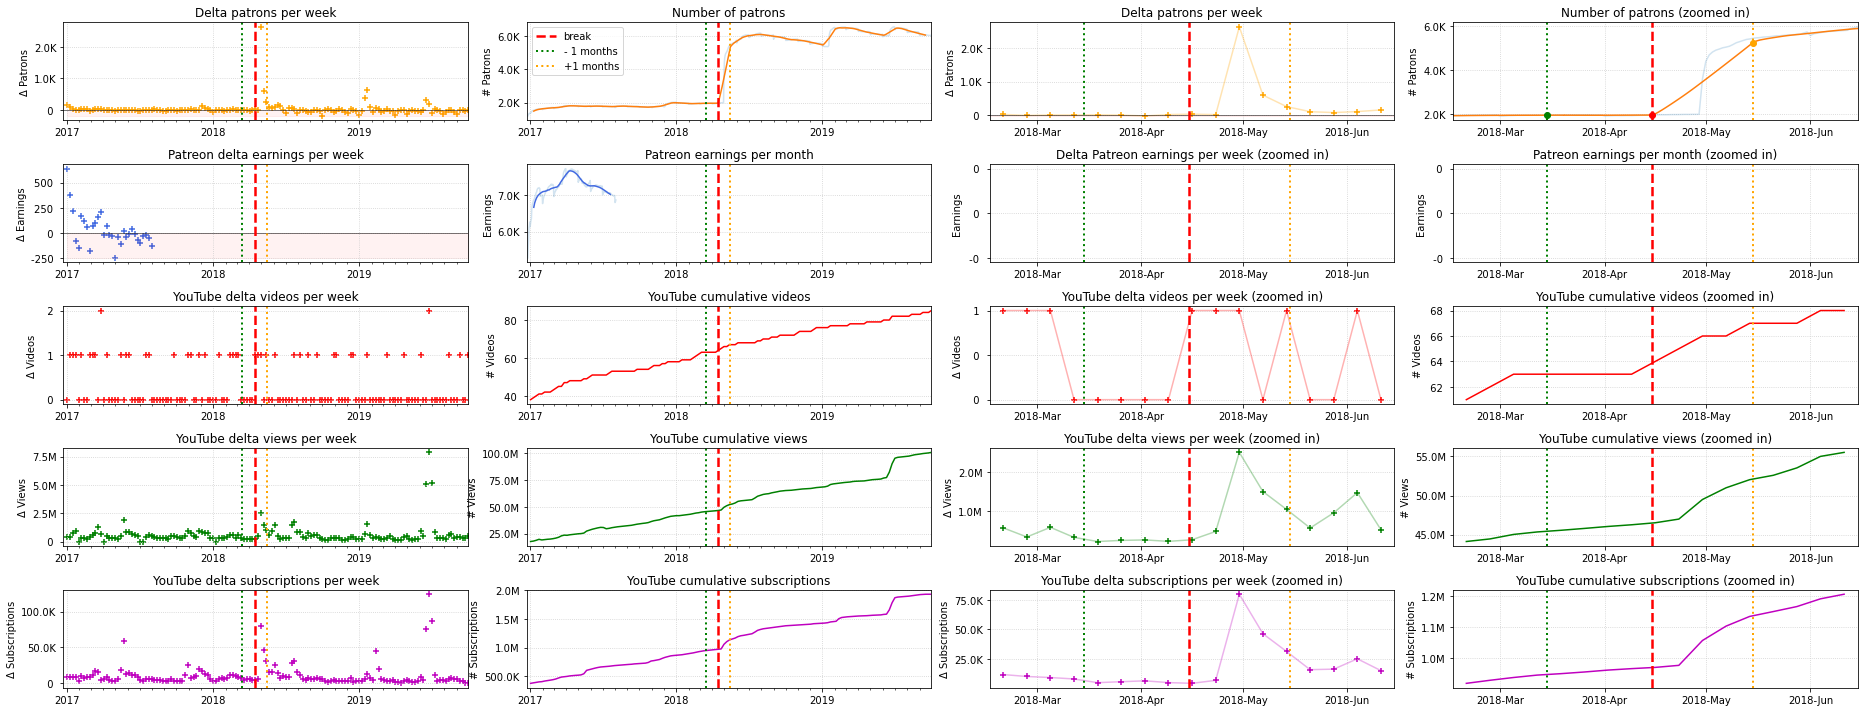




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 2: thecompletionist 
https://www.patreon.com/thecompletionist
https://graphtreon.com/creator/thecompletionist
https://youtube.com/channel/UCPYJR2EIu0_MJaDeSGwkIVw

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-06-17): 262.6
• At breakpoint          (2017-07-17): 264.3
• At breakpoint + 30days (2017-08-17): 846.3

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-06-17 to 2017-07-17:        d1  =   +1.7 patrons
• Increase of patrons from 2017-07-17 to 2017-08-17:        d2  = +582.0 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 349.18
• Percentage increase:                            |d2/d1|*100  = +34918%

Granger Causality Tests:
• pt_delta_

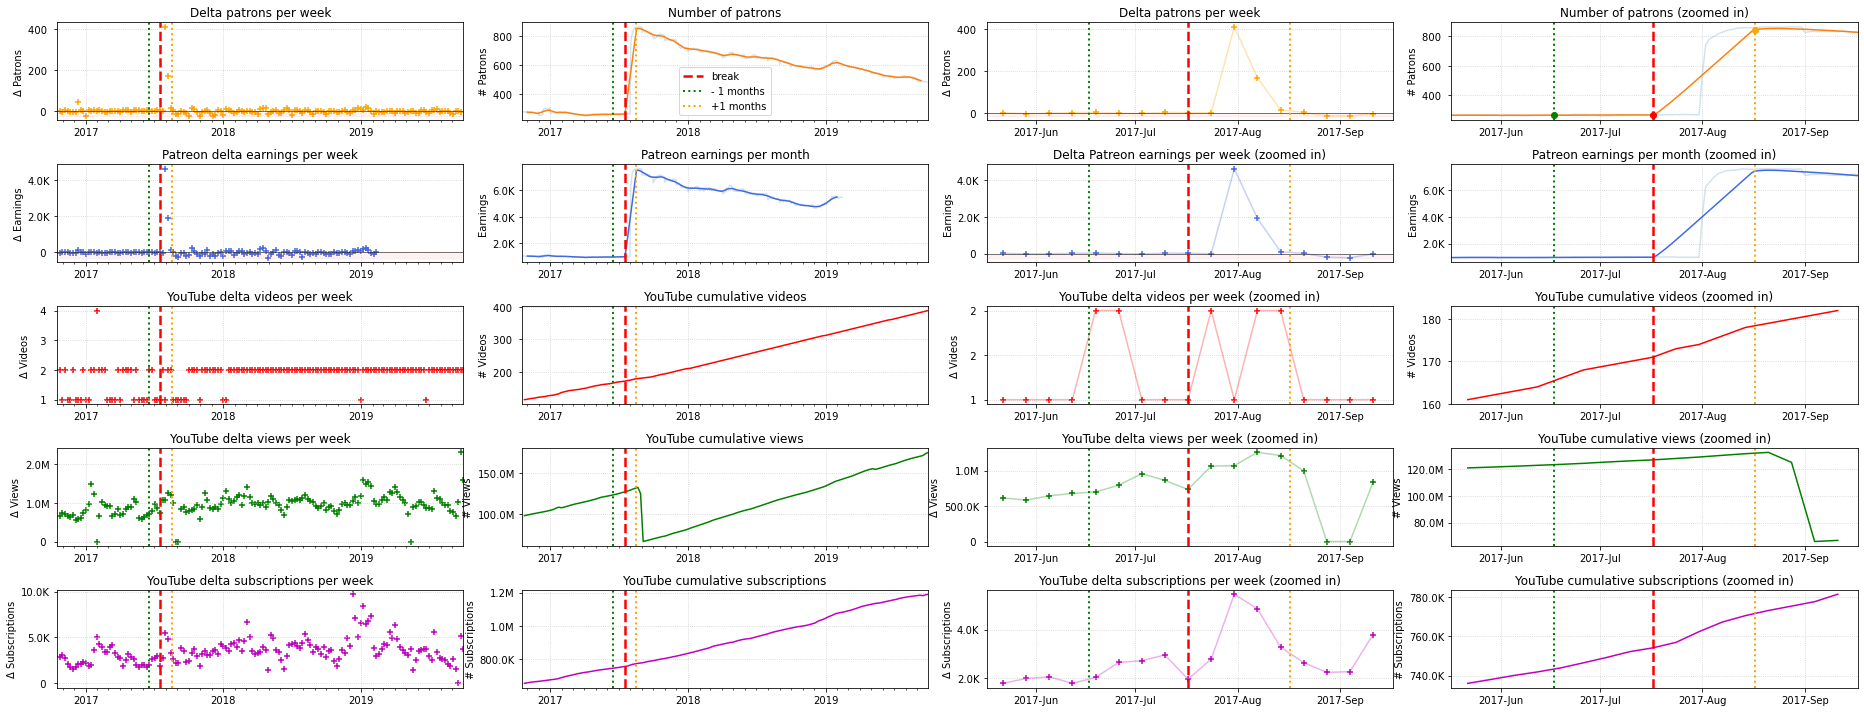




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 3: billwurtz 
https://www.patreon.com/billwurtz
https://graphtreon.com/creator/billwurtz
https://youtube.com/channel/UCq6aw03lNILzV96UvEAASfQ

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-03-25): 111.8
• At breakpoint          (2017-04-25): 113.5
• At breakpoint + 30days (2017-05-25): 650.6

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-03-25 to 2017-04-25:        d1  =   +1.7 patrons
• Increase of patrons from 2017-04-25 to 2017-05-25:        d2  = +537.2 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 315.98
• Percentage increase:                            |d2/d1|*100  = +31598%

Granger Causality Tests:
• pt_delta_patrons --> yt_delta_

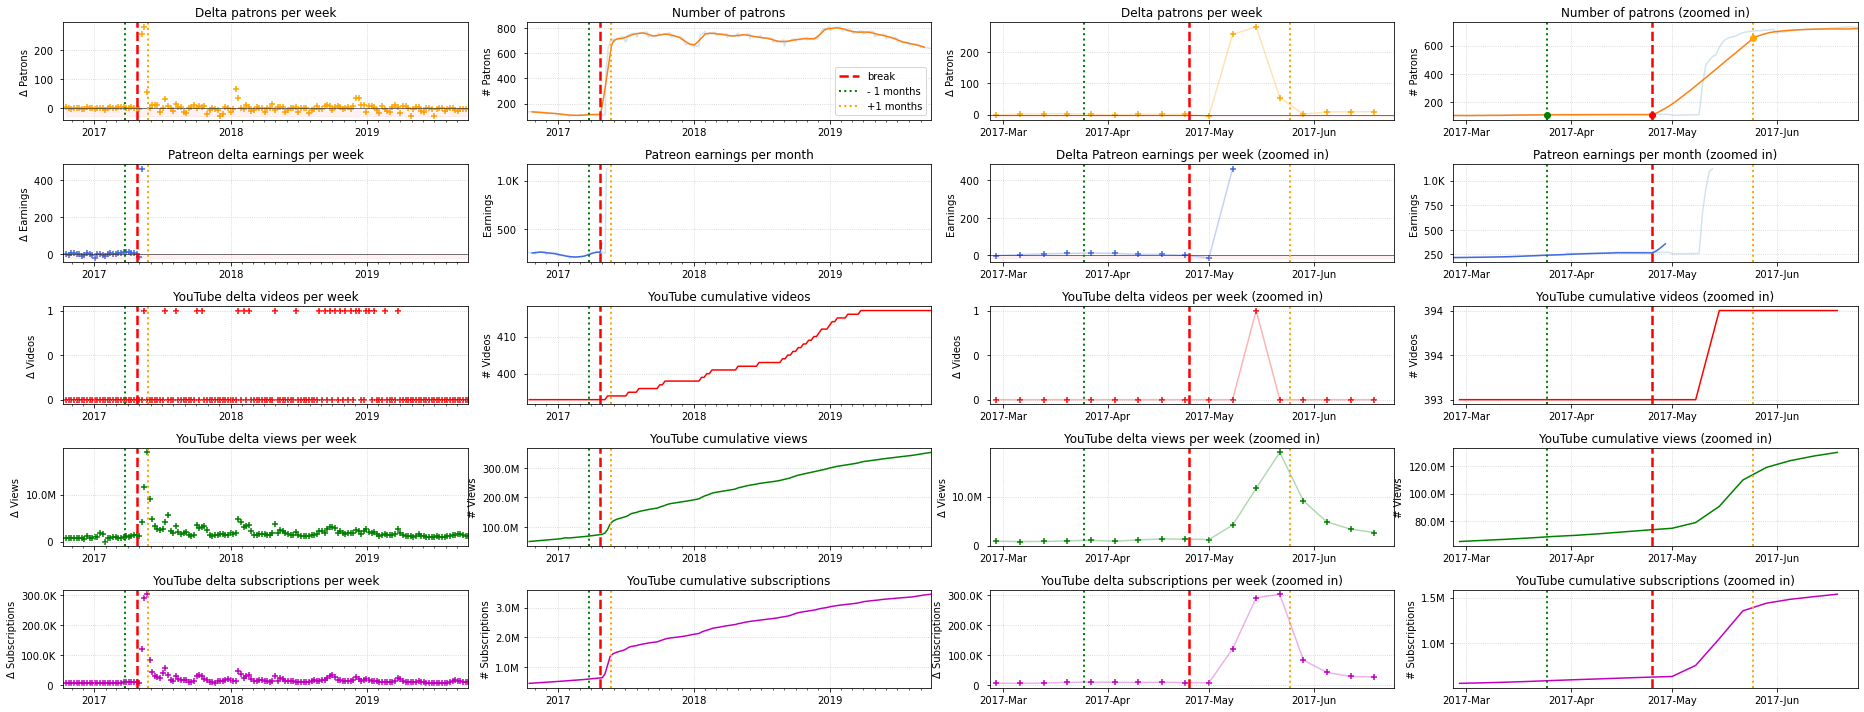




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 4: chadtronic 
https://www.patreon.com/chadtronic
https://graphtreon.com/creator/chadtronic
https://youtube.com/channel/UCcK72Xs5DAM3mnGpyImg63Q

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-03-20): 19.8
• At breakpoint          (2017-04-20): 20.1
• At breakpoint + 30days (2017-05-20): 224.5

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-03-20 to 2017-04-20:        d1  =   +1.0 patrons
• Increase of patrons from 2017-04-20 to 2017-05-20:        d2  = +204.4 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 204.43
• Percentage increase:                            |d2/d1|*100  = +20443%

Granger Causality Tests:
• yt_delta_videos --> pt_delta_

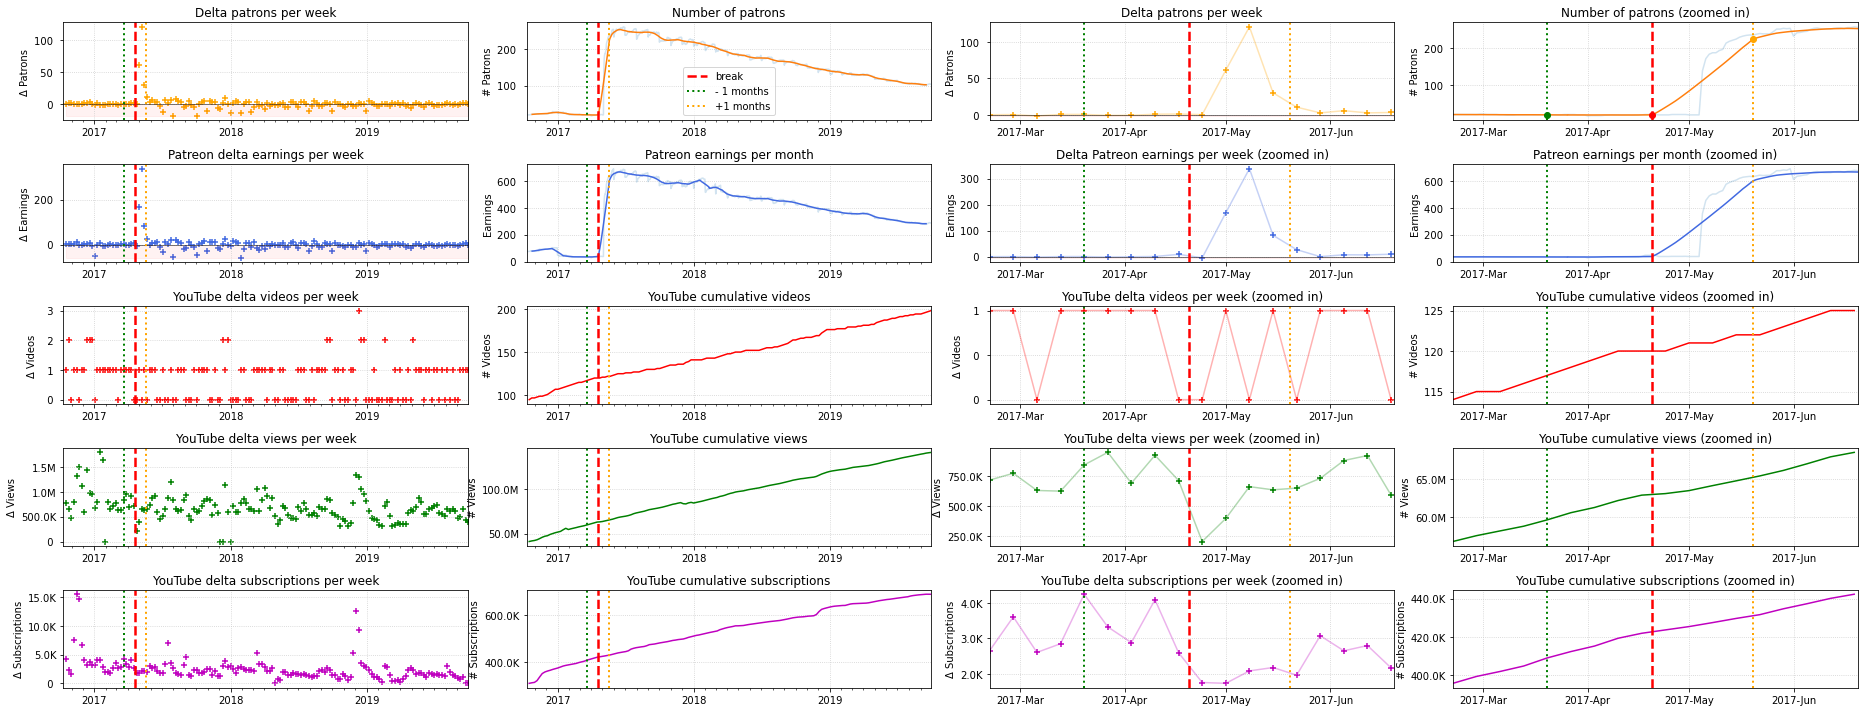




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 5: comicstorian 
https://www.patreon.com/comicstorian
https://graphtreon.com/creator/comicstorian
https://youtube.com/channel/UCmA-0j6DRVQWo4skl8Otkiw

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-12-02): 5.0
• At breakpoint          (2018-01-02): 5.8
• At breakpoint + 30days (2018-02-02): 178.1

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-12-02 to 2018-01-02:        d1  =   +1.0 patrons
• Increase of patrons from 2018-01-02 to 2018-02-02:        d2  = +172.3 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 172.33
• Percentage increase:                            |d2/d1|*100  = +17233%

Granger Causality Tests:
• pt_delta_patrons --> yt_d

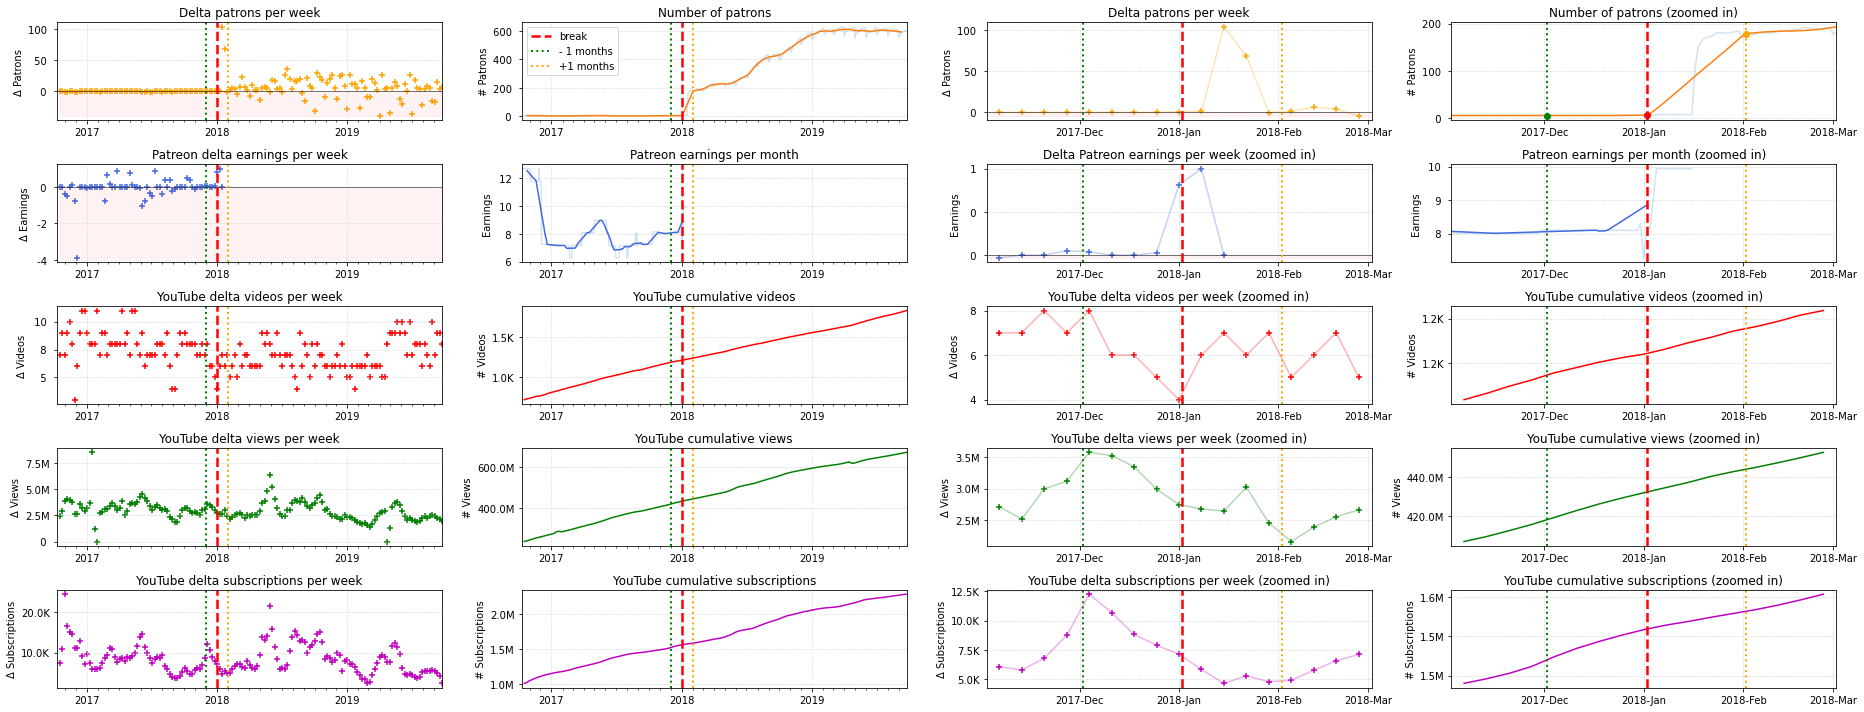




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 6: davidpakmanshow 
https://www.patreon.com/davidpakmanshow
https://graphtreon.com/creator/davidpakmanshow
https://youtube.com/channel/UCvixJtaXuNdMPUGdOPcY8Ag

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-02-21): 34.0
• At breakpoint          (2017-03-21): 44.6
• At breakpoint + 30days (2017-04-21): 1,354.8

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-02-21 to 2017-03-21:        d1  =  +10.6 patrons
• Increase of patrons from 2017-03-21 to 2017-04-21:        d2  = +1310.1 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 123.60
• Percentage increase:                            |d2/d1|*100  = +12360%

Granger Causality Tests:
• pt_delta_pa

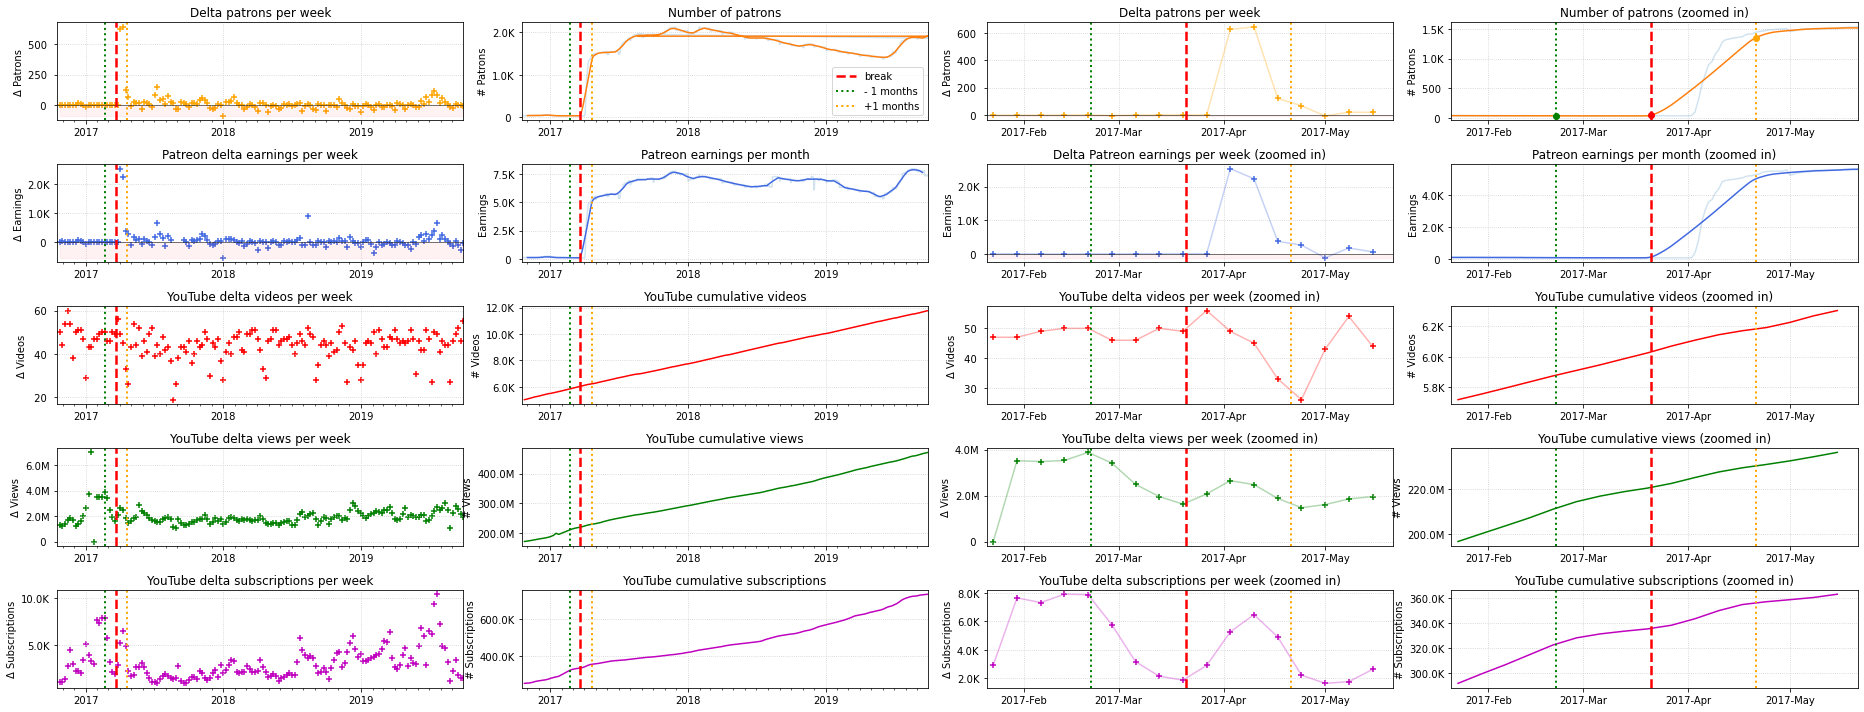




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 7: manyatruenerd 
https://www.patreon.com/manyatruenerd
https://graphtreon.com/creator/manyatruenerd
https://youtube.com/channel/UCDYZxJE8kLZ-o6nL8E1bXdQ

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2016-12-19): 1,442.4
• At breakpoint          (2017-01-19): 1,446.8
• At breakpoint + 30days (2017-02-19): 1,969.5

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2016-12-19 to 2017-01-19:        d1  =   +4.4 patrons
• Increase of patrons from 2017-01-19 to 2017-02-19:        d2  = +522.7 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 118.79
• Percentage increase:                            |d2/d1|*100  = +11879%

Granger Causality Tests:
• yt_delta_vie

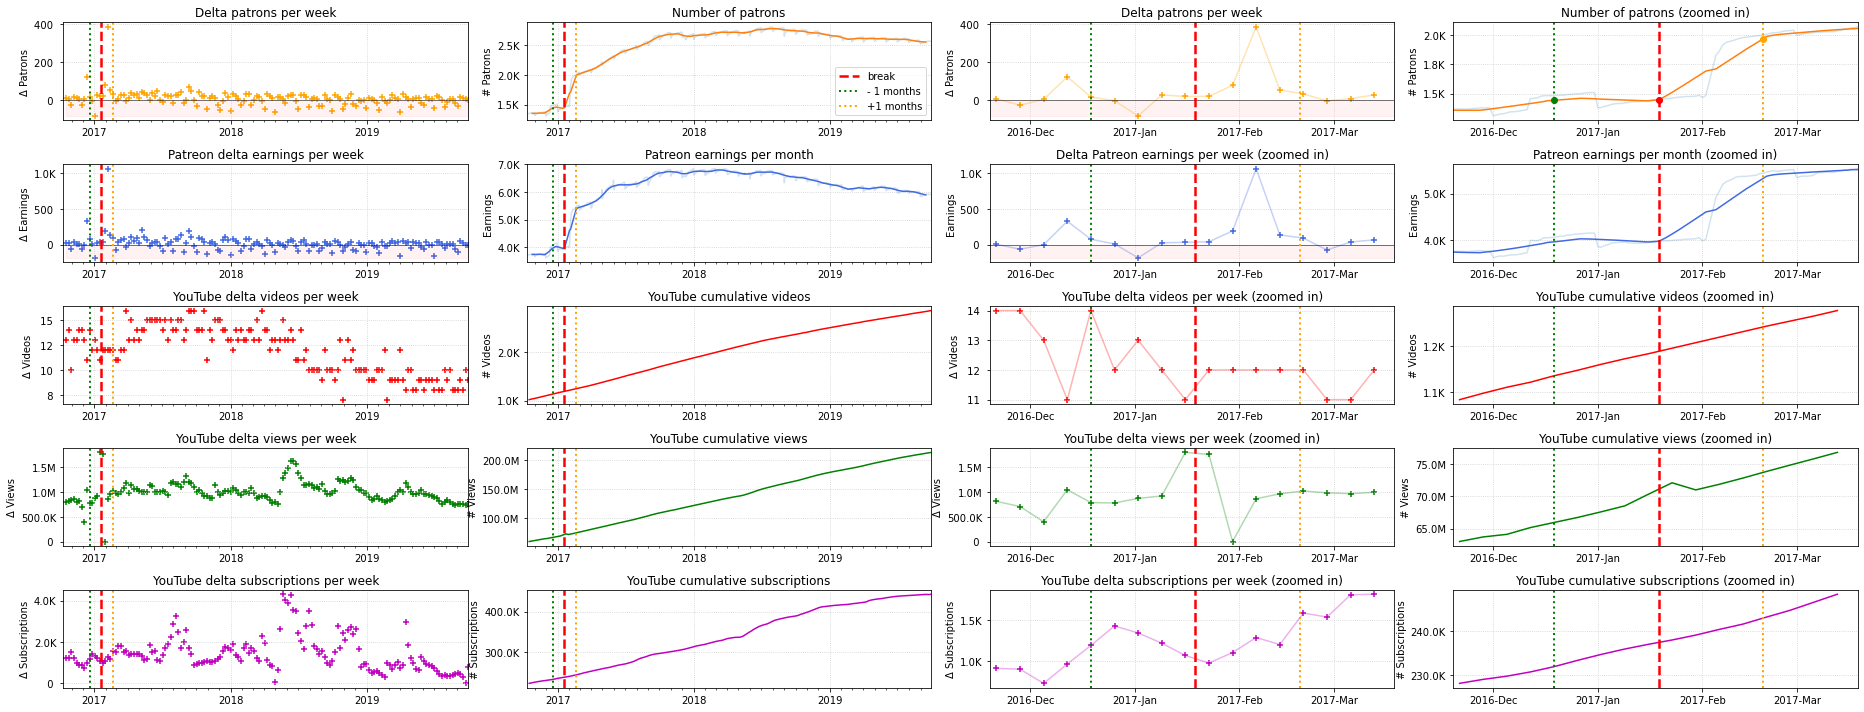




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 8: jelloapocalypse 
https://www.patreon.com/jelloapocalypse
https://graphtreon.com/creator/jelloapocalypse
https://youtube.com/channel/UCP4nS6ag1-E6TzlQvaWfiZg

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2019-04-04): 509.7
• At breakpoint          (2019-05-04): 512.6
• At breakpoint + 30days (2019-06-04): 812.7

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2019-04-04 to 2019-05-04:        d1  =   +2.9 patrons
• Increase of patrons from 2019-05-04 to 2019-06-04:        d2  = +300.1 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 104.70
• Percentage increase:                            |d2/d1|*100  = +10470%

Granger Causality Tests:
• No Granger c

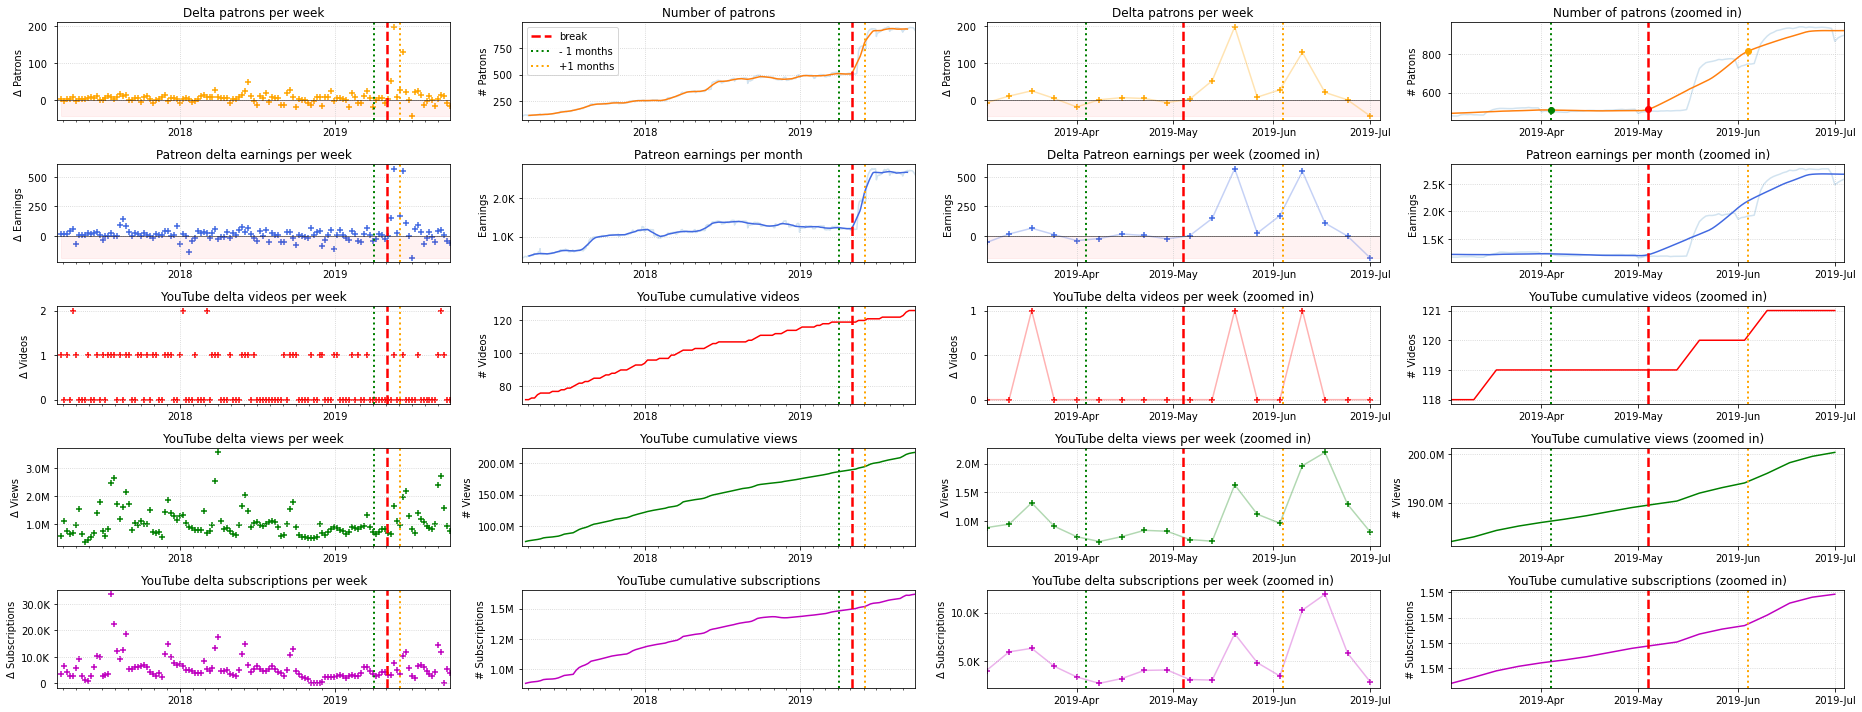




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 9: arhybes 
https://www.patreon.com/arhybes
https://graphtreon.com/creator/arhybes
https://youtube.com/channel/UCby5ZKyxiSW3dz_Kg5VDU9w

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2018-02-18): 263.9
• At breakpoint          (2018-03-18): 265.5
• At breakpoint + 30days (2018-04-18): 431.6

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2018-02-18 to 2018-03-18:        d1  =   +1.6 patrons
• Increase of patrons from 2018-03-18 to 2018-04-18:        d2  = +166.1 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 103.81
• Percentage increase:                            |d2/d1|*100  = +10381%

Granger Causality Tests:
• pt_delta_patrons --> yt_delta_views 

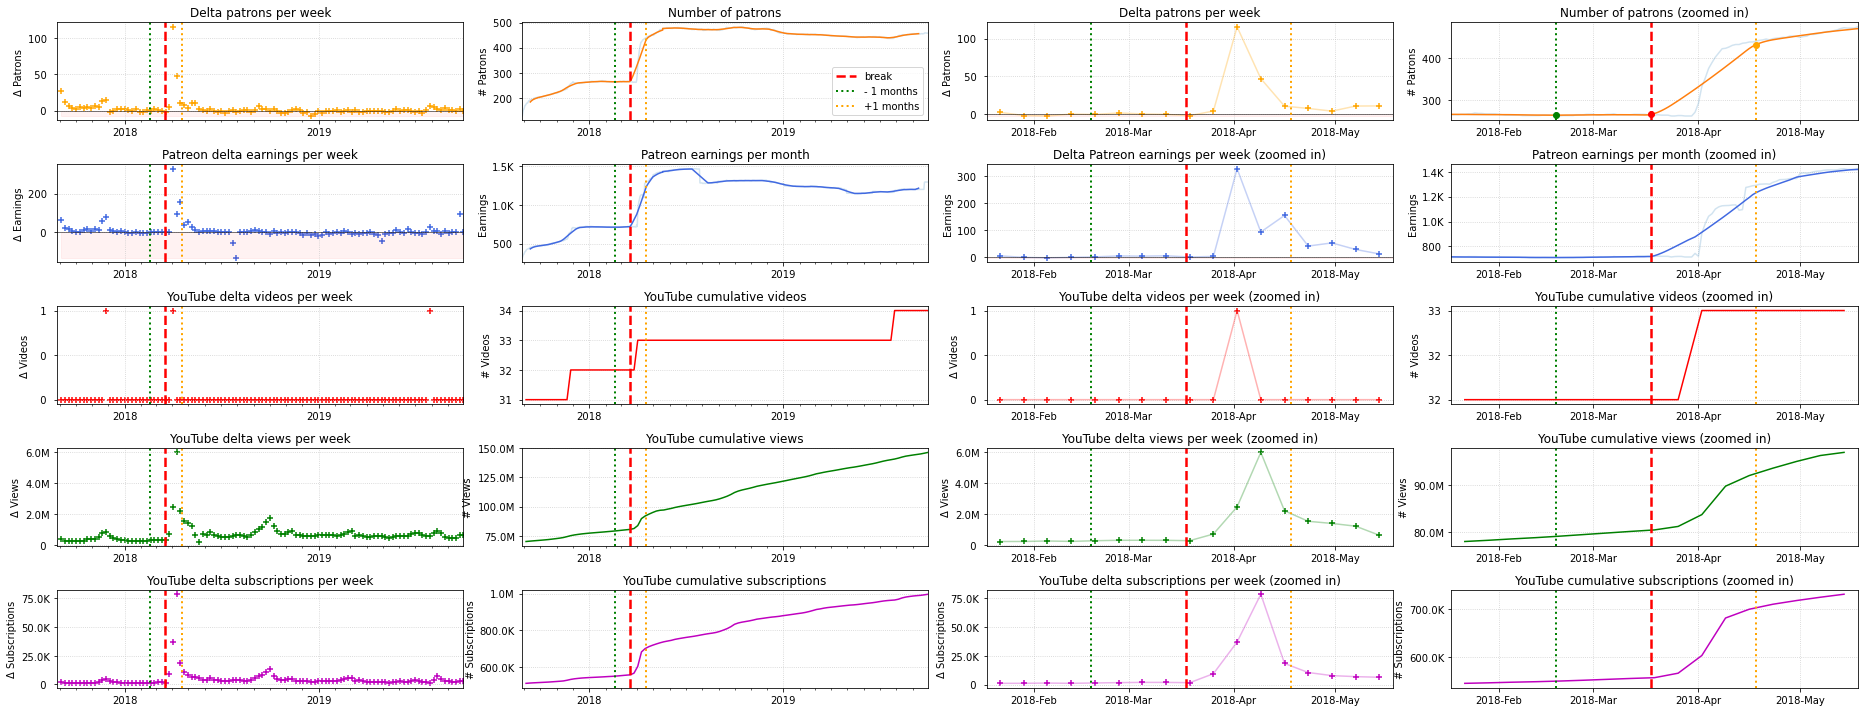




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 10: deeplook 
https://www.patreon.com/deeplook
https://graphtreon.com/creator/deeplook
https://youtube.com/channel/UC-3SbfTPJsL8fJAPKiVqBLg

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2018-03-30): 2.1
• At breakpoint          (2018-04-30): 2.2
• At breakpoint + 30days (2018-05-30): 98.5

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2018-03-30 to 2018-04-30:        d1  =   +1.0 patrons
• Increase of patrons from 2018-04-30 to 2018-05-30:        d2  =  +96.3 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 96.33
• Percentage increase:                            |d2/d1|*100  = +9633%

Granger Causality Tests:
• No Granger causality found for this acc

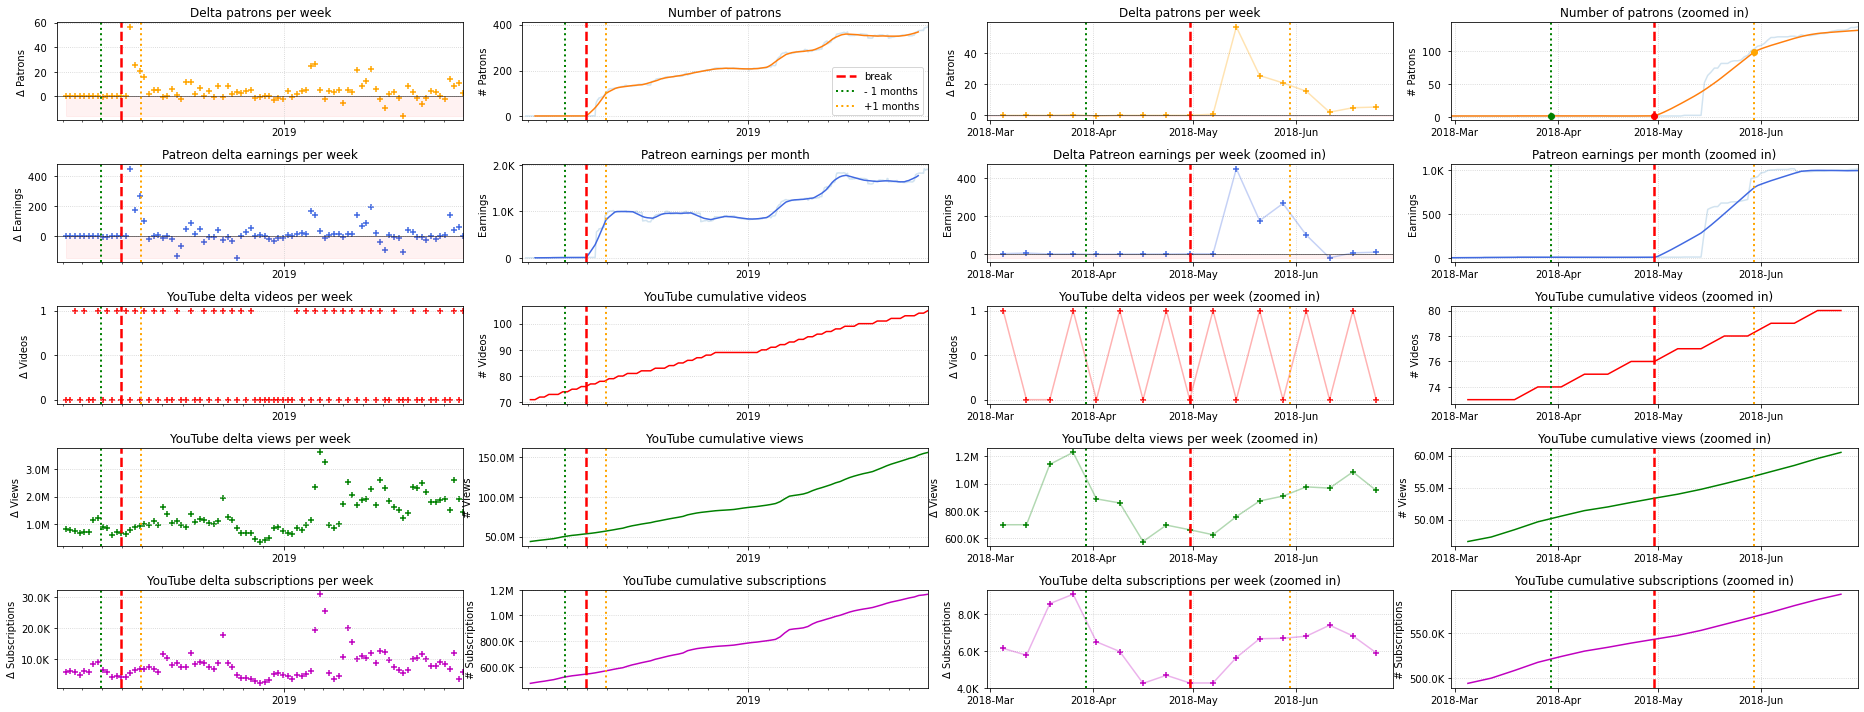




---------------------------------------------------------------------------------------------------------------------------------------------------


In [86]:
# compare YouTube and Patreon timeseries for top patreon accounts with rolling average - MANUAL VERSION 2
month_offset = pd.DateOffset(months=1)
week_offset = pd.DateOffset(weeks=1)
rolling_avg_window = 30

# variables for Granger Tests
MAXLAG = 2
granger_dict = {} # dictionary with  keys (cause --> effect) and values with list of corresponding patreon account(s)
not_granger = []
YT_variables = ['yt_delta_videos', 'yt_delta_views', 'yt_delta_subs']
# PT_variables = ['pt_delta_patrons', 'pt_delta_earning']
PT_variables = ['pt_delta_patrons']

df_granger = df_pt_bkpnt_filt.copy()

# LOOP OVER TOP PATREON ACCOUNTS
for idx, row in df_granger[:10].iterrows():
    fig, axs = plt.subplots(5, 4, figsize=(26, 10), sharey=False, sharex=False)
    
    
    patreon = row['patreon_id']
    ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

    # patreon earnings and users
    tmp_df_pt = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon].copy()  
    
    # youtube videos
    tmp_df_yt = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon].copy()
    
    # replace dates that were collected after 23:00 to their next day, and remove hour
    tmp_df_yt['datetime_original'] = tmp_df_yt['datetime']
    tmp_df_yt['datetime'] = tmp_df_yt['datetime'].apply(lambda date: (date + pd.DateOffset(days=1)) if date.hour >= 23 else date) 
    
    # remove hours and convert to datetime type
    tmp_df_yt['datetime'] = pd.to_datetime(tmp_df_yt['datetime'].dt.date)
    
    ########################## PRINT TITLES ##########################
    
    # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
    ch_ids = tmp_df_yt['channel'].unique()
    print(f"\n\n\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")
    print(f"https://www.{patreon}")
    print(f"https://graphtreon.com/creator/{patreon[12:]}")
    for ch_id in ch_ids:
        print(f"https://youtube.com/channel/{ch_id}")

    
    ########################## RESTRICT DATES FOR ZOOM OUT ##########################
    
    # set min and max dates for plots   
    date_min = max([tmp_df_yt['datetime'].min(), tmp_df_pt['date'].min()])
    date_max = min([tmp_df_yt['datetime'].max(), tmp_df_pt['date'].max()])
    
    if date_max < date_min:
        print(f":( no overlapping period between YouTube and Patreon datasets\n")
        continue
    
    # restrict datasets between min and max dates
    tmp_df_pt = tmp_df_pt[(tmp_df_pt['date'] >= date_min) & (tmp_df_pt['date'] <= date_max)]
    tmp_df_yt = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min) & (tmp_df_yt['datetime'] <= date_max)]
    
    # align both dataframes since youtube starts once a week
    tmp_df_pt = tmp_df_pt[tmp_df_pt['date'] >= tmp_df_yt['datetime'].min()]
    
    
    
    ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
    tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(rolling_avg_window, center=True).mean()
    tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(rolling_avg_window, center=True).mean()
    ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
    # resample time series to get 7 days intervals in order to calculate weekly deltas
    ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
    ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
    ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
    tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
    # reorder columns to have deltas columns next to their respective columns
    patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
    # convert Float64 columns to float64 to avoid Matplotlib NAType error
    ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
              
    ########################## DETECT BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

    breakpoint_date = row['bkpt_date']
    # breakpoint_date = find_breakpoint_v2(tmp_df_pt, 'patrons_ma')
    # print("Breakpoint date: ", breakpoint_date.date())

    # check that dates prior and after breakpoint exist
    if not (((breakpoint_date - 1*month_offset)) in ts_pt_df.index and ((breakpoint_date + 1*month_offset) in ts_pt_df.index)):
        print(f"ERROR: Breakpoint too close to edge of patreon time series or missing data\n")
        plt.figure().clear(); plt.close(); plt.cla(); plt.clf(); plt.show()
        continue
    
    
    ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

    avg_patrons_bkpnt = row['avg_patrons_bkpnt']
    avg_patrons_sub30 = row['avg_patrons_sub30']
    avg_patrons_add30 = row['avg_patrons_add30']
    
    bkpt_date       = row['bkpt_date']
    bkpt_date_sub30 = row['bkpt_date_sub30']
    bkpt_date_add30 = row['bkpt_date_add30']
    
    d1 = row['d1']
    d2 = row['d2']

    
    r = row['ratio']

    print(f'\nAverage number of patrons: (values calculated using a 30 days centered moving average)')
    print(f'• At breakpoint - 30days ({bkpt_date_sub30.date()}): {avg_patrons_sub30:,.1f}')
    print(f'• At breakpoint          ({bkpt_date.date()}): {avg_patrons_bkpnt:,.1f}')
    print(f'• At breakpoint + 30days ({bkpt_date_add30.date()}): {avg_patrons_add30:,.1f}')
    
    print(f'\nIncrease of patrons in the period before and after the breakpoint:')
    print(f"• Increase of patrons from {bkpt_date_sub30.date()} to {bkpt_date.date()}:        d1  = {d1:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date.date()} to {bkpt_date_add30.date()}:        d2  = {d2:>+6.1f} patrons")
    
    print(f'\nRatio of the increases of the 2 periods: ')
    print(f"• Ratio between 2 increases:                            d2/d1  = {r:.2f}")
    print(f"• Percentage increase:                            |d2/d1|*100  = {abs(r):>+.0%}")
    
    
    

    ################################### ZOOM OUT PLOTS ###################################
    
    # number of patrons (delta)
    axs[0,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,0].set(title="Delta patrons per week")
    axs[0,0].set_ylabel("Δ Patrons")    
    color_neg_pos(axs[0,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'])

    # number of patrons (cumulative)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons'], alpha=0.2)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons_ma'])
    axs[0,1].set(title="Number of patrons")
    axs[0,1].set_ylabel("# Patrons")

    # patreon earnings (delta)
    axs[1,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,0].set(title="Patreon delta earnings per week")
    axs[1,0].set_ylabel("Δ Earnings") 
    color_neg_pos(axs[1,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'])

    # patreon earnings (cumulative)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning'], alpha=0.2)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning_ma'], color='royalblue')
    axs[1,1].set(title="Patreon earnings per month")
    axs[1,1].set_ylabel("Earnings")
    
    # youtube videos (delta)
    axs[2,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_videos'], c='r', s=30, marker='+')
    axs[2,0].set(title="YouTube delta videos per week")
    axs[2,0].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,0], tmp_df_yt['datetime'], tmp_df_yt['delta_videos'])

    # youtube videos (cumulative)
    axs[2,1].plot(tmp_df_yt['datetime'], tmp_df_yt['videos'], 'r')
    axs[2,1].set(title="YouTube cumulative videos")
    axs[2,1].set_ylabel("# Videos")

    # youtube views (delta)
    axs[3,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_views'], c='g', s=30, marker='+')
    axs[3,0].set(title="YouTube delta views per week")
    axs[3,0].set_ylabel("Δ Views")
    color_neg_pos(axs[3,0], tmp_df_yt['datetime'], tmp_df_yt['delta_views'])

    # youtube views (cumulative)
    axs[3,1].plot(tmp_df_yt['datetime'], tmp_df_yt['views'], 'g')
    axs[3,1].set(title="YouTube cumulative views")
    axs[3,1].set_ylabel("# Views")

    # youtube subs (delta)
    axs[4,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_subs'], c='m', s=30, marker='+')
    axs[4,0].set(title="YouTube delta subscriptions per week")
    axs[4,0].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,0], tmp_df_yt['datetime'], tmp_df_yt['delta_subs'])

    # youtube subs (cumulative)
    axs[4,1].plot(tmp_df_yt['datetime'], tmp_df_yt['subs'], 'm')
    axs[4,1].set(title="YouTube cumulative subscriptions")
    axs[4,1].set_ylabel("# Subscriptions")
    
        

    ########################## RESTRICT DATES FOR ZOOM IN (+/- 2 months around breakpoint) ##########################

    # calculate min and max dates for zoom
    date_min_zoom = breakpoint_date - (2 * month_offset)
    date_max_zoom = breakpoint_date + (2 * month_offset)
            
    # restrict datasets between min and max dates
    tmp_df_pt_zoomed = tmp_df_pt[(tmp_df_pt['date'] >= date_min_zoom) & (tmp_df_pt['date'] <= date_max_zoom)].copy()
    tmp_df_yt_zoomed = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min_zoom) & (tmp_df_yt['datetime'] <= date_max_zoom)].copy()

    # used for coloration
    ts_pt_weekly_avg_df_zoomed = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= date_min_zoom) & (ts_pt_weekly_avg_df_float64.index <= date_max_zoom)]
    
    
   ################################### ZOOM IN PLOTS  ###################################

    # zoomed in patron numbers (delta)
    axs[0,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', alpha=0.3)
    axs[0,2].set(title="Delta patrons per week")
    axs[0,2].set_ylabel("Δ Patrons")
    color_neg_pos(axs[0,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'])
    
    # zoomed in patron numbers (cumulative)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons'], alpha=0.2)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons_ma'])
    axs[0,3].set(title="Number of patrons (zoomed in)")
    axs[0,3].set_ylabel("# Patrons")
    
    # zoomed in patron earnings (delta)
    axs[1,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', alpha=0.3)
    axs[1,2].set(title="Delta Patreon earnings per week (zoomed in)")
    axs[1,2].set_ylabel("Earnings")  
    color_neg_pos(axs[1,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_earning'])

    # zoomed in patron earnings (cumulative)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning'], alpha=0.2)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning_ma'], color='royalblue')
    axs[1,3].set(title="Patreon earnings per month (zoomed in)")
    axs[1,3].set_ylabel("Earnings")
    
    # zoomed in youtube videos (delta)
    axs[2,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', s=30, marker='+')
    axs[2,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', alpha=0.3)
    axs[2,2].set(title="YouTube delta videos per week (zoomed in)")
    axs[2,2].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_videos'])

    # zoomed in youtube videos (cumulative)
    axs[2,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['videos'], 'r')
    axs[2,3].set(title="YouTube cumulative videos (zoomed in)")
    axs[2,3].set_ylabel("# Videos")

    # zoomed in youtube views (delta)
    axs[3,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', s=30, marker='+')
    axs[3,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', alpha=0.3)
    axs[3,2].set(title="YouTube delta views per week (zoomed in)")
    axs[3,2].set_ylabel("Δ Views")
    color_neg_pos(axs[3,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_views'])

    # zoomed in youtube views (cumulative)
    axs[3,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['views'], 'g')
    axs[3,3].set(title="YouTube cumulative views (zoomed in)")
    axs[3,3].set_ylabel("# Views")
    
    # zoomed in youtube subs (delta)
    axs[4,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', s=30, marker='+')
    axs[4,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', alpha=0.3)
    axs[4,2].set(title="YouTube delta subscriptions per week (zoomed in)")
    axs[4,2].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_subs'])

    # zoomed in youtube subs (cumulative)
    axs[4,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['subs'], 'm')
    axs[4,3].set(title="YouTube cumulative subscriptions (zoomed in)")
    axs[4,3].set_ylabel("# Subscriptions")
    
    
    ################################### FORMAT AXES ###################################

    # format the axes
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if j < 2:
                axs[i,j].set_xlim([date_min, date_max])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].xaxis.set_major_locator(mdates.YearLocator())
                axs[i,j].xaxis.set_minor_locator(mdates.MonthLocator())
            if j >= 2:
                axs[i,j].set_xlim([date_min_zoom, date_max_zoom])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                axs[i,j].xaxis.set_major_locator(mdates.MonthLocator())
                # axs[i,j].xaxis.set_minor_locator(mdates.WeekdayLocator())
            axs[i,j].xaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.set_major_formatter(KM_formatter)
            
            
    ################################### PLOT BREAKPOINT LINES AND POINTS ###################################

    # plot vertical lines for breakpoint, breakpoint-1month, breakpoint+1month
    print_legend = True
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if print_legend:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', label='break', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - month_offset, color='green', linestyle=':', label='- ' + str(month_offset.months)+' months', linewidth=2)
                axs[i,j].axvline(breakpoint_date + month_offset, color='orange', linestyle=':', label='+' + str(month_offset.months)+' months', linewidth=2)          
                # print_legend = False
            else:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - month_offset, color='green', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + month_offset, color='orange', linestyle=':', linewidth=2)
    # axs[0,0].legend()
    axs[0,1].legend()

    # plot point for mean nb of patrons for breakpoint, breakpoint-1month, breakpoint+1month    
    axs[0,3].plot(breakpoint_date - month_offset, ts_pt_df.at[(breakpoint_date - month_offset), 'patrons_ma'], marker='o', color='green')
    axs[0,3].plot(breakpoint_date,               ts_pt_df.at[breakpoint_date              , 'patrons_ma'], marker='o', color='red')    
    axs[0,3].plot(breakpoint_date + month_offset, ts_pt_df.at[(breakpoint_date + month_offset), 'patrons_ma'], marker='o', color='orange')    


    ################################### GRANGER CAUSALITY TESTS ###################################

    # create a new dataframe with merged columns (the dates might have a day difference)
    selected_pt_columns  = ['delta_earning', 'delta_patrons']
    df_pt = ts_pt_weekly_avg_df_zoomed
    df_pt = df_pt[selected_pt_columns].reset_index().add_prefix('pt_')

    # selected_yt_columns = ['datetime', 'delta_views', 'delta_subs', 'delta_videos']
    selected_yt_columns = ['datetime', 'datetime_original', 'delta_views', 'delta_subs', 'delta_videos']
    df_yt = tmp_df_yt_zoomed
    df_yt = df_yt[selected_yt_columns].reset_index().add_prefix('yt_')

    # concatenated 2 dfs and select and reorder columns
    df_concat = pd.concat([df_pt, df_yt], axis=1)
    concat_columns = ['pt_date', 'yt_datetime', 'pt_delta_earning', 'pt_delta_patrons', 'yt_delta_views', 'yt_delta_subs', 'yt_delta_videos']
    df_concat = df_concat[concat_columns]
    # df_concat['dates_match'] = df_concat['pt_date'] == df_concat['yt_datetime']
    
    # display(df_concat.round())
    # display(df_concat.style.set_caption(f"df_concat"))
    
    
    
    print(f"\nGranger Causality Tests:")
    
    granger_causal_link = False
    for pt_var in PT_variables:
        for yt_var in YT_variables:
            
            # if nan values in this df, skip
            if df_concat[[yt_var, pt_var]].isna().values.any():
                continue
                
            pvalue_fwd = {}
            pvalue_rev = {}
            
            try:
                # print(f'\n\n• {pt_var} --> {yt_var}')
                granger_test_fwd = grangercausalitytests(df_concat[[yt_var, pt_var]], maxlag=MAXLAG, verbose=False)  
                # print(f'\n\n• {yt_var} --> {pt_var}')
                granger_test_rev = grangercausalitytests(df_concat[[pt_var, yt_var]], maxlag=MAXLAG, verbose=False) 
            except Exception:
                continue


            for lag in range(1, MAXLAG+1):           
                pvalue_fwd[lag] = granger_test_fwd[lag][0]['ssr_ftest'][1]
                pvalue_rev[lag] = granger_test_rev[lag][0]['ssr_ftest'][1]
                
            
            
            
            min_pvalue_fwd = min(pvalue_fwd.values())
            if min_pvalue_fwd < 0.05:
                granger_causal_link = True
                min_lag_fwd = [k for k, v in pvalue_fwd.items() if v == min_pvalue_fwd][0]
                print(f'• {pt_var} --> {yt_var} (pvalue={min_pvalue_fwd:.3f}, lag={min_lag_fwd})')

                # add value to df
                df_granger.loc[idx, pt_var+'->'+yt_var] = 1

                if (pt_var, yt_var) in granger_dict:                   
                    granger_dict[(pt_var, yt_var)].append(patreon)
                else:
                    granger_dict[(pt_var, yt_var)] = [patreon]
            else: 
                df_granger.loc[idx, pt_var+'->'+yt_var] = 0
                
                
                
            min_pvalue_rev = min(pvalue_rev.values())
            if min_pvalue_rev < 0.05:
                granger_causal_link = True
                min_lag_rev = [k for k, v in pvalue_rev.items() if v == min_pvalue_rev][0]
                print(f'• {yt_var} --> {pt_var} (pvalue={min_pvalue_rev:.3f}, lag={min_lag_rev})')

                # add value to df
                df_granger.loc[idx, yt_var+'->'+pt_var] = 1
                
                if (yt_var, pt_var) in granger_dict:
                    granger_dict[(yt_var, pt_var)].append(patreon)
                else:
                    granger_dict[(yt_var, pt_var)] = [patreon]
            else: 
                df_granger.loc[idx, yt_var+'->'+pt_var] = 0
                

    if (granger_causal_link == False):
        print("• No Granger causality found for this account")
        not_granger.append(patreon)
    
    print("\n")

    fig.tight_layout(w_pad=0)
    plt.show()
    
    print('\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------')
    
# print('\n\nGranger tests summary statistics:')
    
# print(f'• Number of patreon accounts analysed (patrons increase ratio > {incr_thresh_ratio}): {len(df_granger)}')
# print(f'• Number of patreon with no Granger-causal link: {len(not_granger)} ({len(not_granger)/len(df_granger):.0%})')

# print(f'• Number of patreon accounts per Granger-causal link:')
# # Converting granger dict into list of tuples (in order to sort it), the 2nd value of the tuple being the count of accounts
# granger_list = [(k, len(v)) for k, v in granger_dict.items()]
# # sort by count desc
# granger_list_desc = sorted(granger_list, key=lambda tup: -tup[1])
# for (k,v) in granger_list_desc:
#     print(f'    • {k[0]} \t--> {k[1]}:\t {v} ({v/len(df_granger):.0%})')


# df_granger[columns] = df_granger[columns].astype('Int64')
# df_granger

##### Granger Tests statistics

In [87]:
# # compare YouTube and Patreon timeseries for top patreon accounts with rolling average - MANUAL VERSION 2
# month_offset = pd.DateOffset(months=1)
# week_offset = pd.DateOffset(weeks=1)
# rolling_avg_window = 30

# # variables for Granger Tests
# MAXLAG = 2
# granger_dict = {} # dictionary with  keys (cause --> effect) and values with list of corresponding patreon account(s)
# not_granger = []
# YT_variables = ['yt_delta_videos', 'yt_delta_views', 'yt_delta_subs']
# # PT_variables = ['pt_delta_patrons', 'pt_delta_earning']
# PT_variables = ['pt_delta_patrons']

# df_granger = df_pt_bkpnt_filt.copy()

# # LOOP OVER TOP PATREON ACCOUNTS
# for idx, row in tqdm(df_granger.iterrows()):   

    
#     ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

#     patreon = row['patreon_id']

#     # patreon earnings and users
#     tmp_df_pt = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon].copy()  
    
#     # youtube videos
#     tmp_df_yt = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon].copy()
    
#     # replace dates that were collected after 23:00 to their next day, and remove hour
#     tmp_df_yt['datetime_original'] = tmp_df_yt['datetime']
#     tmp_df_yt['datetime'] = tmp_df_yt['datetime'].apply(lambda date: (date + pd.DateOffset(days=1)) if date.hour >= 23 else date) 
    
#     # remove hours and convert to datetime type
#     tmp_df_yt['datetime'] = pd.to_datetime(tmp_df_yt['datetime'].dt.date)
    
#     ########################## PRINT TITLES ##########################
    
#     # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
#     # ch_ids = tmp_df_yt['channel'].unique()
#     # print(f"\n\n\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")
#     # print(f"https://www.{patreon}")
#     # print(f"https://graphtreon.com/creator/{patreon[12:]}")
#     # for ch_id in ch_ids:
#     #     print(f"https://youtube.com/channel/{ch_id}")

    
#     ########################## RESTRICT DATES FOR ZOOM OUT ##########################
    
#     # set min and max dates for plots   
#     date_min = max([tmp_df_yt['datetime'].min(), tmp_df_pt['date'].min()])
#     date_max = min([tmp_df_yt['datetime'].max(), tmp_df_pt['date'].max()])
    
#     if date_max < date_min:
#         print(f":( no overlapping period between YouTube and Patreon datasets\n")
#         continue
    
#     # restrict datasets between min and max dates
#     tmp_df_pt = tmp_df_pt[(tmp_df_pt['date'] >= date_min) & (tmp_df_pt['date'] <= date_max)]
#     tmp_df_yt = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min) & (tmp_df_yt['datetime'] <= date_max)]
    
#     # align both dataframes since youtube starts once a week
#     tmp_df_pt = tmp_df_pt[tmp_df_pt['date'] >= tmp_df_yt['datetime'].min()]
    
    
    
#     ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
#     tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(rolling_avg_window, center=True).mean()
#     tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(rolling_avg_window, center=True).mean()
#     ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
#     # resample time series to get 7 days intervals in order to calculate weekly deltas
#     ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
#     ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
#     ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
#     ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
#     tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
#     # reorder columns to have deltas columns next to their respective columns
#     patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
#     ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
#     # convert Float64 columns to float64 to avoid Matplotlib NAType error
#     ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
               
#     ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

#     breakpoint_date = row['bkpt_date']

#     avg_patrons_bkpnt = row['avg_patrons_bkpnt']
#     avg_patrons_sub30 = row['avg_patrons_sub30']
#     avg_patrons_add30 = row['avg_patrons_add30']
    
#     bkpt_date       = row['bkpt_date']
#     bkpt_date_sub30 = row['bkpt_date_sub30']
#     bkpt_date_add30 = row['bkpt_date_add30']
    
#     d1 = row['d1']
#     d2 = row['d2']

    
#     r = row['ratio']

# #     print(f'\nAverage number of patrons: (values calculated using a 30 days centered moving average)')
# #     print(f'• At breakpoint - 30days ({bkpt_date_sub30.date()}): {avg_patrons_sub30:,.1f}')
# #     print(f'• At breakpoint          ({bkpt_date.date()}): {avg_patrons_bkpnt:,.1f}')
# #     print(f'• At breakpoint + 30days ({bkpt_date_add30.date()}): {avg_patrons_add30:,.1f}')
    
# #     print(f'\nIncrease of patrons in the period before and after the breakpoint:')
# #     print(f"• Increase of patrons from {bkpt_date_sub30.date()} to {bkpt_date.date()}:        d1  = {d1:>+6.1f} patrons")
# #     print(f"• Increase of patrons from {bkpt_date.date()} to {bkpt_date_add30.date()}:        d2  = {d2:>+6.1f} patrons")
    
# #     print(f'\nRatio of the increases of the 2 periods: ')
# #     print(f"• Ratio between 2 increases:                            d2/d1  = {r:.2f}")
# #     print(f"• Percentage increase:                            |d2/d1|*100  = {abs(r):>+.0%}")
    


#     ########################## RESTRICT DATES FOR ZOOM IN (+/- 2 months around breakpoint) ##########################

#     # calculate min and max dates for zoom
#     date_min_zoom = breakpoint_date - (2 * month_offset)
#     date_max_zoom = breakpoint_date + (2 * month_offset)
            
#     # restrict datasets between min and max dates
#     tmp_df_pt_zoomed = tmp_df_pt[(tmp_df_pt['date'] >= date_min_zoom) & (tmp_df_pt['date'] <= date_max_zoom)].copy()
#     tmp_df_yt_zoomed = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min_zoom) & (tmp_df_yt['datetime'] <= date_max_zoom)].copy()

#     # used for coloration
#     ts_pt_weekly_avg_df_zoomed = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= date_min_zoom) & (ts_pt_weekly_avg_df_float64.index <= date_max_zoom)]
    


#     ################################### GRANGER CAUSALITY TESTS ###################################

#     # create a new dataframe with merged columns (the dates might have a day difference)
#     selected_pt_columns  = ['delta_earning', 'delta_patrons']
#     df_pt = ts_pt_weekly_avg_df_zoomed
#     df_pt = df_pt[selected_pt_columns].reset_index().add_prefix('pt_')

#     # selected_yt_columns = ['datetime', 'delta_views', 'delta_subs', 'delta_videos']
#     selected_yt_columns = ['datetime', 'datetime_original', 'delta_views', 'delta_subs', 'delta_videos']
#     df_yt = tmp_df_yt_zoomed
#     df_yt = df_yt[selected_yt_columns].reset_index().add_prefix('yt_')

#     # concatenated 2 dfs and select and reorder columns
#     df_concat = pd.concat([df_pt, df_yt], axis=1)
#     concat_columns = ['pt_date', 'yt_datetime', 'pt_delta_earning', 'pt_delta_patrons', 'yt_delta_views', 'yt_delta_subs', 'yt_delta_videos']
#     df_concat = df_concat[concat_columns]
#     # df_concat['dates_match'] = df_concat['pt_date'] == df_concat['yt_datetime']
    
#     # display(df_concat.round())
#     # display(df_concat.style.set_caption(f"df_concat"))
    
    
    
#     # print(f"\nGranger Causality Tests:")
    
#     granger_causal_link = False
#     for pt_var in PT_variables:
#         for yt_var in YT_variables:
            
#             # if nan values in this df, skip
#             if df_concat[[yt_var, pt_var]].isna().values.any():
#                 continue
                
#             pvalue_fwd = {}
#             pvalue_rev = {}
            
#             try:
#                 # print(f'\n\n• {pt_var} --> {yt_var}')
#                 granger_test_fwd = grangercausalitytests(df_concat[[yt_var, pt_var]], maxlag=MAXLAG, verbose=False)  
#                 # print(f'\n\n• {yt_var} --> {pt_var}')
#                 granger_test_rev = grangercausalitytests(df_concat[[pt_var, yt_var]], maxlag=MAXLAG, verbose=False) 
#             except Exception:
#                 continue


#             for lag in range(1, MAXLAG+1):           
#                 pvalue_fwd[lag] = granger_test_fwd[lag][0]['ssr_ftest'][1]
#                 pvalue_rev[lag] = granger_test_rev[lag][0]['ssr_ftest'][1]
                
            
            
            
#             min_pvalue_fwd = min(pvalue_fwd.values())
#             if min_pvalue_fwd < 0.05:
#                 granger_causal_link = True
#                 min_lag_fwd = [k for k, v in pvalue_fwd.items() if v == min_pvalue_fwd][0]
#                 # print(f'• {pt_var} --> {yt_var} (pvalue={min_pvalue_fwd:.3f}, lag={min_lag_fwd})')

#                 # add value to df
#                 df_granger.loc[idx, pt_var+'->'+yt_var] = 1

#                 if (pt_var, yt_var) in granger_dict:                   
#                     granger_dict[(pt_var, yt_var)].append(patreon)
#                 else:
#                     granger_dict[(pt_var, yt_var)] = [patreon]
#             else: 
#                 df_granger.loc[idx, pt_var+'->'+yt_var] = 0
                
                
                
#             min_pvalue_rev = min(pvalue_rev.values())
#             if min_pvalue_rev < 0.05:
#                 granger_causal_link = True
#                 min_lag_rev = [k for k, v in pvalue_rev.items() if v == min_pvalue_rev][0]
#                 # print(f'• {yt_var} --> {pt_var} (pvalue={min_pvalue_rev:.3f}, lag={min_lag_rev})')

#                 # add value to df
#                 df_granger.loc[idx, yt_var+'->'+pt_var] = 1
                
#                 if (yt_var, pt_var) in granger_dict:
#                     granger_dict[(yt_var, pt_var)].append(patreon)
#                 else:
#                     granger_dict[(yt_var, pt_var)] = [patreon]
#             else: 
#                 df_granger.loc[idx, yt_var+'->'+pt_var] = 0
                

#     if (granger_causal_link == False):
#         # print("• No Granger causality found for this account")
#         not_granger.append(patreon)
    
#     # print("\n")

#     # fig.tight_layout(w_pad=0)
#     # plt.show()
    
#     # print('\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------')
    
# print(F'\n\nGranger tests summary statistics: (with maxlag = {MAXLAG}')
    
# print(f'• Number of patreon accounts analysed (patrons increase ratio > {incr_thresh_ratio}): {len(df_granger)}')
# print(f'• Number of patreon with no Granger-causal link: {len(not_granger)} ({len(not_granger)/len(df_granger):.0%})')

# print(f'• Number of patreon accounts per Granger-causal link:')

# # Converting granger dict into list of tuples (in order to sort it), the 2nd value of the tuple being the count of accounts
# granger_list = [(k, len(v)) for k, v in granger_dict.items()]
# # sort by count desc
# granger_list_desc = sorted(granger_list, key=lambda tup: -tup[1])
# for (k,v) in granger_list_desc:
#     print(f'    • {k[0]} \t--> {k[1]}:\t {v} ({v/len(df_granger):.0%})')


# df_granger[columns] = df_granger[columns].astype('Int64')
# df_granger

In [88]:
# save "df_granger" dataframe to LOCAL SCRATCH FOLDER as a compressed tsv
# output_file_path = LOCAL_DATA_FOLDER+"df_granger.tsv.gz"
# df_granger.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

##### Granger causality plots

In [89]:
!ls -lh {LOCAL_DATA_FOLDER}df_granger.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 15K May 22 23:45 local_data/df_granger.tsv.gz


In [90]:
columns = [
'pt_delta_patrons->yt_delta_videos',
'pt_delta_patrons->yt_delta_views',
'pt_delta_patrons->yt_delta_subs',
'yt_delta_videos->pt_delta_patrons',
'yt_delta_views->pt_delta_patrons',
'yt_delta_subs->pt_delta_patrons'
]

In [91]:
df_granger = pd.read_csv(LOCAL_DATA_FOLDER+"df_granger.tsv.gz", sep="\t", compression='gzip')
df_granger['bkpt_date'] = pd.to_datetime(df_granger['bkpt_date'])
df_granger['bkpt_date_sub30'] = pd.to_datetime(df_granger['bkpt_date_sub30'])
df_granger['bkpt_date_add30'] = pd.to_datetime(df_granger['bkpt_date_add30'])
df_granger[columns] = df_granger[columns].astype('Int64')
df_granger.head()

,patreon_id,bkpt_date_sub30,avg_patrons_sub30,bkpt_date,avg_patrons_bkpnt,bkpt_date_add30,avg_patrons_add30,d1,d2,ratio,pt_delta_patrons->yt_delta_videos,yt_delta_videos->pt_delta_patrons,pt_delta_patrons->yt_delta_views,yt_delta_views->pt_delta_patrons,pt_delta_patrons->yt_delta_subs,yt_delta_subs->pt_delta_patrons
0,patreon.com/simonegiertz,2018-03-15,1954.633333,2018-04-15,1962.000000,2018-05-15,5249.966667,7.366667,3287.966667,446.330317,0,0,0,0,0,0
1,patreon.com/thecompletionist,2017-06-17,262.633333,2017-07-17,264.300000,2017-08-17,846.266667,1.666667,581.966667,349.180000,1,0,0,0,0,0
2,patreon.com/billwurtz,2017-03-25,111.766667,2017-04-25,113.466667,2017-05-25,650.633333,1.700000,537.166667,315.980392,1,1,1,0,1,0
3,patreon.com/chadtronic,2017-03-20,19.833333,2017-04-20,20.066667,2017-05-20,224.500000,1.000000,204.433333,204.433333,0,1,0,1,0,1
4,patreon.com/comicstorian,2017-12-02,5.000000,2018-01-02,5.800000,2018-02-02,178.133333,1.000000,172.333333,172.333333,0,0,1,0,0,0


In [92]:
# split columns in PT->YT, and reverse YT->PT
cols1 = [
'pt_delta_patrons->yt_delta_videos',
'pt_delta_patrons->yt_delta_views',
'pt_delta_patrons->yt_delta_subs'
]
cols2 = [
'yt_delta_videos->pt_delta_patrons',
'yt_delta_views->pt_delta_patrons',
'yt_delta_subs->pt_delta_patrons'
]

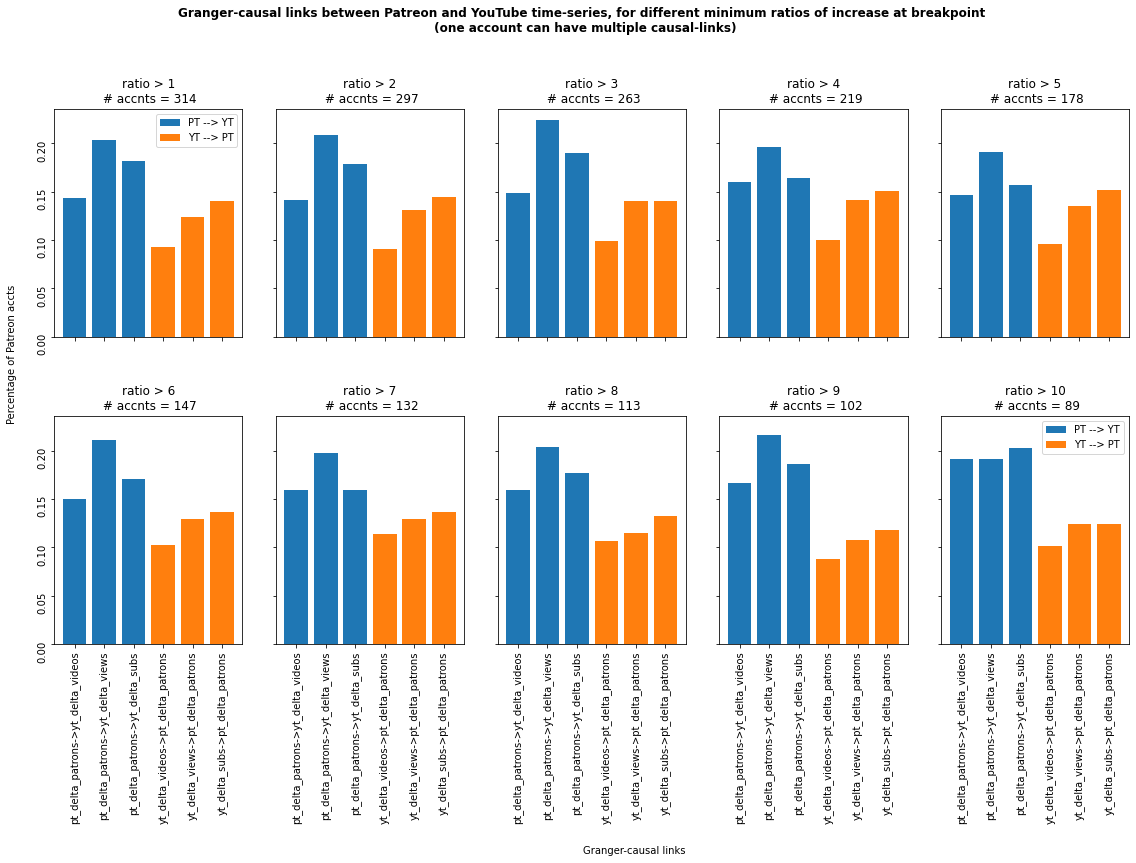

In [93]:
# For different minimum ratios of increase, plot sum of Granger-causal links between Patreon and YouTube time-series (in blue) and vice-versa (in orange)

nb_plots = 10
sbplt_cols = 5
sbplt_rows = int(nb_plots / sbplt_cols)

fig, axs = plt.subplots(sbplt_rows, sbplt_cols, figsize=(16,12), sharey=True, sharex=True)
for idx in range(0, nb_plots):

    row = math.floor(idx/sbplt_cols)
    col = idx % sbplt_cols
    sbplt = axs[row, col]
    
    ratio_df = df_granger[df_granger['ratio'] > idx+1]
    
    # print(f'\n\nratio > {idx+1}:')
    # print(f'total number of accounts: {len(ratio_df)}:')
    # no_causal_links_df = ratio_df[ratio_df[cols1 + cols2].sum(axis=1) == 0]
    # print(f'nb accts with no Granger-causal links: {len(no_causal_links_df)} ({len(no_causal_links_df)/len(ratio_df):.0%})')
    # print(f'\nPatreon --> YouTube:')
    # print(ratio_df[cols1].sum())
    # print(f'\nYouTube --> Patreon:')
    # print(ratio_df[cols2].sum())
    
    granger_series = ratio_df[cols1 + cols2].sum()/len(ratio_df)
    sbplt.bar(granger_series[cols1].index, granger_series[cols1].values, label='PT --> YT')
    sbplt.bar(granger_series[cols2].index, granger_series[cols2].values, label='YT --> PT')
    sbplt.set_title(f"ratio > {idx+1}\n # accnts = {len(ratio_df)}")
    # sbplt.set_xlabel("Granger-causal links")
    # sbplt.set_ylabel("% of PT accts")
    sbplt.tick_params(labelrotation=90)
    

axs[0, 0].legend()
axs[1, 4].legend()


fig.suptitle('Granger-causal links between Patreon and YouTube time-series, for different minimum ratios of increase at breakpoint \n (one account can have multiple causal-links)', fontweight="bold")
fig.text(0.5,0, 'Granger-causal links')
fig.text(0,0.5, 'Percentage of Patreon accts ', rotation = 90)


fig.tight_layout(pad=3, w_pad=3)
plt.show()

#### 2.4.4 Compare with YT videos durations and likes

In [202]:
# YT metadata containing patreon ids in description (already loaded in 2.1)
!ls -lh {LOCAL_DATA_FOLDER}yt_metadata_en_pt_040422.tsv.gz

-rw-r--r-- 1 fmurray IN-MA4_StudU 740M Apr  4 00:17 local_data/yt_metadata_en_pt_040422.tsv.gz


In [205]:
# filter accounts that match selected Patreon ids
df_yt_metadata_pt_filtered = df_yt_metadata_pt[df_yt_metadata_pt['patreon_id'].isin(df_pt_bkpnt_filt['patreon_id'])].copy()
print(f'Filter accounts that match selected Patreon ids: {len(df_yt_metadata_pt_filtered):,} ({len(df_yt_metadata_pt_filtered)/len(df_yt_metadata_pt):.1%} of videos containing a PT accounts) ')

Filter accounts that match selected Patreon ids: 106,515 (3.1% of videos containing a PT accounts) 


In [206]:
df_yt_metadata_pt_filtered['crawl_date'] = pd.to_datetime(df_yt_metadata_pt_filtered['crawl_date'])
df_yt_metadata_pt_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_pt_filtered['upload_date'])
df_yt_metadata_pt_filtered.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,patreon_id
3721,Music,UCzTR9iSH-TFC4-ocDS_ll4A,2019-11-03 18:57:52.446370,▶ SHEET MUSIC: https://gum.co/aLbcQ SUBSCRIBE ...,38.0,SaGEp5fmxIE,54,4735.0,"Piano Tutorial,Sheet Music Boss,sheet music bo...",SHEET MUSIC BOSS THEME - Piano Tutorial,2017-05-20,118120.0,patreon.com/sheetmusicboss
3722,Music,UCzTR9iSH-TFC4-ocDS_ll4A,2019-11-03 18:57:20.250346,A classic by legendary composer John Williams....,29.0,dNx6hoDaogA,240,2417.0,"Piano Tutorial,E.T. Flying Theme,Flying Theme ...",Flying Theme from E.T. the Extra-Terrestrial -...,2019-07-16,48523.0,patreon.com/sheetmusicboss
3723,Music,UCzTR9iSH-TFC4-ocDS_ll4A,2019-11-03 18:57:25.466341,▶ SHEET MUSIC: https://mnot.es/2PN5Zdr SUBSCRI...,111.0,1B2oHRQjio4,259,9813.0,"Piano Tutorial,unity,thefatrat unity,unity pia...",UNITY by TheFatRat - Piano Tutorial,2019-01-10,281743.0,patreon.com/sheetmusicboss
3724,Music,UCzTR9iSH-TFC4-ocDS_ll4A,2019-11-03 18:57:26.136280,▶ SHEET MUSIC: https://mnot.es/2Lz50Yj SUBSCRI...,25.0,n95pIosrPP4,113,5065.0,"Piano Tutorial,fullmetal alchemist brotherhood...",AGAIN (Fullmetal Alchemist: Brotherhood OP 1) ...,2019-01-09,108080.0,patreon.com/sheetmusicboss
3725,Music,UCzTR9iSH-TFC4-ocDS_ll4A,2019-11-03 18:57:24.539225,▶ SHEET MUSIC: http://bit.ly/2yJGmjZ SUBSCRIBE...,24.0,0OkLq8JkDi4,207,1593.0,"Piano Tutorial,michael buble sway,michael bubl...",MICHAEL BUBLÈ - SWAY - Piano Tutorial,2019-01-08,52318.0,patreon.com/sheetmusicboss





Rank 1: simonegiertz 
https://www.patreon.com/simonegiertz
https://graphtreon.com/creator/simonegiertz
https://youtube.com/channel/UC3KEoMzNz8eYnwBC34RaKCQ

YouTube Metadata: 
• YT videos were uploaded between December 23, 2016 and September 25, 2019
• YT metadata was crawled between October 31, 2019 and November 20, 2019

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2018-03-15): 1,954.6
• At breakpoint          (2018-04-15): 1,962.0
• At breakpoint + 30days (2018-05-15): 5,250.0

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2018-03-15 to 2018-04-15:        d1  =   +7.4 patrons
• Increase of patrons from 2018-04-15 to 2018-05-15:        d2  = +3288.0 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:                            d2/d1  = 446.33
• Percentage increase:                            |d2/d1|*100  = +44633%

Granger Causality Tests:

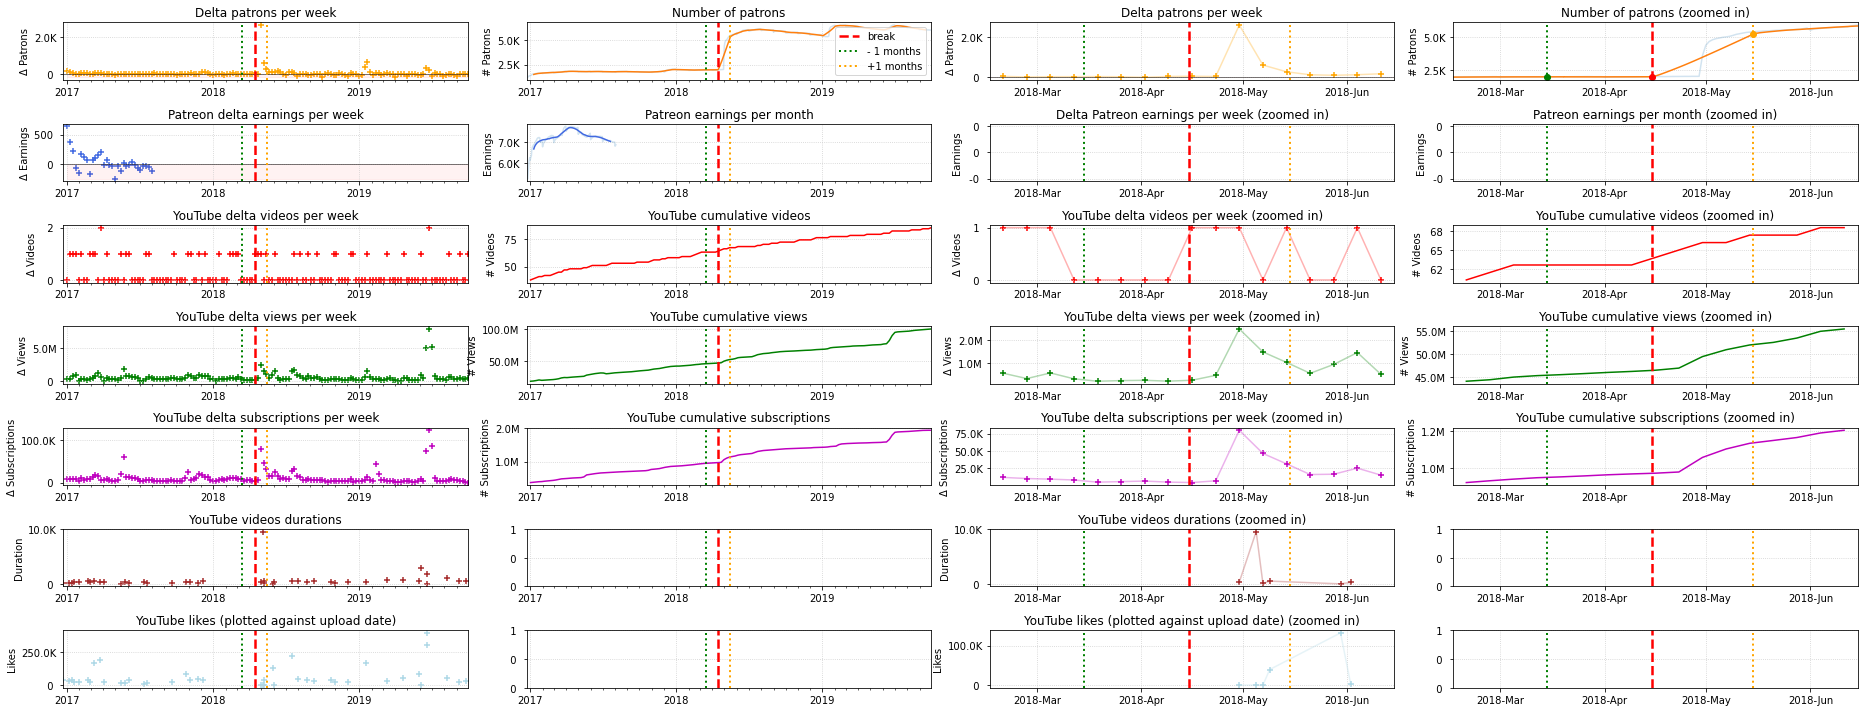




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 2: thecompletionist 
https://www.patreon.com/thecompletionist
https://graphtreon.com/creator/thecompletionist
https://youtube.com/channel/UCPYJR2EIu0_MJaDeSGwkIVw

YouTube Metadata: 
• YT videos were uploaded between August 15, 2014 and September 25, 2019
• YT metadata was crawled between November 14, 2019 and November 14, 2019

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-06-17): 262.6
• At breakpoint          (2017-07-17): 264.3
• At breakpoint + 30days (2017-08-17): 846.3

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-06-17 to 2017-07-17:        d1  =   +1.7 patrons
• Increase of patrons from 2017-07-17 to 2017-08-17:        d2  = +582.0 patrons

Ratio of the increases of the 2 periods: 
• Ratio between

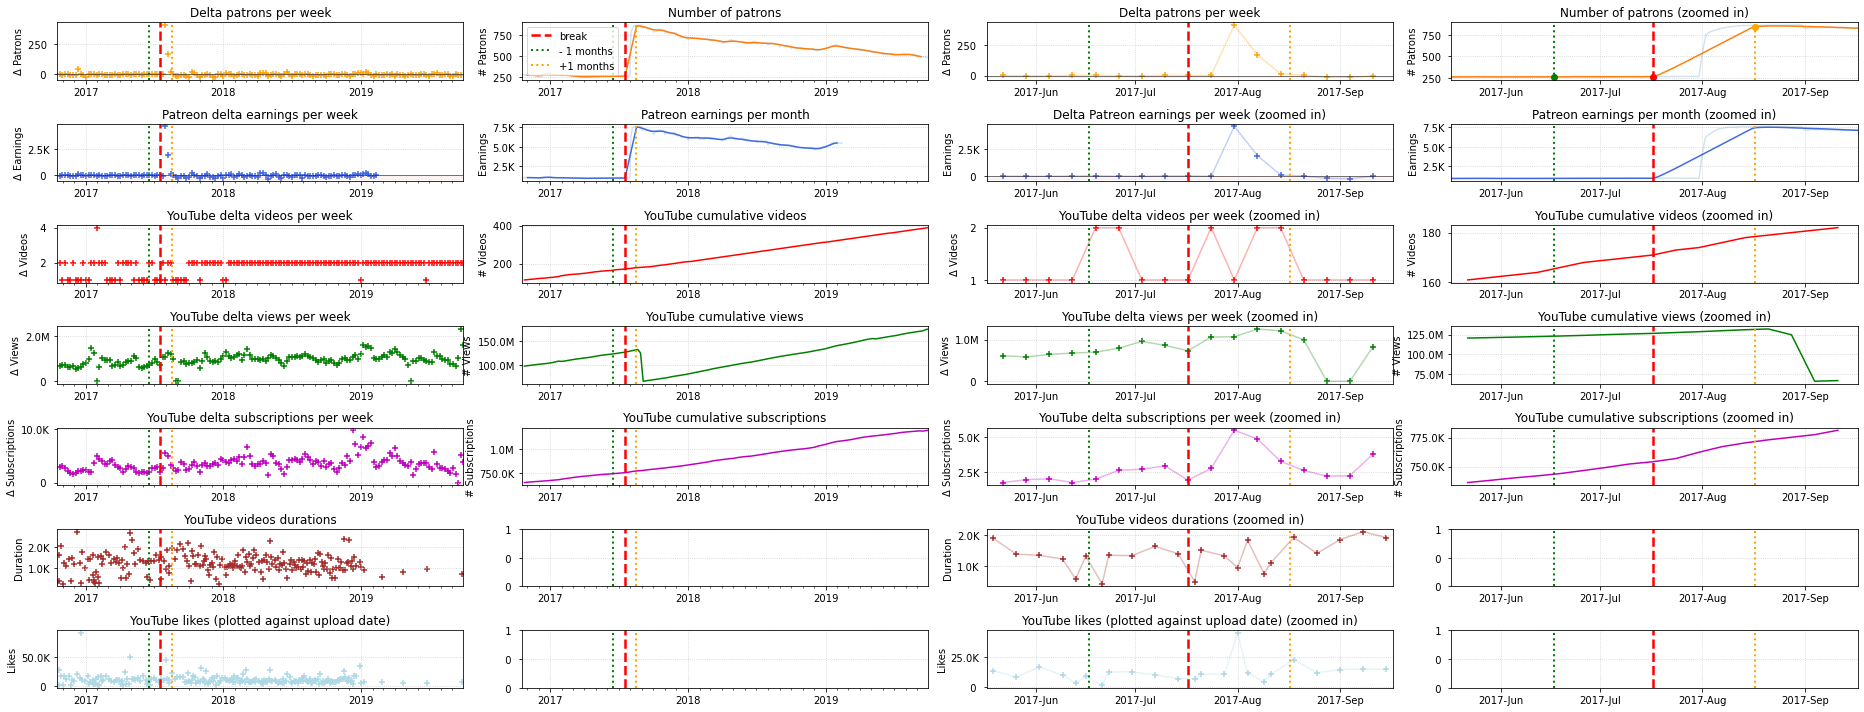




---------------------------------------------------------------------------------------------------------------------------------------------------



Rank 3: billwurtz 
https://www.patreon.com/billwurtz
https://graphtreon.com/creator/billwurtz
https://youtube.com/channel/UCq6aw03lNILzV96UvEAASfQ

YouTube Metadata: 
• YT videos were uploaded between September 30, 2014 and March 18, 2019
• YT metadata was crawled between November 02, 2019 and November 22, 2019

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-03-25): 111.8
• At breakpoint          (2017-04-25): 113.5
• At breakpoint + 30days (2017-05-25): 650.6

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-03-25 to 2017-04-25:        d1  =   +1.7 patrons
• Increase of patrons from 2017-04-25 to 2017-05-25:        d2  = +537.2 patrons

Ratio of the increases of the 2 periods: 
• Ratio between 2 increases:         


KeyboardInterrupt



In [208]:
# compare Patreon and YouTube timeseries + YouTube metadata
month_offset = pd.DateOffset(months=1)
week_offset = pd.DateOffset(weeks=1)
rolling_avg_window = 30

# variables for Granger Tests
MAXLAG = 2
granger_dict = {} # dictionary with  keys (cause --> effect) and values with list of corresponding patreon account(s)
not_granger = []
YT_variables = ['yt_delta_videos', 'yt_delta_views', 'yt_delta_subs']
# PT_variables = ['pt_delta_patrons', 'pt_delta_earning']
PT_variables = ['pt_delta_patrons']

df_granger = df_pt_bkpnt_filt.copy()

# LOOP OVER TOP PATREON ACCOUNTS
for idx, row in df_granger[:10].iterrows():
    fig, axs = plt.subplots(7, 4, figsize=(26, 10), sharey=False, sharex=False)
    
    
    patreon = row['patreon_id']
    ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

    # patreon earnings and users
    tmp_df_pt = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon].copy()  
    
    # youtube videos
    tmp_df_yt = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon].copy()
    
    # youtube metadata
    tmp_df_yt_meta = df_yt_metadata_pt_filtered[df_yt_metadata_pt_filtered['patreon_id'] == patreon].copy()   
    tmp_df_yt_meta = tmp_df_yt_meta.sort_values('upload_date')
    
    # replace dates that were collected after 23:00 to their next day, and remove hour
    tmp_df_yt['datetime_original'] = tmp_df_yt['datetime']
    tmp_df_yt['datetime'] = tmp_df_yt['datetime'].apply(lambda date: (date + pd.DateOffset(days=1)) if date.hour >= 23 else date) 
    
    # remove hours and convert to datetime type
    tmp_df_yt['datetime'] = pd.to_datetime(tmp_df_yt['datetime'].dt.date)
    
    
    ########################## PRINT TITLES ##########################
    
    # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
    ch_ids = tmp_df_yt['channel'].unique()
    print(f"\n\n\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")
    print(f"https://www.{patreon}")
    print(f"https://graphtreon.com/creator/{patreon[12:]}")
    for ch_id in ch_ids:
        print(f"https://youtube.com/channel/{ch_id}")
   
    print(f'\nYouTube Metadata: ')
    print('• YT videos were uploaded between {} and {}'.format(tmp_df_yt_meta['upload_date'].min().strftime('%B %d, %Y'),
                                                             tmp_df_yt_meta['upload_date'].max().strftime('%B %d, %Y')))

    print('• YT metadata was crawled between {} and {}'.format(tmp_df_yt_meta['crawl_date'].min().strftime('%B %d, %Y'),
                                                             tmp_df_yt_meta['crawl_date'].max().strftime('%B %d, %Y')))
    
    ########################## RESTRICT DATES FOR ZOOM OUT ##########################
    
    # set min and max dates for plots   
    date_min = max([tmp_df_yt['datetime'].min(), tmp_df_pt['date'].min()])
    date_max = min([tmp_df_yt['datetime'].max(), tmp_df_pt['date'].max()])
    
    if date_max < date_min:
        print(f":( no overlapping period between YouTube and Patreon datasets\n")
        continue
    
    # restrict datasets between min and max dates
    tmp_df_pt = tmp_df_pt[(tmp_df_pt['date'] >= date_min) & (tmp_df_pt['date'] <= date_max)]
    tmp_df_yt = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min) & (tmp_df_yt['datetime'] <= date_max)]
    tmp_df_yt_meta = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= date_min) & (tmp_df_yt_meta['upload_date'] <= date_max)]
    
    # align both dataframes since youtube starts once a week
    tmp_df_pt = tmp_df_pt[tmp_df_pt['date'] >= tmp_df_yt['datetime'].min()]
    
    
    
    ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
    tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(rolling_avg_window, center=True).mean()
    tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(rolling_avg_window, center=True).mean()
    ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
    # resample time series to get 7 days intervals in order to calculate weekly deltas
    ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
    ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
    ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
    tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
    # reorder columns to have deltas columns next to their respective columns
    patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
    # convert Float64 columns to float64 to avoid Matplotlib NAType error
    ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
              
    ########################## DETECT BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

    breakpoint_date = row['bkpt_date']
    # breakpoint_date = find_breakpoint_v2(tmp_df_pt, 'patrons_ma')
    # print("Breakpoint date: ", breakpoint_date.date())

    # check that dates prior and after breakpoint exist
    if not (((breakpoint_date - 1*month_offset)) in ts_pt_df.index and ((breakpoint_date + 1*month_offset) in ts_pt_df.index)):
        print(f"ERROR: Breakpoint too close to edge of patreon time series or missing data\n")
        plt.figure().clear(); plt.close(); plt.cla(); plt.clf(); plt.show()
        continue
    
    
    ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

    avg_patrons_bkpnt = row['avg_patrons_bkpnt']
    avg_patrons_sub30 = row['avg_patrons_sub30']
    avg_patrons_add30 = row['avg_patrons_add30']
    
    bkpt_date       = row['bkpt_date']
    bkpt_date_sub30 = row['bkpt_date_sub30']
    bkpt_date_add30 = row['bkpt_date_add30']
    
    d1 = row['d1']
    d2 = row['d2']

    
    r = row['ratio']

    print(f'\nAverage number of patrons: (values calculated using a 30 days centered moving average)')
    print(f'• At breakpoint - 30days ({bkpt_date_sub30.date()}): {avg_patrons_sub30:,.1f}')
    print(f'• At breakpoint          ({bkpt_date.date()}): {avg_patrons_bkpnt:,.1f}')
    print(f'• At breakpoint + 30days ({bkpt_date_add30.date()}): {avg_patrons_add30:,.1f}')
    
    print(f'\nIncrease of patrons in the period before and after the breakpoint:')
    print(f"• Increase of patrons from {bkpt_date_sub30.date()} to {bkpt_date.date()}:        d1  = {d1:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date.date()} to {bkpt_date_add30.date()}:        d2  = {d2:>+6.1f} patrons")
    
    print(f'\nRatio of the increases of the 2 periods: ')
    print(f"• Ratio between 2 increases:                            d2/d1  = {r:.2f}")
    print(f"• Percentage increase:                            |d2/d1|*100  = {abs(r):>+.0%}")

    

    ################################### ZOOM OUT PLOTS ###################################
    
    # number of patrons (delta)
    axs[0,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,0].set(title="Delta patrons per week")
    axs[0,0].set_ylabel("Δ Patrons")    
    color_neg_pos(axs[0,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'])

    # number of patrons (cumulative)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons'], alpha=0.2)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons_ma'])
    axs[0,1].set(title="Number of patrons")
    axs[0,1].set_ylabel("# Patrons")

    # patreon earnings (delta)
    axs[1,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,0].set(title="Patreon delta earnings per week")
    axs[1,0].set_ylabel("Δ Earnings") 
    color_neg_pos(axs[1,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'])

    # patreon earnings (cumulative)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning'], alpha=0.2)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning_ma'], color='royalblue')
    axs[1,1].set(title="Patreon earnings per month")
    axs[1,1].set_ylabel("Earnings")
    
    # youtube videos (delta)
    axs[2,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_videos'], c='r', s=30, marker='+')
    axs[2,0].set(title="YouTube delta videos per week")
    axs[2,0].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,0], tmp_df_yt['datetime'], tmp_df_yt['delta_videos'])

    # youtube videos (cumulative)
    axs[2,1].plot(tmp_df_yt['datetime'], tmp_df_yt['videos'], 'r')
    axs[2,1].set(title="YouTube cumulative videos")
    axs[2,1].set_ylabel("# Videos")

    # youtube views (delta)
    axs[3,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_views'], c='g', s=30, marker='+')
    axs[3,0].set(title="YouTube delta views per week")
    axs[3,0].set_ylabel("Δ Views")
    color_neg_pos(axs[3,0], tmp_df_yt['datetime'], tmp_df_yt['delta_views'])

    # youtube views (cumulative)
    axs[3,1].plot(tmp_df_yt['datetime'], tmp_df_yt['views'], 'g')
    axs[3,1].set(title="YouTube cumulative views")
    axs[3,1].set_ylabel("# Views")

    # youtube subs (delta)
    axs[4,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_subs'], c='m', s=30, marker='+')
    axs[4,0].set(title="YouTube delta subscriptions per week")
    axs[4,0].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,0], tmp_df_yt['datetime'], tmp_df_yt['delta_subs'])

    # youtube subs (cumulative)
    axs[4,1].plot(tmp_df_yt['datetime'], tmp_df_yt['subs'], 'm')
    axs[4,1].set(title="YouTube cumulative subscriptions")
    axs[4,1].set_ylabel("# Subscriptions")
    
    
    # youtube durations per uploads
    axs[5,0].scatter(tmp_df_yt_meta['upload_date'], tmp_df_yt_meta['duration'], c='brown', s=30, marker='+')
    axs[5,0].set(title="YouTube videos durations")
    axs[5,0].set_ylabel("Duration")
    
    
    # youtube likes at crawl date
    axs[6,0].scatter(tmp_df_yt_meta['upload_date'], tmp_df_yt_meta['like_count'], c='lightblue', s=30, marker='+')
    axs[6,0].set(title="YouTube likes (plotted against upload date)")
    axs[6,0].set_ylabel("Likes")
    
    
        

    ########################## RESTRICT DATES FOR ZOOM IN (+/- 2 months around breakpoint) ##########################

    # calculate min and max dates for zoom
    date_min_zoom = breakpoint_date - (2 * month_offset)
    date_max_zoom = breakpoint_date + (2 * month_offset)
            
    # restrict datasets between min and max dates
    tmp_df_pt_zoomed = tmp_df_pt[(tmp_df_pt['date'] >= date_min_zoom) & (tmp_df_pt['date'] <= date_max_zoom)].copy()
    tmp_df_yt_zoomed = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min_zoom) & (tmp_df_yt['datetime'] <= date_max_zoom)].copy()
    tmp_df_yt_meta_zoomed = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= date_min_zoom) & (tmp_df_yt_meta['upload_date'] <= date_max_zoom)].copy()

    # used for coloration
    ts_pt_weekly_avg_df_zoomed = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= date_min_zoom) & (ts_pt_weekly_avg_df_float64.index <= date_max_zoom)]
    
    
   ################################### ZOOM IN PLOTS  ###################################

    # zoomed in patron numbers (delta)
    axs[0,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', alpha=0.3)
    axs[0,2].set(title="Delta patrons per week")
    axs[0,2].set_ylabel("Δ Patrons")
    color_neg_pos(axs[0,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'])
    
    # zoomed in patron numbers (cumulative)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons'], alpha=0.2)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons_ma'])
    axs[0,3].set(title="Number of patrons (zoomed in)")
    axs[0,3].set_ylabel("# Patrons")
    
    # zoomed in patron earnings (delta)
    axs[1,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', alpha=0.3)
    axs[1,2].set(title="Delta Patreon earnings per week (zoomed in)")
    axs[1,2].set_ylabel("Earnings")  
    color_neg_pos(axs[1,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_earning'])

    # zoomed in patron earnings (cumulative)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning'], alpha=0.2)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning_ma'], color='royalblue')
    axs[1,3].set(title="Patreon earnings per month (zoomed in)")
    axs[1,3].set_ylabel("Earnings")
    
    # zoomed in youtube videos (delta)
    axs[2,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', s=30, marker='+')
    axs[2,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', alpha=0.3)
    axs[2,2].set(title="YouTube delta videos per week (zoomed in)")
    axs[2,2].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_videos'])

    # zoomed in youtube videos (cumulative)
    axs[2,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['videos'], 'r')
    axs[2,3].set(title="YouTube cumulative videos (zoomed in)")
    axs[2,3].set_ylabel("# Videos")

    # zoomed in youtube views (delta)
    axs[3,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', s=30, marker='+')
    axs[3,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', alpha=0.3)
    axs[3,2].set(title="YouTube delta views per week (zoomed in)")
    axs[3,2].set_ylabel("Δ Views")
    color_neg_pos(axs[3,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_views'])

    # zoomed in youtube views (cumulative)
    axs[3,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['views'], 'g')
    axs[3,3].set(title="YouTube cumulative views (zoomed in)")
    axs[3,3].set_ylabel("# Views")
    
    # zoomed in youtube subs (delta)
    axs[4,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', s=30, marker='+')
    axs[4,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', alpha=0.3)
    axs[4,2].set(title="YouTube delta subscriptions per week (zoomed in)")
    axs[4,2].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_subs'])

    # zoomed in youtube subs (cumulative)
    axs[4,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['subs'], 'm')
    axs[4,3].set(title="YouTube cumulative subscriptions (zoomed in)")
    axs[4,3].set_ylabel("# Subscriptions")
    
    
    # youtube durations per uploads
    axs[5,2].scatter(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'], c='brown', s=30, marker='+')
    axs[5,2].plot(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'], c='brown', alpha=0.3)
    axs[5,2].set(title="YouTube videos durations (zoomed in)")
    axs[5,2].set_ylabel("Duration")
    color_neg_pos(axs[5,2], tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'])
    
        
   # youtube likes per uploads
    axs[6,2].scatter(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['like_count'], c='lightblue', s=30, marker='+')
    axs[6,2].plot(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['like_count'], c='lightblue', alpha=0.3)
    axs[6,2].set(title="YouTube likes (plotted against upload date) (zoomed in)")
    axs[6,2].set_ylabel("Likes")
    color_neg_pos(axs[5,2], tmp_df_yt_meta_zoomed['crawl_date'], tmp_df_yt_meta_zoomed['like_count'])
    
    
    
    ################################### FORMAT AXES ###################################

    # format the axes
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if j < 2:
                axs[i,j].set_xlim([date_min, date_max])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].xaxis.set_major_locator(mdates.YearLocator())
                axs[i,j].xaxis.set_minor_locator(mdates.MonthLocator())
            if j >= 2:
                axs[i,j].set_xlim([date_min_zoom, date_max_zoom])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                axs[i,j].xaxis.set_major_locator(mdates.MonthLocator())
                # axs[i,j].xaxis.set_minor_locator(mdates.WeekdayLocator())
            axs[i,j].xaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.set_major_formatter(KM_formatter)
            
            
    ################################### PLOT BREAKPOINT LINES AND POINTS ###################################

    # plot vertical lines for breakpoint, breakpoint-1month, breakpoint+1month
    print_legend = True
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if print_legend:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', label='break', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - month_offset, color='green', linestyle=':', label='- ' + str(month_offset.months)+' months', linewidth=2)
                axs[i,j].axvline(breakpoint_date + month_offset, color='orange', linestyle=':', label='+' + str(month_offset.months)+' months', linewidth=2)          
                # print_legend = False
            else:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - month_offset, color='green', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + month_offset, color='orange', linestyle=':', linewidth=2)
    # axs[0,0].legend()
    axs[0,1].legend()

    # plot point for mean nb of patrons for breakpoint, breakpoint-1month, breakpoint+1month    
    axs[0,3].plot(breakpoint_date - month_offset, ts_pt_df.at[(breakpoint_date - month_offset), 'patrons_ma'], marker='o', color='green')
    axs[0,3].plot(breakpoint_date,               ts_pt_df.at[breakpoint_date              , 'patrons_ma'], marker='o', color='red')    
    axs[0,3].plot(breakpoint_date + month_offset, ts_pt_df.at[(breakpoint_date + month_offset), 'patrons_ma'], marker='o', color='orange')    


    ################################### GRANGER CAUSALITY TESTS ###################################

    # create a new dataframe with merged columns (the dates might have a day difference)
    selected_pt_columns  = ['delta_earning', 'delta_patrons']
    df_pt = ts_pt_weekly_avg_df_zoomed
    df_pt = df_pt[selected_pt_columns].reset_index().add_prefix('pt_')

    # selected_yt_columns = ['datetime', 'delta_views', 'delta_subs', 'delta_videos']
    selected_yt_columns = ['datetime', 'datetime_original', 'delta_views', 'delta_subs', 'delta_videos']
    df_yt = tmp_df_yt_zoomed
    df_yt = df_yt[selected_yt_columns].reset_index().add_prefix('yt_')

    # concatenated 2 dfs and select and reorder columns
    df_concat = pd.concat([df_pt, df_yt], axis=1)
    concat_columns = ['pt_date', 'yt_datetime', 'pt_delta_earning', 'pt_delta_patrons', 'yt_delta_views', 'yt_delta_subs', 'yt_delta_videos']
    df_concat = df_concat[concat_columns]
    # df_concat['dates_match'] = df_concat['pt_date'] == df_concat['yt_datetime']
    
    # display(df_concat.round())
    # display(df_concat.style.set_caption(f"df_concat"))
    
    
    
    print(f"\nGranger Causality Tests:")
    
    granger_causal_link = False
    for pt_var in PT_variables:
        for yt_var in YT_variables:
            
            # if nan values in this df, skip
            if df_concat[[yt_var, pt_var]].isna().values.any():
                continue
                
            pvalue_fwd = {}
            pvalue_rev = {}
            
            try:
                # print(f'\n\n• {pt_var} --> {yt_var}')
                granger_test_fwd = grangercausalitytests(df_concat[[yt_var, pt_var]], maxlag=MAXLAG, verbose=False)  
                # print(f'\n\n• {yt_var} --> {pt_var}')
                granger_test_rev = grangercausalitytests(df_concat[[pt_var, yt_var]], maxlag=MAXLAG, verbose=False) 
            except Exception:
                continue


            for lag in range(1, MAXLAG+1):           
                pvalue_fwd[lag] = granger_test_fwd[lag][0]['ssr_ftest'][1]
                pvalue_rev[lag] = granger_test_rev[lag][0]['ssr_ftest'][1]
                
            
            
            
            min_pvalue_fwd = min(pvalue_fwd.values())
            if min_pvalue_fwd < 0.05:
                granger_causal_link = True
                min_lag_fwd = [k for k, v in pvalue_fwd.items() if v == min_pvalue_fwd][0]
                print(f'• {pt_var} --> {yt_var} (pvalue={min_pvalue_fwd:.3f}, lag={min_lag_fwd})')

                # add value to df
                df_granger.loc[idx, pt_var+'->'+yt_var] = 1

                if (pt_var, yt_var) in granger_dict:                   
                    granger_dict[(pt_var, yt_var)].append(patreon)
                else:
                    granger_dict[(pt_var, yt_var)] = [patreon]
            else: 
                df_granger.loc[idx, pt_var+'->'+yt_var] = 0
                
                
                
            min_pvalue_rev = min(pvalue_rev.values())
            if min_pvalue_rev < 0.05:
                granger_causal_link = True
                min_lag_rev = [k for k, v in pvalue_rev.items() if v == min_pvalue_rev][0]
                print(f'• {yt_var} --> {pt_var} (pvalue={min_pvalue_rev:.3f}, lag={min_lag_rev})')

                # add value to df
                df_granger.loc[idx, yt_var+'->'+pt_var] = 1
                
                if (yt_var, pt_var) in granger_dict:
                    granger_dict[(yt_var, pt_var)].append(patreon)
                else:
                    granger_dict[(yt_var, pt_var)] = [patreon]
            else: 
                df_granger.loc[idx, yt_var+'->'+pt_var] = 0
                

    if (granger_causal_link == False):
        print("• No Granger causality found for this account")
        not_granger.append(patreon)
    
    print("\n")

    fig.tight_layout(w_pad=0)
    plt.show()
    
    print('\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------')
    
# print('\n\nGranger tests summary statistics:')
    
# print(f'• Number of patreon accounts analysed (patrons increase ratio > {incr_thresh_ratio}): {len(df_granger)}')
# print(f'• Number of patreon with no Granger-causal link: {len(not_granger)} ({len(not_granger)/len(df_granger):.0%})')

# print(f'• Number of patreon accounts per Granger-causal link:')
# # Converting granger dict into list of tuples (in order to sort it), the 2nd value of the tuple being the count of accounts
# granger_list = [(k, len(v)) for k, v in granger_dict.items()]
# # sort by count desc
# granger_list_desc = sorted(granger_list, key=lambda tup: -tup[1])
# for (k,v) in granger_list_desc:
#     print(f'    • {k[0]} \t--> {k[1]}:\t {v} ({v/len(df_granger):.0%})')


# df_granger[columns] = df_granger[columns].astype('Int64')
# df_granger

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,patreon_id
1400838,Entertainment,UCXX7AV8HDBCZXbKRHJYYODg,2019-11-01 04:49:17.822361,SUPPORT SIMONE ON PATREON!!! https://www.patre...,4.0,JFh0URrC4K0,396,146.0,NaN,🔴 Let's hang out while I attempt to vacuum form,2018-04-30,4058.0,patreon.com/simonegiertz
2261157,Education,UCvjgXvBlbQiydffZU7m1_aw,2019-11-14 04:24:23.474019,"In this live stream, I attempt a Star Wars the...",10.0,ORwIZCKJA-Q,9560,395.0,"tensorflow tutorial,tensorflow tutorial for be...",Live Stream #135: May 4th Challenge + TensorFl...,2018-05-05,13301.0,patreon.com/simonegiertz
2888087,People & Blogs,UC9F1oi-iiMDuruSxeAHJQGg,2019-11-14 20:27:31.150941,I learned some awful news today. One of my her...,1.0,LgBzSVKaaoU,128,113.0,"Will Pemble,Simone Giertz",Simone has a brain tumor,2018-05-07,2547.0,patreon.com/simonegiertz
3218708,Science & Technology,UC3KEoMzNz8eYnwBC34RaKCQ,2019-10-31 10:22:39.164280,HERE'S THE TALK: 🔴http://www.youtube.com/watch...,143.0,GEIvFfeSjuE,560,39492.0,"ted,ted talks,vancouver,googly eyes,presentati...",[BEHIND THE SCENES] I gave a TED Talk,2018-05-09,663544.0,patreon.com/simonegiertz
3218707,Science & Technology,UC3KEoMzNz8eYnwBC34RaKCQ,2019-10-31 10:22:38.462193,We’ll post an update on Instagram and Twitter ...,1138.0,gS1DbvHHVH0,59,131761.0,NaN,Going in to brain surgery,2018-05-30,2068250.0,patreon.com/simonegiertz
2283646,Howto & Style,UCJUn6QmXuFV9CkuJB9T7F_w,2019-11-20 01:24:40.314195,Support our friend Simone on Patreon: https://...,1621.0,eHPCD9-OBtM,331,3790.0,"goldieblox,goldiesquad,diy robot,robot battle,...",Barbie Bot vs American Girl Robot | GoldieBots,2018-06-02,912157.0,patreon.com/simonegiertz


### 2.5 Plots (II)

#### 2.5.1 Plot YouTube timeseries for channels matching top Patreon accounts

In [94]:
# # load matching dataframe
# df_matched_channel_patreon = pd.read_csv(LOCAL_DATA_FOLDER+"df_matched_channel_patreon.tsv.gz", sep="\t", compression="gzip")

In [95]:
# # add patreon_id column to YT timeseries
# df_yt_timeseries_filt4_merged = df_yt_timeseries_filt4.merge(df_matched_channel_patreon, left_on='channel', right_on='channel_id')
# df_yt_timeseries_filt4_merged.head(1)

In [96]:
# filter channels matching top patreon accounts
# df_yt_timeseries_top_pt = df_yt_timeseries_filt4_merged[df_yt_timeseries_filt4_merged['patreon_id'].isin(top_patreons)]
# top_yt_patreons = df_yt_timeseries_top_pt.patreon_id.unique()
# top_yt_patreons

In [97]:
# df_yt_ts_top_views = df_yt_timeseries_filt4_merged.groupby(['patreon_id', 'channel_id'])\
#                                                      .agg(datetime_cnt=('datetime', 'count'),
#                                                           views_max=('views', 'max'),
#                                                           subs_date=('subs', 'max'),
#                                                           videos_max=('videos', 'mean'))\
#                                                      .sort_values(by=['videos_max'], ascending=False)\
#                                                      .reset_index()[:10]
# df_yt_ts_top_views

In [98]:
# # get top 10 youtube channels in terms of views
# top_channel_ids = df_yt_ts_top_views['channel_id'].unique()
# top_channel_ids

In [99]:
# # plot YT timeseries for top youtube accounts
# fig, axs = plt.subplots(int(math.ceil(len(top_channel_ids)/2)), 2, figsize=(12, len(top_channel_ids)*1.2), sharey=False, sharex=False)
# for idx, chan_id in enumerate(top_channel_ids):
#     row = math.floor(idx/2)
#     col = idx % 2
#     sbplt = axs[row, col]

#     tmp_df = df_yt_timeseries_filt4_merged[df_yt_timeseries_filt4_merged['channel_id'] == chan_id]

#     sbplt.plot(tmp_df['datetime'], tmp_df['views'])
#     sbplt.set(title=tmp_df['channel'].iloc[0])
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
    
# fig.suptitle(f'Timeseries of the YouTube channels with most views \n (views per week)', fontweight="bold")
# fig.text(0.5,0, 'Week')
# fig.text(0,0.5, 'Views', rotation = 90)
# fig.tight_layout(pad=3, w_pad=5, h_pad=2)

#### 2.5.2 Plot Patreon Time Series

In [100]:
# # RE-declare global variable for size of original GT dataset
# GT_final_processed_file_ROWS = 232_269

In [101]:
# !ls -lh {LOCAL_DATA_FOLDER}dailyGraph_earningsSeries.tsv.gz

In [102]:
# # read file from disk
# df_dailyGraph_earningsSeries = pd.read_csv(LOCAL_DATA_FOLDER+"/dailyGraph_earningsSeries.tsv.gz", sep="\t", compression='gzip')
# df_dailyGraph_earningsSeries.date = pd.to_datetime(df_dailyGraph_earningsSeries.date, unit='ms')
# df_dailyGraph_earningsSeries

##### Restrict patreons corresponding to the top 10

In [103]:
# TOP_CNT = 10
# # group by patreon account
# dailyGraph_grp_patreon = df_dailyGraph_earningsSeries.groupby('patreon')\
#                                                      .agg(date_cnt=('date', 'count'),
#                                                           earliest_date=('date', 'min'),
#                                                           lastest_date=('date', 'max'),
#                                                           daily_earning_mean=('earning', 'mean'),
#                                                           daily_earning_max=('earning', 'max'))\
#                                                      .sort_values(by=['daily_earning_max'], ascending=False)\
#                                                      .reset_index()\
#                                                      .round(2)

# # remove hours from dates
# dailyGraph_grp_patreon.earliest_date = dailyGraph_grp_patreon.earliest_date.dt.date
# dailyGraph_grp_patreon.lastest_date = dailyGraph_grp_patreon.lastest_date.dt.date

# dailyGraph_grp_patreon

# # extract the top 10 most profitable patreon accounts
# top_patreons = dailyGraph_grp_patreon[:TOP_CNT]['patreon']

# print("[Graphtreon Timeseries] Total number of patreon ids (original file):            {:>9,}".format(GT_final_processed_file_ROWS))
# print("[Graphtreon Timeseries] Nb of patreon ids in dailyGraph earnings time series:   {:>9,} ({:.1%} of original dataset)".format(len(dailyGraph_grp_patreon), len(dailyGraph_grp_patreon)/GT_final_processed_file_ROWS))

# print()

# dailyGraph_grp_patreon[:TOP_CNT].style.set_caption(f"Top {TOP_CNT} highest-earning Patreon accounts (sorted by max daily earnings)")



In [104]:
# # join to get the corresponding channel_id
# df_dailyGraph_earningsSeries_merged = df_dailyGraph_earningsSeries.merge(df_matched_channel_patreon, left_on='patreon', right_on='patreon_id')
# df_dailyGraph_earningsSeries_merged.head(3)

In [105]:
# top_channel_ids

In [106]:
# df_dailyGraph_earningsSeries_merged.groupby(['channel_id', 'patreon_id']).count()

In [107]:
# # plot Patreon daily earningsSeriesData for top patreon accounts
# fig, axs = plt.subplots(int(len(top_channel_ids)/2), 2, figsize=(12, len(top_channel_ids)*1.2), sharey=False, sharex=False)
# for idx, chan_id in enumerate(top_channel_ids):
#     row = math.floor(idx/2)
#     col = idx % 2
#     sbplt = axs[row, col]

#     tmp_df = df_dailyGraph_earningsSeries_merged[df_dailyGraph_earningsSeries_merged['channel_id'] == chan_id]
#     sbplt.plot(tmp_df['date'], tmp_df['earning'])
#     sbplt.set(title=chan_id)
#     sbplt.xaxis.set_major_locator(years)
#     sbplt.xaxis.set_major_formatter(years_fmt)
#     sbplt.xaxis.set_minor_locator(months)
    
    
# fig.suptitle(f'Timeseries of the Patreon accounts corresponding to YT channel with most views\n (earnings per day in dollars)', fontweight="bold")
# fig.text(0.5,0, 'Day')
# fig.text(0,0.5, 'Earnings per day ($)', rotation = 90)
# fig.tight_layout(pad=3, w_pad=5, h_pad=2)

In [108]:
# # analyse 1 account in detail
# patreon_account = 'patreon.com/tinymeatgang'

# with pd.option_context('display.max_rows', 90, 'display.min_rows', 90):
#     display(df_top_pt_daily_earnings[(df_top_pt_daily_earnings['patreon'] == patreon_account) 
#                                      # & (df_top_pt_daily_earnings['date'] > pd.Timestamp('2021-01-01'))
#                                     ].head(90))
        
# df_top_pt_daily_earnings.dtypes

# # check for NaN values
# df_top_pt_daily_earnings[df_top_pt_daily_earnings.isna().any(axis=1)]

#### 2.5.3 Compare YouTube and top Patreon timeseries

In [109]:
# # compare YouTube and Patreon timeseries for top patreon accounts
# for idx, patreon in enumerate(top_patreons[:1]):
    
#     fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharey=False, sharex=True)

#     # patreon earnings
#     tmp_df_pt = df_top_pt_daily_earnings[df_top_pt_daily_earnings['patreon'] == patreon]

#     axs[0].plot(tmp_df_pt['date'], tmp_df_pt['earning'])
#     axs[0].set(title="Patreon earnings")
#     axs[0].set_ylabel("Earnings ($)")
    
#     axs[0].xaxis.set_major_locator(years)
#     axs[0].xaxis.set_major_formatter(years_fmt)
#     axs[0].xaxis.set_minor_locator(months)
    

#     # youtube views
#     tmp_df_yt = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     axs[1].plot(tmp_df_yt['datetime'], tmp_df_yt['views'])
#     axs[1].set(title="YouTube views")
#     axs[1].set_ylabel("Views")

#     axs[1].xaxis.set_major_locator(years)
#     axs[1].xaxis.set_major_formatter(years_fmt)
#     axs[1].xaxis.set_minor_locator(months)
    
    
#     # youtube subs
#     tmp_df3 = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     axs[2].plot(tmp_df3['datetime'], tmp_df3['subs'])
#     axs[2].set(title="YouTube subscriptions")
#     axs[2].set_ylabel("Subscriptions")

#     axs[2].xaxis.set_major_locator(years)
#     axs[2].xaxis.set_major_formatter(years_fmt)
#     axs[2].xaxis.set_minor_locator(months)
    
    
#     # youtube videos
#     tmp_df4 = df_yt_timeseries_top_pt[df_yt_timeseries_top_pt['patreon_id'] == patreon]

#     axs[3].plot(tmp_df4['datetime'], tmp_df4['videos'])
#     axs[3].set(title="YouTube videos")
#     axs[3].set_ylabel("Videos")

#     axs[3].xaxis.set_major_locator(years)
#     axs[3].xaxis.set_major_formatter(years_fmt)
#     axs[3].xaxis.set_minor_locator(months)
    
#     ch_id = tmp_df_yt['channel'].unique()[0]
#     fig.suptitle(f'{patreon}\nchannel id(s): {ch_id}', fontweight="bold")
#     fig.tight_layout()